# Telco Customer Churn IBM #

## 1. Introducción ##

El Objetivo es dimnuir el Churn reflejado en la variable Customer Status con el fin de incrementar las ganancias. Para esto, procede hacer una limpieza de datos, una analís exploratorio, una ingeniería de características para aplicar modelos predictivos y finalmente proponer soluciones. Asimimos, los campos Churn Category y Churn Reason permiten aplicar estrategías intentar retener a lois clientes. Dado que, los árboles son útiles con datos tabulares y simplican algunas tareas como la ingeniera de características, se propone inicialmente este modelo. 



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, accuracy_score,
                           precision_score, recall_score, f1_score)
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import xgboost as xgb

import itertools

from scipy.stats import chi2_contingency
import warnings

from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
from scipy.stats import pearsonr, chi2_contingency, kruskal

import warnings



warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

1. Carga de datos

In [51]:
df_test = pd.read_csv('base_telco.csv')


## 2. Estado inicial de los datos

En los datos, se observan faltantes debido a que en Churn Category y Churn Reason solo aplica a los clientes que se fueron; esto mismo pasa con las variables relacionadas a los servicios de internet y a los servicios de teléfono. Por último, la característica oferta es faltante cuando el cliente no aceptado ninguna oferta.

In [52]:
df_test.head(5)


,Customer ID,Gender,Age,Married,Number of Dependents,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,2,9,NaN,Yes,42.39,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,0,9,NaN,Yes,10.69,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,0,4,Offer E,Yes,33.65,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,1,13,Offer D,Yes,27.82,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,3,3,NaN,Yes,7.38,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


### Análisis de datos faltantes


In [53]:
# Análisis de datos faltantes por columna en el dataset df_test
missing_data = df_test.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
print("Cantidad de datos faltantes por columna en df_test:")
# Convertir los datos faltantes a un DataFrame y mostrarlo
missing_data_df = missing_data.reset_index()
missing_data_df.columns = ['Columna', 'Cantidad de Faltantes']
missing_data_df




Cantidad de datos faltantes por columna en df_test:


,Columna,Cantidad de Faltantes
0,Churn Category,5174
1,Churn Reason,5174
2,Offer,3877
3,Online Security,1526
4,Online Backup,1526
5,Avg Monthly GB Download,1526
6,Internet Type,1526
7,Streaming Movies,1526
8,Streaming TV,1526
9,Device Protection Plan,1526


In [54]:
# Identificar columnas numéricas y categóricas, excluyendo el id del cliente
cols_excluir = ['Customer ID','Churn Category', 'Churn Reason','Total Charges', 'Total Refunds', 'Total Extra Data Charges',
       'Total Long Distance Charges']

# Eliminar columnas innecesarias para el análisis
df_test = df_test.drop(columns=cols_excluir)


categorical_cols = [col for col in df_test.select_dtypes(include=['object', 'category']).columns if col not in cols_excluir]
numeric_cols = [col for col in df_test.select_dtypes(include=['number']).columns if col not in cols_excluir]

print("Cantidad de columnas categóricas :", len(categorical_cols))
print("Cantidad de columnas numéricas :", len(numeric_cols))




Cantidad de columnas categóricas : 19
Cantidad de columnas numéricas : 8


## 3. Limpieza de datos

Para un mejora trabajo se cambia los nombres de las columnas.

In [55]:
# Cambiar los nombres de las columnas a camelCase
def to_camel_case(s):
    parts = s.strip().replace('_', ' ').replace('-', ' ').split()
    return parts[0].lower() + ''.join(word.capitalize() for word in parts[1:])

df_test.columns = [to_camel_case(col) for col in df_test.columns]

df_test_copy = df_test.copy()

df_test_copy.columns

Index(['gender', 'age', 'married', 'numberOfDependents', 'numberOfReferrals',
       'tenureInMonths', 'offer', 'phoneService',
       'avgMonthlyLongDistanceCharges', 'multipleLines', 'internetService',
       'internetType', 'avgMonthlyGbDownload', 'onlineSecurity',
       'onlineBackup', 'deviceProtectionPlan', 'premiumTechSupport',
       'streamingTv', 'streamingMovies', 'streamingMusic', 'unlimitedData',
       'contract', 'paperlessBilling', 'paymentMethod', 'monthlyCharge',
       'totalRevenue', 'customerStatus'],
      dtype='object')

Se tratan los datos faltantes ya mencionados. En el caso de avgMonthlyGbDownload y avgMonthlyLongDistanceCharges dado que son variables numericas se completa con 0 los faltantes. Por último, se elimina la variable que identifica al cliente customerId

In [56]:
##'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['internetType']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['onlineBackup']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['onlineSecurity']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['deviceProtectionPlan']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['premiumTechSupport']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['streamingTv']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['streamingMovies']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['streamingMusic']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['unlimitedData']] = 'NoInternetService'

##sino tengo servicio de internet el este valor es 0
df_test_copy.loc[df_test_copy['internetService'] == 'No',['avgMonthlyGbDownload']] = 0

##phoneService
df_test_copy.loc[df_test_copy['phoneService'] == 'No',['avgMonthlyLongDistanceCharges']] = 0
df_test_copy.loc[df_test_copy['phoneService'] == 'No',['multipleLines']] = 'NoPhoneService'

##offer
df_test_copy.loc[df_test_copy['offer'].isna(), 'offer'] = 'NoOffer'

#df_test_copy.loc[df_test_copy['customerStatus'] == 'Stayed', ['churnCategory']] = 'NoChurn'
#df_test_copy.loc[df_test_copy['customerStatus'] == 'Stayed', ['churnReason']] = 'NoChurn'
#df_test_copy.loc[df_test_copy['customerStatus'] == 'Joined', ['churnCategory']] = 'NoChurn'
#df_test_copy.loc[df_test_copy['customerStatus'] == 'Joined', ['churnReason']] = 'NoChurn'

#df_test_copy.loc[df_test_copy['internetService'] == 'No',['internetService',
#       'internetType', 'avgMonthlyGbDownload', 'onlineSecurity',
#       'onlineBackup', 'deviceProtectionPlan', 'premiumTechSupport',
#       'streamingTv', 'streamingMovies', 'streamingMusic', 'unlimitedData',
#       'contract', 'paperlessBilling', 'paymentMethod', 'monthlyCharge',
#       'totalCharges', 'totalRefunds', 'totalExtraDataCharges',
#       'totalLongDistanceCharges', 'totalRevenue', 'customerStatus',
#       'churnCategory', 'churnReason']]

##no tiomar en cuenta el customerid
df_final = df_test_copy.copy()
                                                          
##junsta los nuevos con los viejes y que se queden, EDA

In [57]:
df_test_copy.columns

Index(['gender', 'age', 'married', 'numberOfDependents', 'numberOfReferrals',
       'tenureInMonths', 'offer', 'phoneService',
       'avgMonthlyLongDistanceCharges', 'multipleLines', 'internetService',
       'internetType', 'avgMonthlyGbDownload', 'onlineSecurity',
       'onlineBackup', 'deviceProtectionPlan', 'premiumTechSupport',
       'streamingTv', 'streamingMovies', 'streamingMusic', 'unlimitedData',
       'contract', 'paperlessBilling', 'paymentMethod', 'monthlyCharge',
       'totalRevenue', 'customerStatus'],
      dtype='object')

In [ ]:
from scipy.stats import chi2_contingency

# Definir la variable objetivo (asegúrate de que existe en df_test_copy)
target = "customerStatus"

# Seleccionar solo las columnas categóricas (no numéricas) de df_test_copy
categorical_cols = df_test_copy.select_dtypes(include=['object', 'category']).columns.tolist()
# Opcional: quitar la variable objetivo si está en la lista
if target in categorical_cols:
    categorical_cols.remove(target)

for col in df_test_copy.columns:
    # Crear tabla de contingencia entre la columna categórica y la variable objetivo
    contingency_table = pd.crosstab(df_test_copy[col], df_test_copy[target])
    # Si la tabla tiene menos de 2 filas o columnas, saltar (no se puede hacer chi2)
    if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        print(f"Feature: {col}")
        print("No se puede calcular chi2 (menos de 2 categorías en alguna variable)\n")
        continue
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Feature: {col}")
    print("Chi2 Stat:", chi2, " | p-value:", p)
    if p < 0.05:
        print("--> Significant relationship with target ✅\n")
    else:
        print("--> No significant relationship with target ❌\n")
  

Feature: gender
Chi2 Stat: 2.071831839095429  | p-value: 0.35490117109455394
--> No significant relationship with target ❌

Feature: age
Chi2 Stat: 291.9098279688498  | p-value: 5.916962870160421e-16
--> Significant relationship with target ✅

Feature: married
Chi2 Stat: 394.15343021714676  | p-value: 2.5743649669241746e-86
--> Significant relationship with target ✅

Feature: numberOfDependents
Chi2 Stat: 479.7592399511565  | p-value: 1.86508120533257e-90
--> Significant relationship with target ✅

Feature: numberOfReferrals
Chi2 Stat: 1022.3184530573296  | p-value: 3.473208119667675e-202
--> Significant relationship with target ✅

Feature: tenureInMonths
Chi2 Stat: 4390.796075528049  | p-value: 0.0
--> Significant relationship with target ✅

Feature: offer
Chi2 Stat: 1127.2667309284786  | p-value: 6.9823668923356305e-236
--> Significant relationship with target ✅

Feature: phoneService
Chi2 Stat: 2.3288121807186317  | p-value: 0.3121079709316997
--> No significant relationship with ta

In [62]:
df_test.columns

Index(['age', 'married', 'numberOfDependents', 'numberOfReferrals',
       'tenureInMonths', 'offer', 'avgMonthlyLongDistanceCharges',
       'multipleLines', 'internetService', 'internetType',
       'avgMonthlyGbDownload', 'onlineSecurity', 'onlineBackup',
       'deviceProtectionPlan', 'premiumTechSupport', 'streamingTv',
       'streamingMovies', 'streamingMusic', 'unlimitedData', 'contract',
       'paperlessBilling', 'paymentMethod', 'monthlyCharge', 'customerStatus'],
      dtype='object')

In [63]:
try:
    cols_excluir = ['gender','phoneService', 'totalRevenue']
    df_test = df_test.drop(columns=cols_excluir)
except KeyError as e:
    print(f"Alguna columna a excluir no existe en df_test: {e}")
    # Si quieres ignorar faltantes, puedes usar errors='ignore':
    # df_test = df_test.drop(columns=cols_excluir, errors='ignore')
    # O simplemente pasar
    pass


Alguna columna a excluir no existe en df_test: "['gender', 'phoneService', 'totalRevenue'] not found in axis"


Se comprueba que no quedan datos faltante

In [9]:
# Obtener nombres de columnas, tipos de dato y cantidad de datos vacíos, ordenado por datos faltantes
def resumen_columnas(df):
    resumen = pd.DataFrame({
        'Tipo de Dato': df.dtypes,
        'Datos Faltantes': df.isnull().sum(),
        'Porcentaje Faltantes': df.isnull().mean() * 100
    })
    resumen = resumen.sort_values(by='Datos Faltantes', ascending=False)
    return resumen

# Ejemplo de uso:
resumen_columnas(df_test_copy)
# Filtrar las columnas con datos faltantes
resumen = resumen_columnas(df_test_copy)
columnas_con_faltantes = resumen[resumen['Datos Faltantes'] > 0].index.tolist()

# Mostrar los valores únicos por cada columna con datos faltantes
for col in columnas_con_faltantes:
    print(f"\nColumna: {col}")
    print(df_test_copy[col].unique())



In [64]:
df_test_copy.to_csv("df_test_copy.csv", index=False)


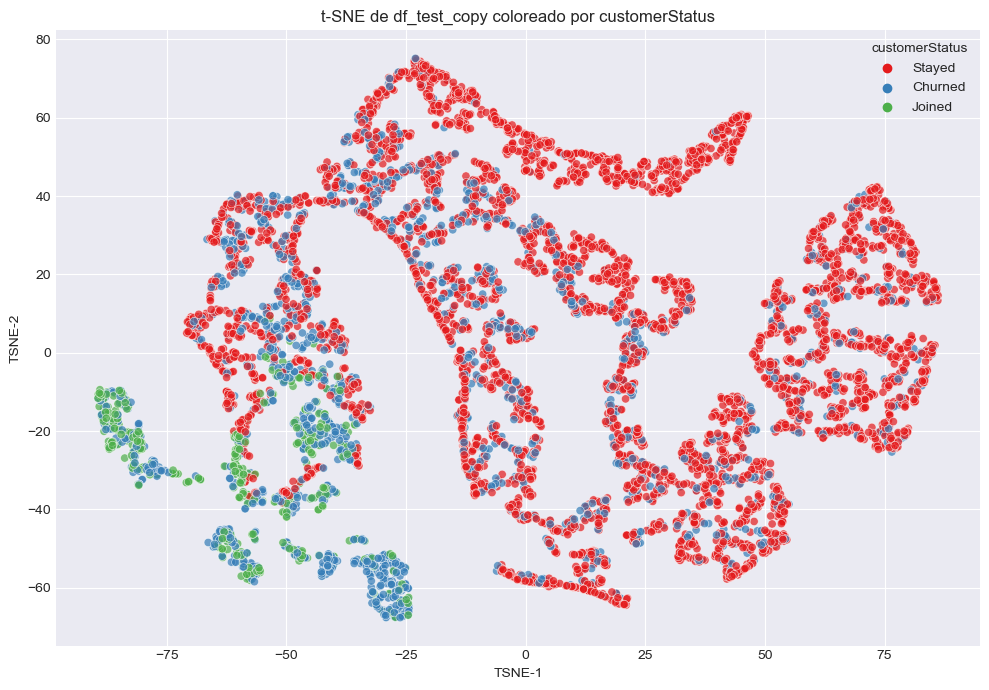

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar solo las variables numéricas para t-SNE (excluyendo la variable objetivo)
X = df_test_copy.select_dtypes(include=['number', 'float', 'int']).copy()

# Si hay valores faltantes, los rellenamos con la media de cada columna
X = X.fillna(X.mean())

# Aplicar t-SNE (puedes ajustar los parámetros si lo deseas)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Crear un DataFrame con los resultados de t-SNE y la variable objetivo
df_tsne = pd.DataFrame({
    'TSNE-1': X_tsne[:, 0],
    'TSNE-2': X_tsne[:, 1],
    'customerStatus': df_test_copy['customerStatus'].values
})

# Graficar los resultados coloreando por customerStatus
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_tsne,
    x='TSNE-1',
    y='TSNE-2',
    hue='customerStatus',
    palette='Set1',
    alpha=0.7
)
plt.title('t-SNE de df_test_copy coloreado por customerStatus')
plt.legend(title='customerStatus')
plt.tight_layout()
plt.show()


Características utilizadas para el clustering jerárquico (X_hier):
['age', 'numberOfDependents', 'numberOfReferrals', 'tenureInMonths', 'avgMonthlyLongDistanceCharges', 'avgMonthlyGbDownload', 'monthlyCharge', 'totalCharges', 'totalRefunds', 'totalExtraDataCharges', 'totalLongDistanceCharges', 'totalRevenue', 'kmeans_cluster', 'dbscan_cluster', 'gmm_cluster', 'hier_cluster']


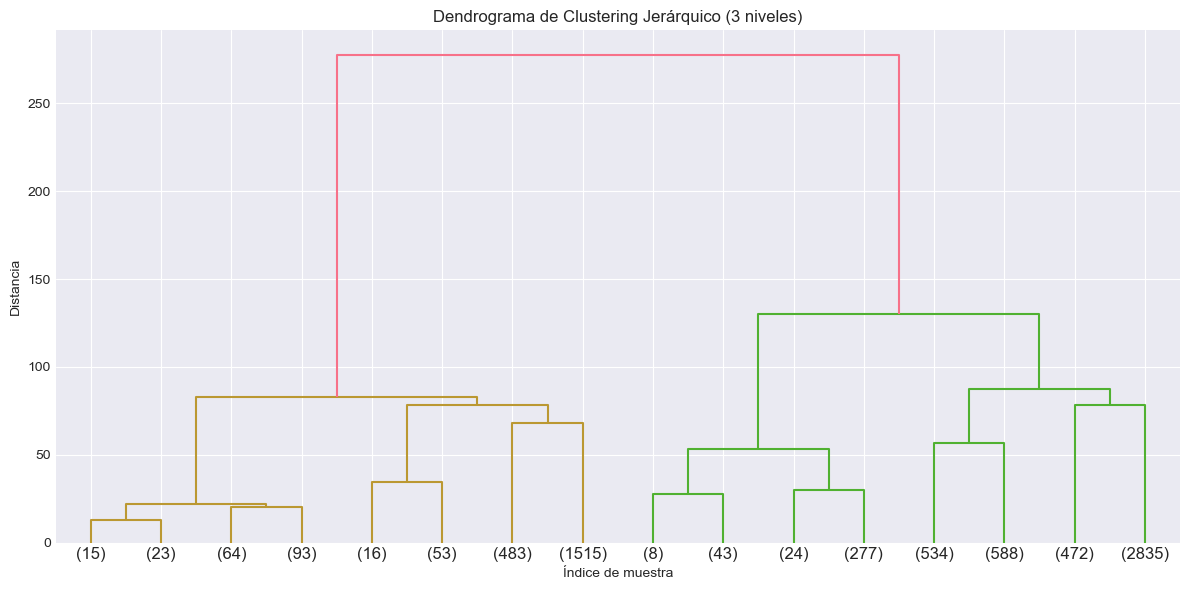

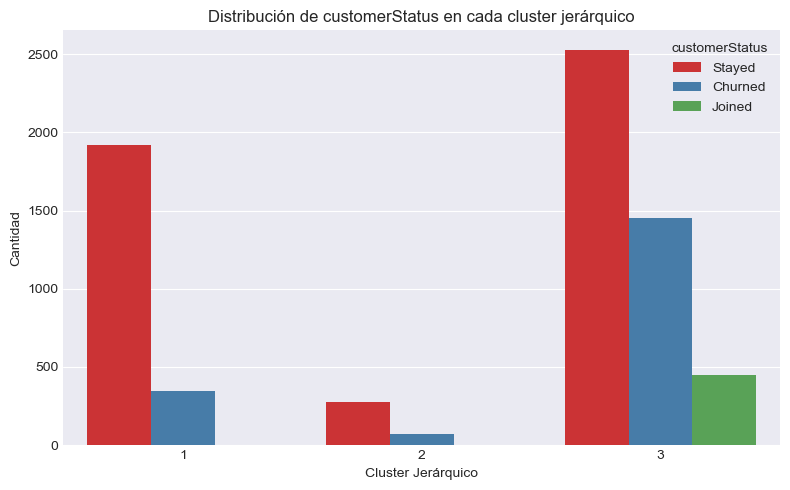


Tabla de contingencia entre clusters jerárquicos y customerStatus:
customerStatus  Churned  Joined  Stayed
hier_cluster                           
1                   345       0    1917
2                    72       3     277
3                  1452     451    2526

--- Contenido del cluster 1 ---
Cantidad de registros: 2262
Proporción de customerStatus en este cluster:
customerStatus
Stayed     0.847
Churned    0.153
Name: proportion, dtype: float64

Estadísticas descriptivas de las variables numéricas:
                                count         mean          std     min  \
age                            2262.0    47.076923    17.425022   19.00   
numberOfDependents             2262.0     0.515031     0.998227    0.00   
numberOfReferrals              2262.0     3.030062     3.362643    0.00   
tenureInMonths                 2262.0    57.365606    13.260941    1.00   
avgMonthlyLongDistanceCharges  2262.0    28.093422    14.411927    0.00   
avgMonthlyGbDownload           2262.0 

In [16]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seleccionar solo las variables numéricas para clustering (excluyendo la variable objetivo)
X_hier = df_test_copy.select_dtypes(include=['number', 'float', 'int']).copy()
X_hier = X_hier.fillna(X_hier.mean())

# Mostrar las características (columnas) utilizadas en X_hier
print("Características utilizadas para el clustering jerárquico (X_hier):")
print(list(X_hier.columns))

# Estandarizar las variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_hier)

# Realizar el linkage para clustering jerárquico (puedes cambiar el método a 'average', 'complete', etc.)
Z = linkage(X_scaled, method='ward')

# Visualizar el dendrograma truncado a 3 niveles
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=3)
plt.title('Dendrograma de Clustering Jerárquico (3 niveles)')
plt.xlabel('Índice de muestra')
plt.ylabel('Distancia')
plt.tight_layout()
plt.show()

# Elegir el número de clusters: 3
n_clusters = 3
clusters_hier = fcluster(Z, n_clusters, criterion='maxclust')

# Añadir los clusters al DataFrame
df_test_copy['hier_cluster'] = clusters_hier

# Visualizar la relación entre los clusters y la variable objetivo
plt.figure(figsize=(8, 5))
sns.countplot(x='hier_cluster', hue='customerStatus', data=df_test_copy, palette='Set1')
plt.title('Distribución de customerStatus en cada cluster jerárquico')
plt.xlabel('Cluster Jerárquico')
plt.ylabel('Cantidad')
plt.legend(title='customerStatus')
plt.tight_layout()
plt.show()

# Mostrar la tabla de contingencia
contingencia = pd.crosstab(df_test_copy['hier_cluster'], df_test_copy['customerStatus'])
print("\nTabla de contingencia entre clusters jerárquicos y customerStatus:")
print(contingencia)

# Mostrar qué contiene cada cluster: estadísticas descriptivas y proporciones de customerStatus
for cluster_id in sorted(df_test_copy['hier_cluster'].unique()):
    print(f"\n--- Contenido del cluster {cluster_id} ---")
    cluster_data = df_test_copy[df_test_copy['hier_cluster'] == cluster_id]
    print(f"Cantidad de registros: {len(cluster_data)}")
    print("Proporción de customerStatus en este cluster:")
    print(cluster_data['customerStatus'].value_counts(normalize=True).round(3))
    print("\nEstadísticas descriptivas de las variables numéricas:")
    print(cluster_data.select_dtypes(include=['number', 'float', 'int']).describe().T)


In [104]:
df_test_copy.columns

Index(['gender', 'age', 'married', 'numberOfDependents', 'numberOfReferrals',
       'tenureInMonths', 'offer', 'phoneService',
       'avgMonthlyLongDistanceCharges', 'multipleLines', 'internetService',
       'internetType', 'avgMonthlyGbDownload', 'onlineSecurity',
       'onlineBackup', 'deviceProtectionPlan', 'premiumTechSupport',
       'streamingTv', 'streamingMovies', 'streamingMusic', 'unlimitedData',
       'contract', 'paperlessBilling', 'paymentMethod', 'monthlyCharge',
       'totalCharges', 'totalRefunds', 'totalExtraDataCharges',
       'totalLongDistanceCharges', 'totalRevenue', 'customerStatus',
       'churnCategory', 'churnReason', 'revenue_por_mes', 'revenue_quartile',
       'is_churn'],
      dtype='object')

In [105]:
# Filtrar para excluir customerStatus 'Joined'
df_filtered = df_test_copy[df_test_copy['customerStatus'] != 'Joined']

# Dataset 1: contract == 'Month-to-Month'
df_month_to_month = df_filtered[df_filtered['contract'] == 'Month-to-Month']

# Dataset 2: contract distinto de 'Month-to-Month'
df_other_contracts = df_filtered[df_filtered['contract'] != 'Month-to-Month']

# Mostrar tamaños para verificación
print("Tamaño df_month_to_month:", df_month_to_month.shape)
print("Tamaño df_other_contracts:", df_other_contracts.shape)


Tamaño df_month_to_month: (3202, 36)
Tamaño df_other_contracts: (3387, 36)


Normalized Mutual Information with respect to customerStatus:
                         Variable  Normalized_MI
0                  tenureInMonths       0.061097
1                  onlineSecurity       0.043055
2                 internetService       0.042009
3              premiumTechSupport       0.039831
4                    totalCharges       0.032913
5                           offer       0.029989
6        totalLongDistanceCharges       0.029210
7                    internetType       0.027745
8                   paymentMethod       0.026908
9               numberOfReferrals       0.026361
10                   onlineBackup       0.025786
11                  unlimitedData       0.020600
12           deviceProtectionPlan       0.018639
13               paperlessBilling       0.017308
14             numberOfDependents       0.016686
15                streamingMovies       0.016482
16                    streamingTv       0.016434
17                            age       0.016159
18     

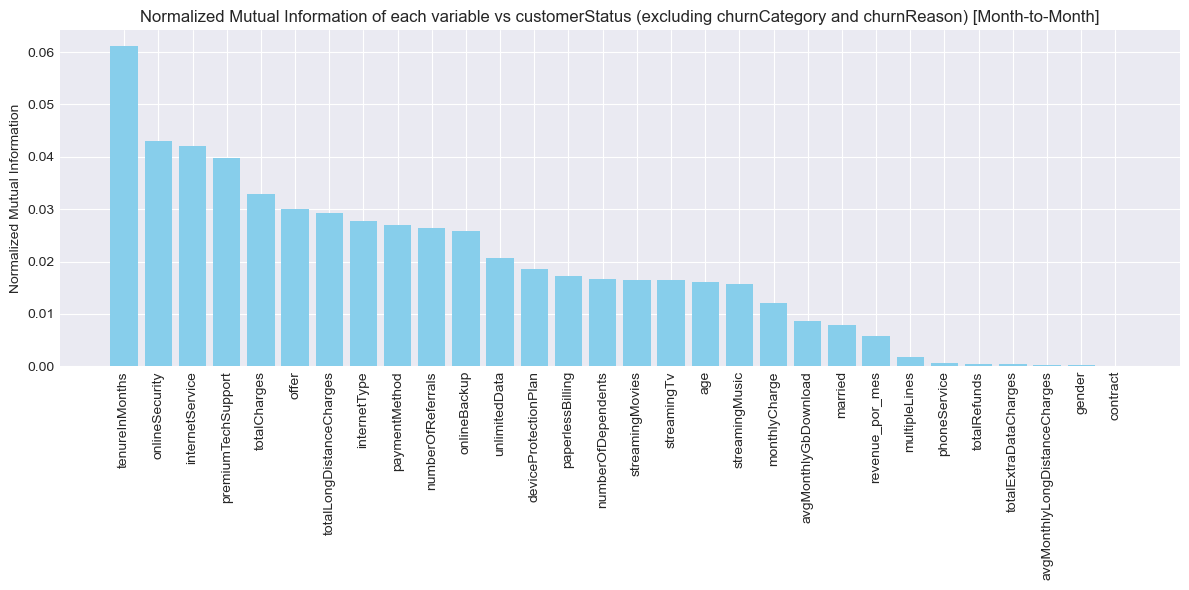

In [90]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mutual_info_score

# 1. Select variables (excluding customerStatus, churnCategory, churnReason, totalRevenue, and any irrelevant columns)
cols_to_exclude = ['customerStatus', 'churnCategory', 'churnReason', 'totalRevenue']
if 'customerId' in df_month_to_month.columns:
    cols_to_exclude.append('customerId')
variables = [col for col in df_month_to_month.columns if col not in cols_to_exclude]

# 2. Encode customerStatus
le_status = LabelEncoder()
y = le_status.fit_transform(df_month_to_month['customerStatus'].astype(str))

# 3. Calculate normalized mutual information for each variable with respect to customerStatus
mi_results = []
for col in variables:
    # If numeric, discretize into 10 bins; if categorical, label encode
    if pd.api.types.is_numeric_dtype(df_month_to_month[col]):
        # Discretize into 10 bins (if more than 10 unique values)
        x = pd.qcut(df_month_to_month[col].rank(method='first'), q=10, duplicates='drop', labels=False)
    else:
        x = LabelEncoder().fit_transform(df_month_to_month[col].astype(str))
    # Calculate MI and normalize
    mi = mutual_info_score(x, y)
    h = mutual_info_score(x, x)  # Entropy of x
    mi_norm = mi / h if h > 0 else 0
    mi_results.append({'Variable': col, 'Normalized_MI': mi_norm})

# 4. Create DataFrame and sort
df_mi = pd.DataFrame(mi_results).sort_values('Normalized_MI', ascending=False).reset_index(drop=True)
print("Normalized Mutual Information with respect to customerStatus:")
print(df_mi)

# 5. Plot bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.bar(df_mi['Variable'], df_mi['Normalized_MI'], color='skyblue')
plt.xticks(rotation=90)
plt.ylabel('Normalized Mutual Information')
plt.title('Normalized Mutual Information of each variable vs customerStatus (excluding churnCategory and churnReason) [Month-to-Month]')
plt.tight_layout()
plt.show()




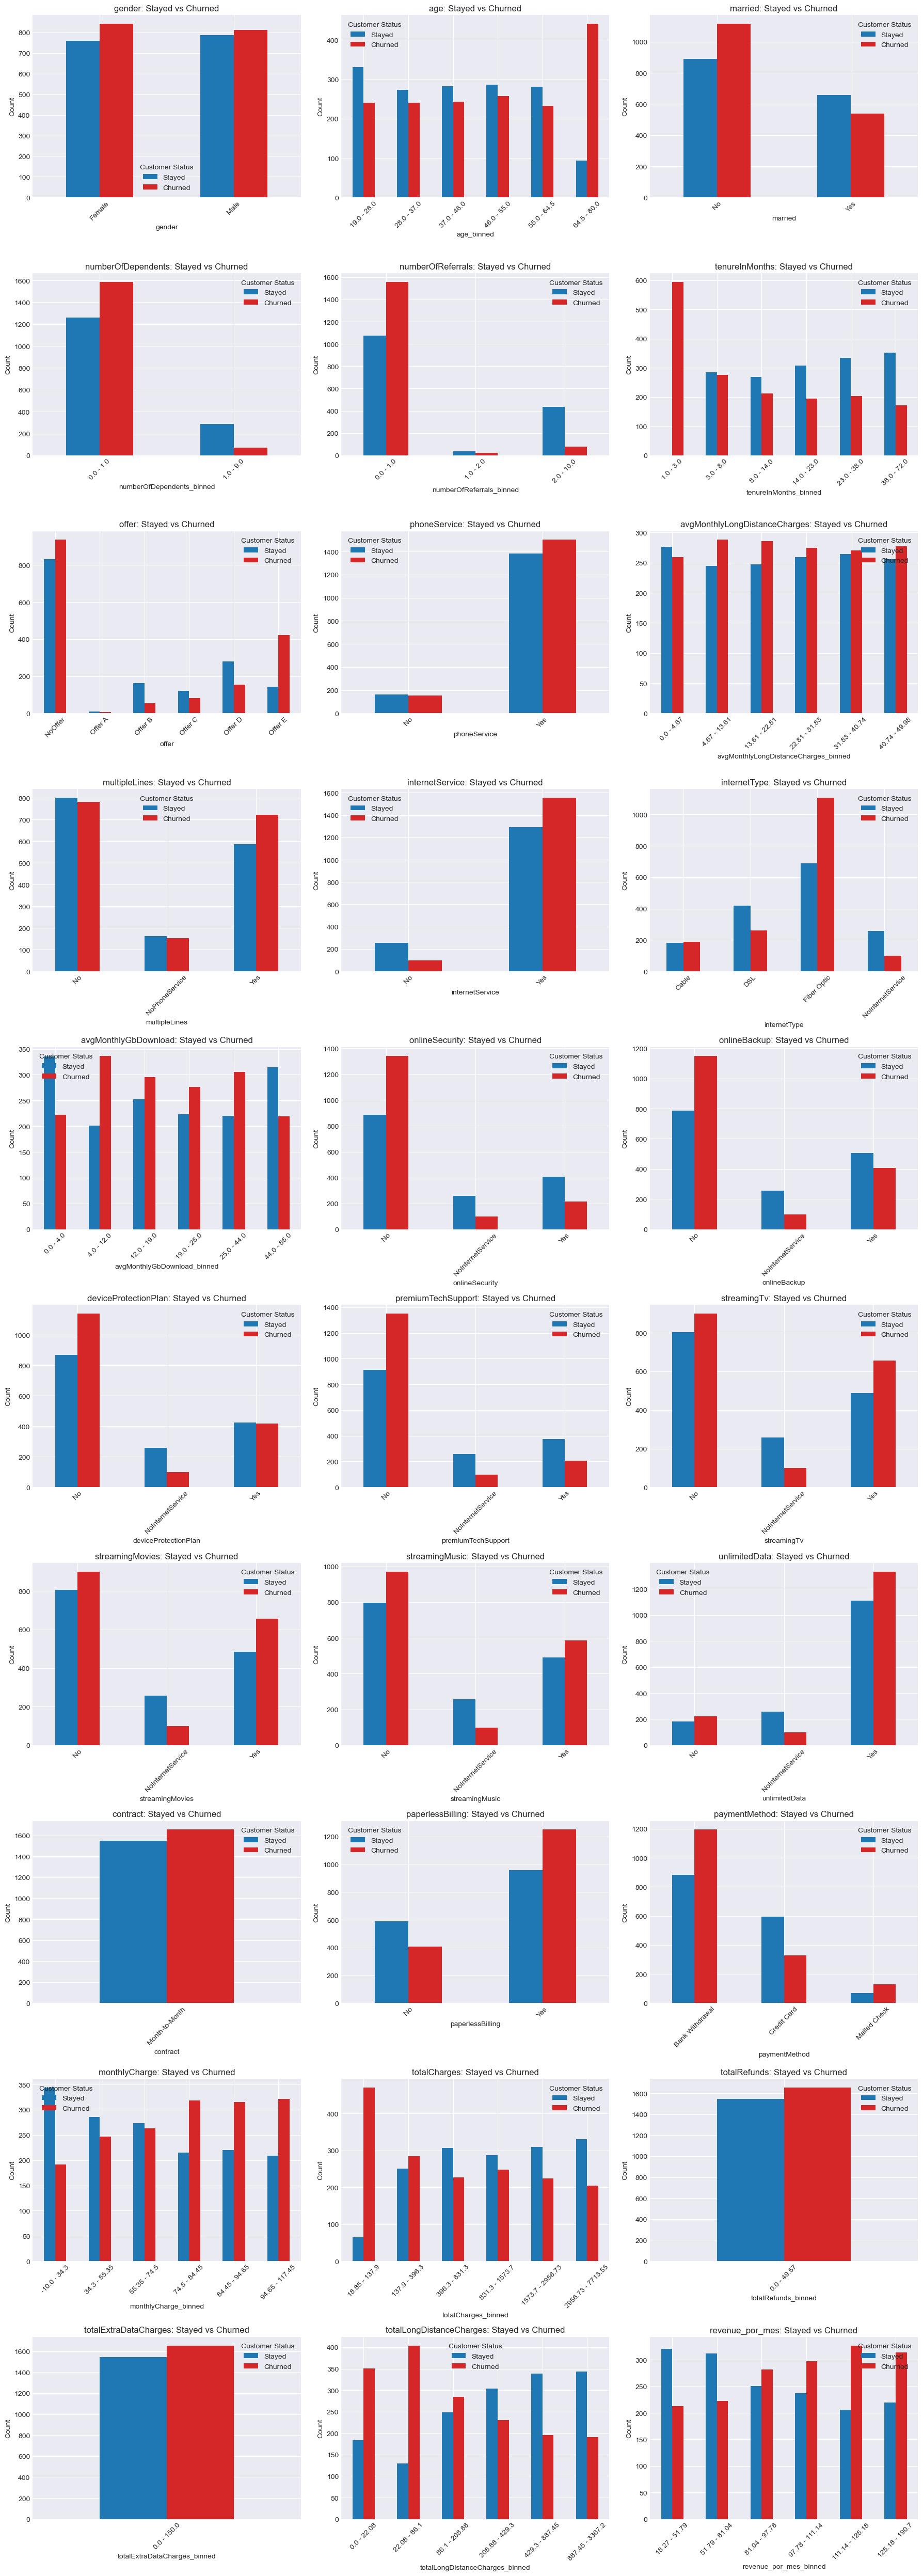

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer

# Para cada variable, graficar barras de "Stayed" vs "Churned"
status_labels = ['Stayed', 'Churned']
if 'customerStatus' in df_month_to_month.columns:
    # Asegurarse de que los valores estén en inglés y consistentes
    df_plot = df_month_to_month.copy()
    df_plot['customerStatus'] = df_plot['customerStatus'].replace({'NoChurn': 'Stayed', 'Churned': 'Churned', 'Stayed': 'Stayed', 'Joined': 'Joined'})
    # Solo considerar Stayed y Churned
    df_plot = df_plot[df_plot['customerStatus'].isin(['Stayed', 'Churned'])]
    variables_to_plot = [col for col in variables if col in df_plot.columns]
    n_vars = len(variables_to_plot)
    fig, axes = plt.subplots(nrows=(n_vars + 2) // 3, ncols=3, figsize=(18, 5*((n_vars + 2)//3)))
    axes = axes.flatten()
    for idx, col in enumerate(variables_to_plot):
        # Si la variable es numérica, agrupar en los mejores bins usando KBinsDiscretizer (quantile)
        if pd.api.types.is_numeric_dtype(df_plot[col]):
            # Determinar el número óptimo de bins (máximo 6, mínimo 3, según la cantidad de valores únicos)
            n_unique = df_plot[col].nunique()
            n_bins = min(max(3, min(6, n_unique)), n_unique)
            # Si hay suficientes valores únicos, discretizar
            if n_unique > 6:
                kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
                # KBinsDiscretizer espera 2D array
                binned = kbd.fit_transform(df_plot[[col]])
                # Etiquetas de los bins
                bin_edges = np.unique(np.percentile(df_plot[col].dropna(), np.linspace(0, 100, n_bins+1)))
                bin_labels = [f"{round(bin_edges[i],2)} - {round(bin_edges[i+1],2)}" for i in range(len(bin_edges)-1)]
                df_plot[f'{col}_binned'] = pd.cut(df_plot[col], bins=bin_edges, labels=bin_labels, include_lowest=True, duplicates='drop')
                plot_col = f'{col}_binned'
            else:
                plot_col = col
        else:
            plot_col = col

        counts = df_plot.groupby([plot_col, 'customerStatus']).size().unstack(fill_value=0)
        counts = counts[status_labels] if all(l in counts.columns for l in status_labels) else counts
        counts.plot(kind='bar', stacked=False, ax=axes[idx], color=['#1f77b4', '#d62728'])
        axes[idx].set_title(f'{col}: Stayed vs Churned')
        axes[idx].set_ylabel('Count')
        axes[idx].legend(title='Customer Status')
        axes[idx].tick_params(axis='x', rotation=45)
    # Eliminar ejes vacíos si hay
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

Frecuencia de clientes (Month-to-Month):
customerStatus
Stayed     1547
Churned    1655
Name: count, dtype: int64


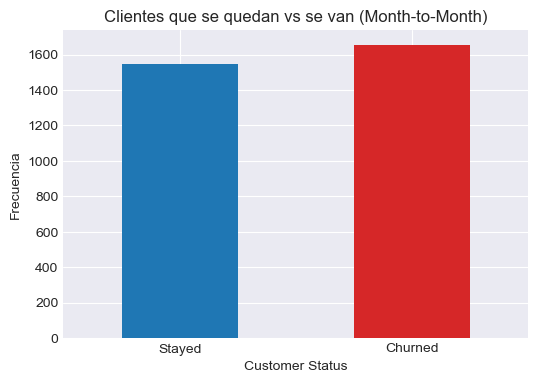

In [92]:
# Frecuencia de clientes que se quedan vs se van en contratos month-to-month
if 'customerStatus' in df_month_to_month.columns:
    status_counts = df_month_to_month['customerStatus'].replace({'NoChurn': 'Stayed', 'Churned': 'Churned', 'Stayed': 'Stayed', 'Joined': 'Joined'})
    # Solo considerar Stayed y Churned
    status_counts = status_counts[status_counts.isin(['Stayed', 'Churned'])]
    freq = status_counts.value_counts().reindex(['Stayed', 'Churned'])
    print("Frecuencia de clientes (Month-to-Month):")
    print(freq)
    # Gráfico de barras
    plt.figure(figsize=(6,4))
    freq.plot(kind='bar', color=['#1f77b4', '#d62728'])
    plt.title('Clientes que se quedan vs se van (Month-to-Month)')
    plt.xlabel('Customer Status')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=0)
    plt.show()


### Outliers en datos númericos utilizando el método IQ

Resumen de outliers por columna numérica (ordenado de mayor a menor por outliers):


,Columna,Outliers,Total,Porcentaje_Outliers
0,numberOfDependents,1627,7043,23.100951
1,totalExtraDataCharges,728,7043,10.336504
2,numberOfReferrals,676,7043,9.598183
3,totalRefunds,525,7043,7.454210
4,avgMonthlyGbDownload,362,7043,5.139855
5,totalLongDistanceCharges,196,7043,2.782905
6,totalRevenue,21,7043,0.298168
7,age,0,7043,0.000000
8,tenureInMonths,0,7043,0.000000
9,avgMonthlyLongDistanceCharges,0,7043,0.000000


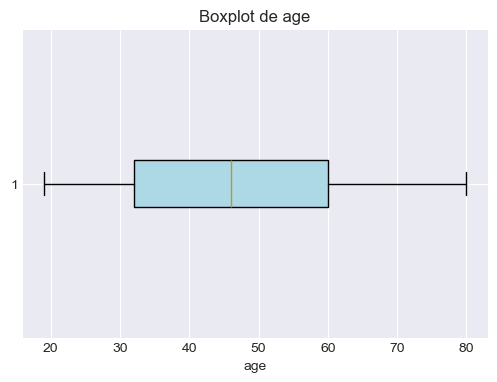

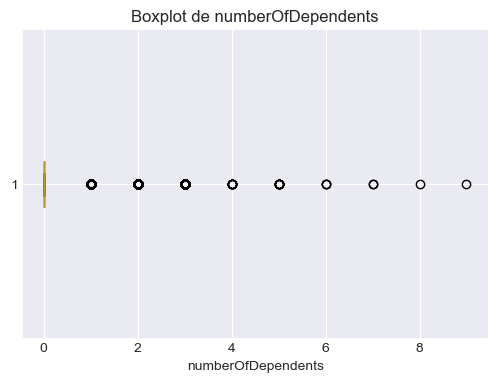

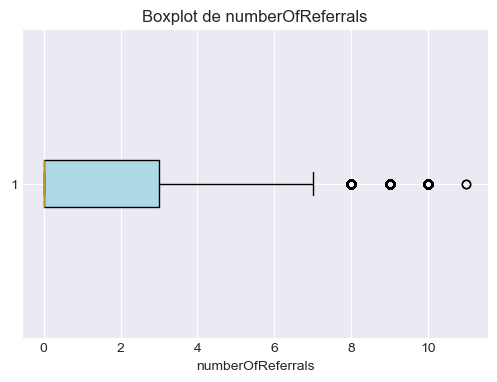

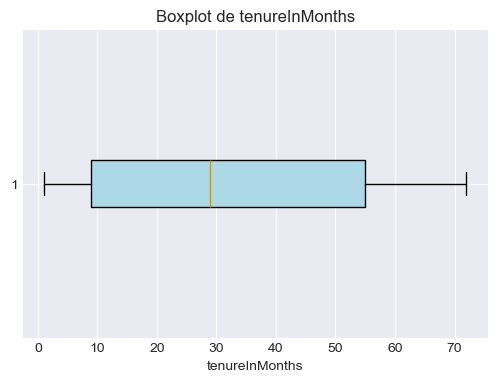

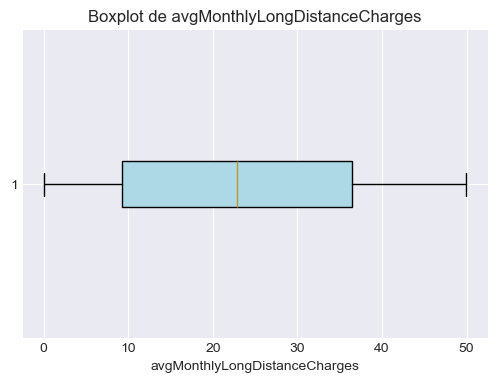

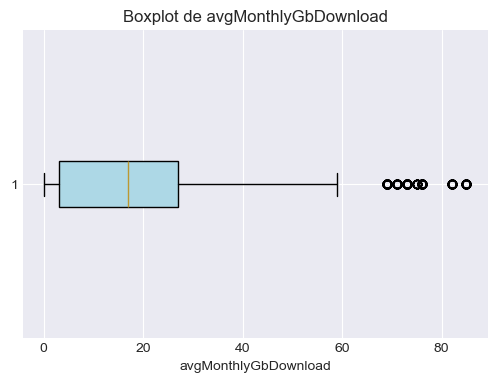

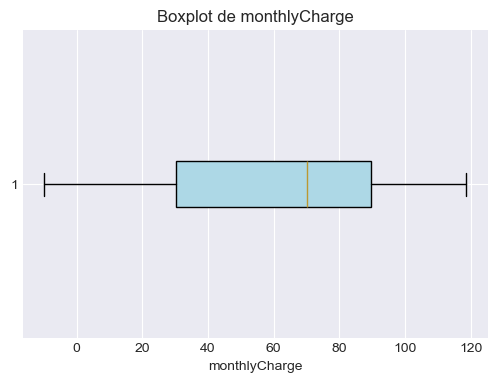

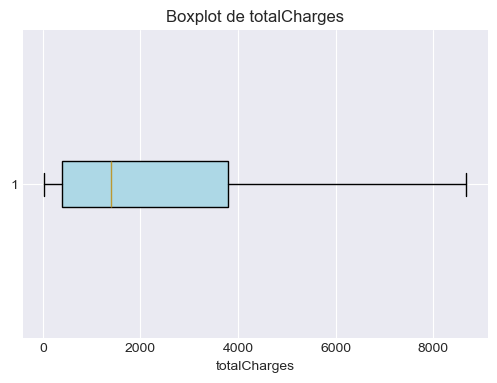

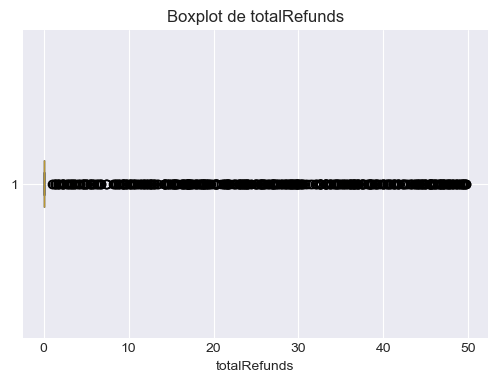

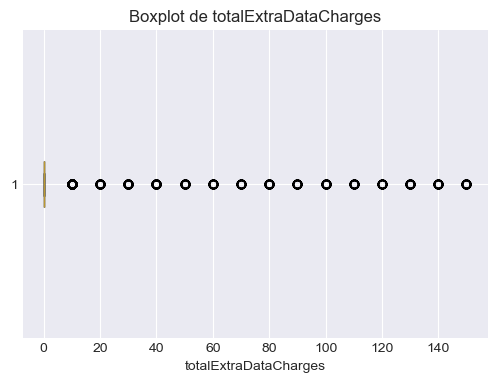

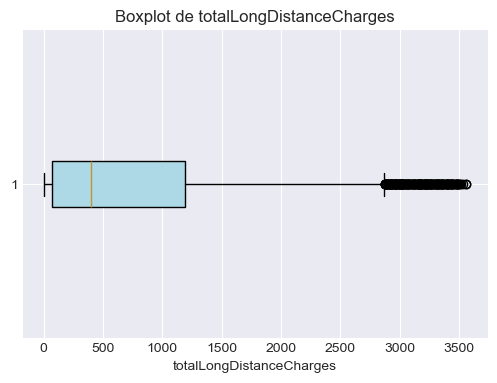

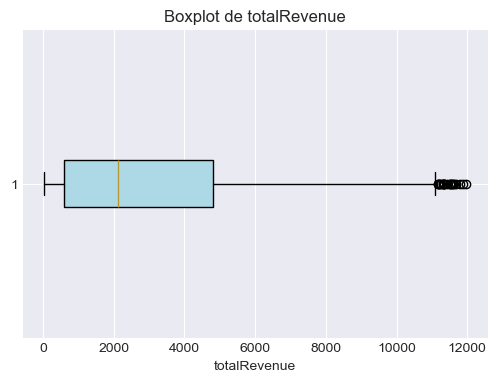

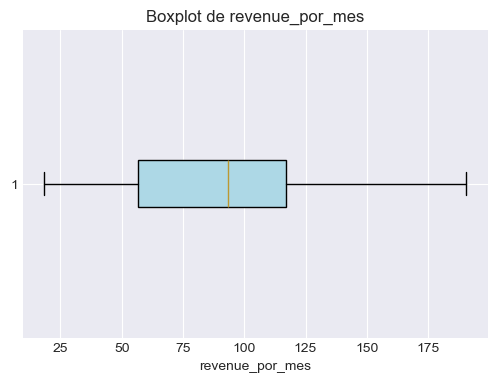

In [96]:
# Análisis de outliers en df_test_copy

# Usaremos el método del rango intercuartílico (IQR) para detectar outliers en las columnas numéricas

outlier_summary = []

for col in columnas_numericas:
    datos = df_test_copy[col].dropna()
    if len(datos) > 0:
        Q1 = datos.quantile(0.25)
        Q3 = datos.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = datos[(datos < lower_bound) | (datos > upper_bound)]
        outlier_count = outliers.count()
        total_count = datos.count()
        outlier_pct = (outlier_count / total_count) * 100 if total_count > 0 else 0
        outlier_summary.append({
            'Columna': col,
            'Outliers': outlier_count,
            'Total': total_count,
            'Porcentaje_Outliers': outlier_pct
        })

outlier_df = pd.DataFrame(outlier_summary)
# Ordenar de mayor a menor por cantidad de outliers
outlier_df = outlier_df.sort_values(by='Outliers', ascending=False).reset_index(drop=True)
print("Resumen de outliers por columna numérica (ordenado de mayor a menor por outliers):")
display(outlier_df)

# Visualización de outliers con boxplots
for col in columnas_numericas:
    datos = df_test_copy[col].dropna()
    if len(datos) > 0:
        plt.figure(figsize=(6, 4))
        plt.boxplot(datos, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
        plt.title(f'Boxplot de {col}')
        plt.xlabel(col)
        plt.show()


### Outlier en datos categóricos

Datos que representan menos del 5% del total, solo se observa en churn reason y churn category.



In [97]:
## outlier en datos categori
def detect_rare_categories(df, column, threshold=0.05):
    """
    Detecta categorías que aparecen menos del threshold% de las veces,
    excluyendo 'NoChurn' en churnCategory y churnReason.
    """
    value_counts = df[column].value_counts(normalize=True)
    # Excluir 'NoChurn' de los value_counts si corresponde
    if column in ['churnCategory', 'churnReason']:
        value_counts = value_counts.drop('NoChurn', errors='ignore')
    rare_categories = value_counts[value_counts < threshold].index.tolist()
    return rare_categories

# Aplicar la función detect_rare_categories a las columnas no numéricas en df
rare_cats_results = []

for col in columnas_no_numericas:
    rare_categories = detect_rare_categories(df_test_copy, col)
    for cat in rare_categories:
        # Excluir 'NoChurn' en churnCategory y churnReason
        if (col in ['churnCategory', 'churnReason']) and cat == 'NoChurn':
            continue
        count = df_test_copy[col].value_counts().get(cat, 0)  # cuenta cuantas veces aparece la categoria en la columna
        pct = df_test_copy[col].value_counts(normalize=True).get(cat, 0) * 100  # porcentaje de veces que aparece la categoria en la columna
        rare_cats_results.append({
            'columna': col,
            'categoria': cat,
            'conteo': count,
            'porcentaje': pct
        })

df_rare_cats = pd.DataFrame(rare_cats_results)
print("Resumen de categorías raras encontradas en columnas no numéricas (excluyendo 'NoChurn' en churnCategory y churnReason):")
df_rare_cats



Resumen de categorías raras encontradas en columnas no numéricas (excluyendo 'NoChurn' en churnCategory y churnReason):


,columna,categoria,conteo,porcentaje
0,churnCategory,Dissatisfaction,321,4.557717
1,churnCategory,Attitude,314,4.458327
2,churnCategory,Price,211,2.995882
3,churnCategory,Other,182,2.584126
4,churnReason,Competitor had better devices,313,4.444129
5,churnReason,Competitor made better offer,311,4.415732
6,churnReason,Attitude of support person,220,3.123669
7,churnReason,Don't know,130,1.845804
8,churnReason,Competitor offered more data,117,1.661224
9,churnReason,Competitor offered higher download speeds,100,1.419849


### De Todas las varibles con Mutual Information Normalizada


Matriz de mutual information normalizado entre todas las variables:


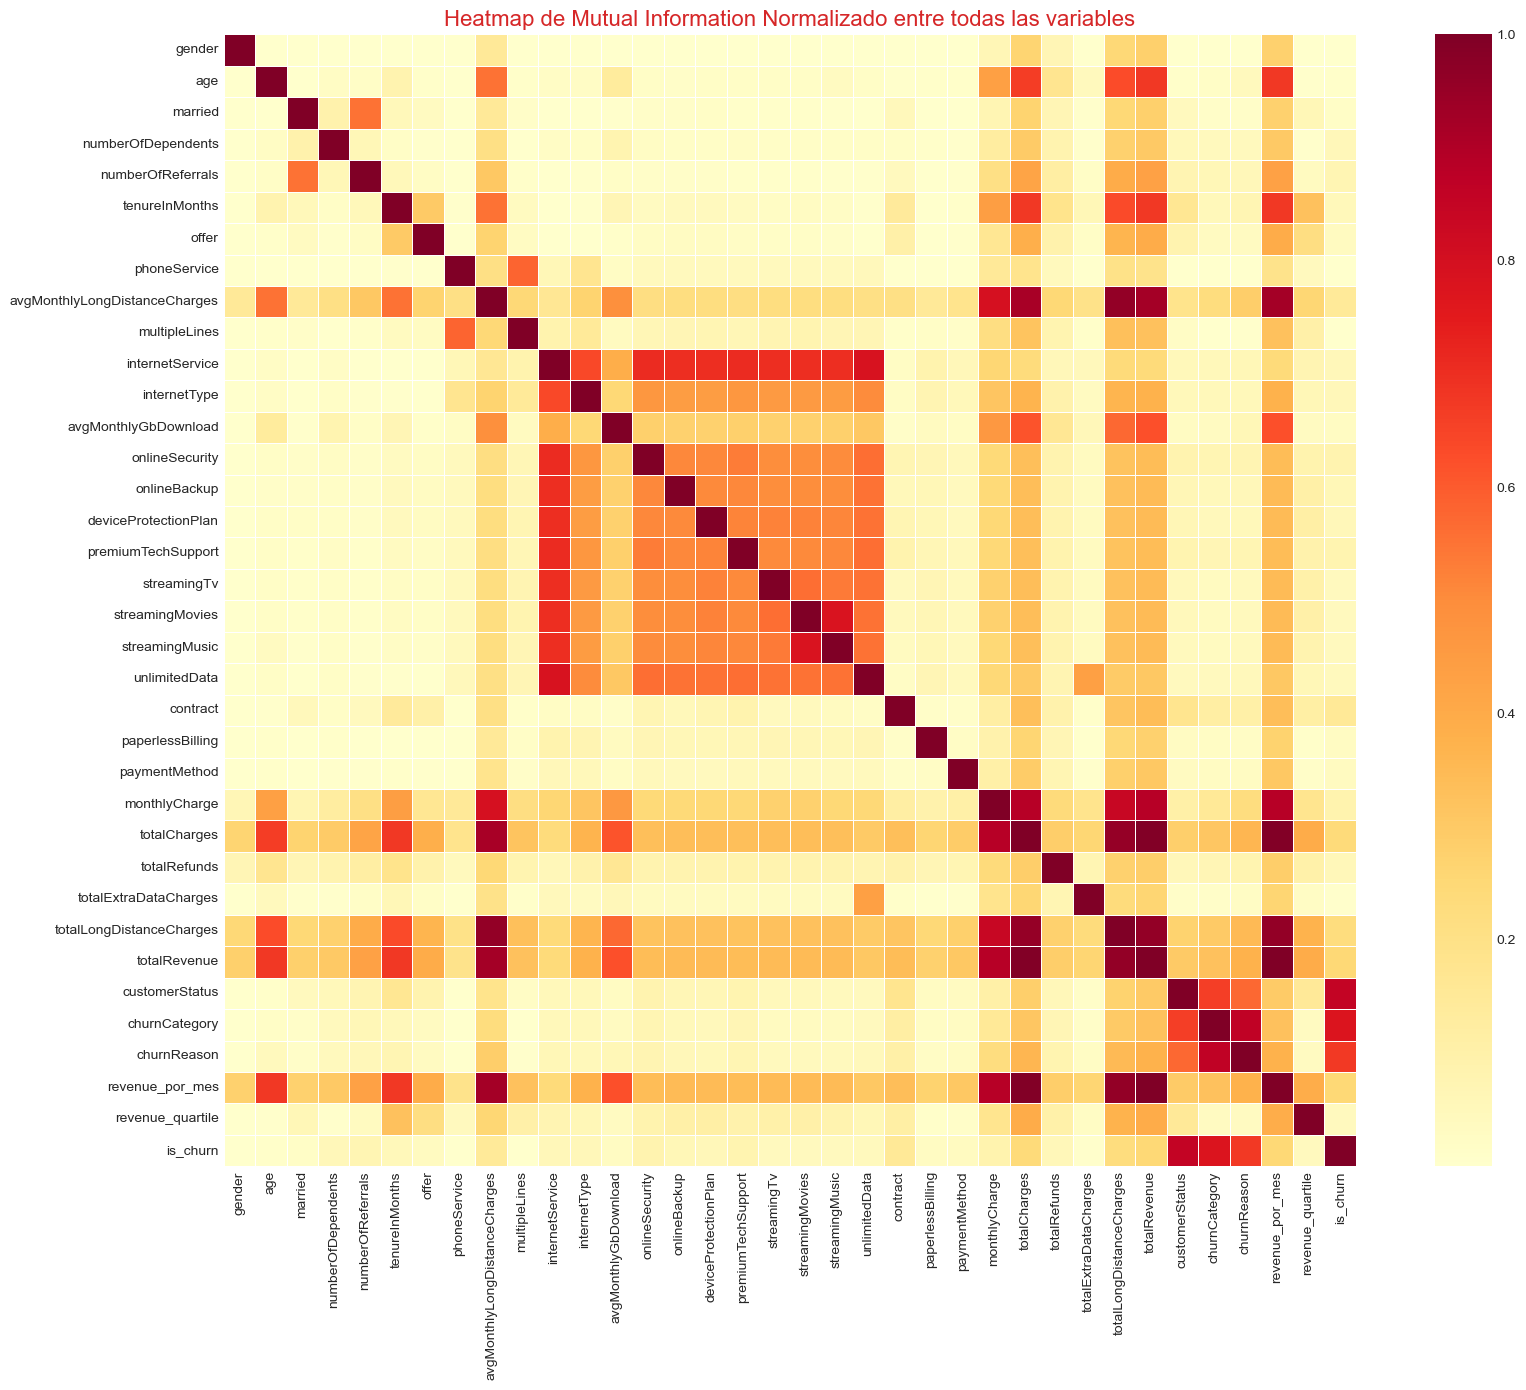

Pares de variables con MI normalizado >= 0.7:


,Variable_1,Variable_2,MI_normalizado
0,totalRevenue,revenue_por_mes,0.998940
1,totalCharges,totalRevenue,0.992862
2,totalCharges,revenue_por_mes,0.992592
3,totalLongDistanceCharges,totalRevenue,0.959597
4,totalLongDistanceCharges,revenue_por_mes,0.959448
5,avgMonthlyLongDistanceCharges,totalLongDistanceCharges,0.958562
6,totalCharges,totalLongDistanceCharges,0.953184
7,avgMonthlyLongDistanceCharges,totalRevenue,0.925014
8,avgMonthlyLongDistanceCharges,revenue_por_mes,0.924841
9,avgMonthlyLongDistanceCharges,totalCharges,0.917953


In [108]:
#calcular mutual information
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# Calcular el mutual information normalizado para todas las variables de df_test_copy

# 1. Preparar los datos: codificar variables categóricas
df_mi = df_test_copy.copy()
le_dict = {}
for col in df_mi.columns:
    if df_mi[col].dtype == 'object' or df_mi[col].dtype.name == 'category':
        le = LabelEncoder()
        df_mi[col] = df_mi[col].astype(str).fillna('MISSING')
        df_mi[col] = le.fit_transform(df_mi[col])
        le_dict[col] = le

# 2. Calcular el mutual information normalizado para cada variable respecto a todas las demás
from sklearn.metrics import mutual_info_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

mi_matrix = pd.DataFrame(index=df_mi.columns, columns=df_mi.columns, dtype=float)

for i, col1 in enumerate(df_mi.columns):
    for j, col2 in enumerate(df_mi.columns):
        if col1 == col2:
            mi_matrix.loc[col1, col2] = 1.0
        else:
            x = df_mi[col1]
            y = df_mi[col2]
            mi = mutual_info_score(x, y)
            # Normalización: dividir por la raíz del producto de las entropías
            h_x = mutual_info_score(x, x)
            h_y = mutual_info_score(y, y)
            if h_x > 0 and h_y > 0:
                mi_norm = mi / np.sqrt(h_x * h_y)
            else:
                mi_norm = 0
            mi_matrix.loc[col1, col2] = mi_norm

print("Matriz de mutual information normalizado entre todas las variables:")
plt.figure(figsize=(18, 14))
sns.heatmap(mi_matrix.astype(float), annot=False, cmap='YlOrRd', cbar=True, square=True, linewidths=0.5)
plt.title("Heatmap de Mutual Information Normalizado entre todas las variables", fontsize=16, color='#d62728')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Mostrar en un dataframe las correlaciones con mi normalizado >= 0.7 (sin duplicados ni la diagonal)
mi_pairs = []
for i, col1 in enumerate(df_mi.columns):
    for j, col2 in enumerate(df_mi.columns):
        if i < j:  # Solo una vez cada par, sin diagonal
            mi_value = mi_matrix.loc[col1, col2]
            if mi_value >= 0.7:
                mi_pairs.append({'Variable_1': col1, 'Variable_2': col2, 'MI_normalizado': mi_value})

df_mi_high = pd.DataFrame(mi_pairs).sort_values(by='MI_normalizado', ascending=False).reset_index(drop=True)
print("Pares de variables con MI normalizado >= 0.7:")
display(df_mi_high)


### De variables númmericas

Donde se observa una alta correlación entre totalCharges y	totalRevenue. Asismo, se obverva que mientras más tiempo me quedo, más recargo tototales se tiene. Se ve la importancia de las Variables mas estandarizadas ya que ayudan a comparar  mejor. Por ejemplo, MonthCharge, que es el promedio de consumo en el mes, permite comparar mejor que las totalizadas.

In [109]:
# Análisis de correlación
# Calculamos la matriz de correlación para las columnas numéricas
correlation_matrix = df_test_copy[columnas_numericas].corr().abs()

# Seleccionamos solo la parte superior de la matriz (sin la diagonal)
correlation_pairs = (
    correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    .stack()
    .reset_index()
)
correlation_pairs.columns = ['Variable_1', 'Variable_2', 'Correlacion']

# Filtramos las combinaciones con correlación mayor a 0.20
correlation_pairs_filtradas = correlation_pairs[correlation_pairs['Correlacion'] > 0.20]

# Ordenamos de mayor a menor correlación
correlation_pairs_filtradas = correlation_pairs_filtradas.sort_values(by='Correlacion', ascending=False).reset_index(drop=True)

print("Combinaciones de variables numéricas con correlación mayor a 0.20:")
display(correlation_pairs_filtradas)


Combinaciones de variables numéricas con correlación mayor a 0.20:


,Variable_1,Variable_2,Correlacion
0,totalCharges,totalRevenue,0.972212
1,monthlyCharge,revenue_por_mes,0.853192
2,tenureInMonths,totalRevenue,0.853146
3,tenureInMonths,totalCharges,0.826074
4,totalLongDistanceCharges,totalRevenue,0.778559
5,tenureInMonths,totalLongDistanceCharges,0.674149
6,monthlyCharge,totalCharges,0.622810
7,totalCharges,totalLongDistanceCharges,0.610185
8,avgMonthlyLongDistanceCharges,totalLongDistanceCharges,0.599828
9,totalRevenue,revenue_por_mes,0.588326


En el analísis de las categóricas se observa una relación entra las variables que indica que si contratan internet y los servicios adicionales.


In [110]:
# Medir la correlación entre variables no numéricas usando Cramér's V

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] == 1 or confusion_matrix.shape[1] == 1:
        return np.nan  # No se puede calcular Cramér's V con una sola categoría
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Corrección de bias para tablas no cuadradas
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Crear matriz de correlación para variables no numéricas
cat_cols = columnas_no_numericas
cramers_results = []

for col1, col2 in itertools.combinations(cat_cols, 2):
    v = cramers_v(df_test_copy[col1], df_test_copy[col2])
    cramers_results.append({
        'Variable_1': col1,
        'Variable_2': col2,
        "Cramers_V": v
    })

df_cramers = pd.DataFrame(cramers_results)
df_cramers_filtrada = df_cramers[df_cramers['Cramers_V'] > 0.70].sort_values(by='Cramers_V', ascending=False).reset_index(drop=True)

print("Combinaciones de variables no numéricas con Cramér's V mayor a 0.20:")
pd.set_option('display.max_rows', None)
display(df_cramers_filtrada.sort_values(by='Cramers_V', ascending=False).reset_index(drop=True))


Combinaciones de variables no numéricas con Cramér's V mayor a 0.20:


,Variable_1,Variable_2,Cramers_V
0,internetService,deviceProtectionPlan,0.999929
1,internetService,streamingMovies,0.999929
2,internetService,onlineBackup,0.999929
3,internetService,streamingTv,0.999929
4,internetService,premiumTechSupport,0.999929
5,internetService,unlimitedData,0.999929
6,internetService,streamingMusic,0.999929
7,phoneService,multipleLines,0.999929
8,internetService,onlineSecurity,0.999929
9,internetService,internetType,0.999858


In [118]:
""" variables_a_eliminar = [
   # Grupo 1: Servicios de Internet Redundantes (correlacionados con internetService)
   'streamingTv',
   'premiumTechSupport', 
   'streamingMovies',
   'unlimitedData',
   'deviceProtectionPlan',
   'onlineBackup',
   'streamingMusic',
   'onlineSecurity',
   'avgMonthlyGbDownload',
   'avgMonthlyLongDistanceCharges',
   
   # Grupo 2: Variables de Teléfono Redundantes
   'multipleLines',  # correlacionado con phoneService
   
   # Grupo 3: Variables de Churn Redundantes  
   'churnReason',
   'churnCategory'     # correlacionado con churnCategory
] """

" variables_a_eliminar = [\n   # Grupo 1: Servicios de Internet Redundantes (correlacionados con internetService)\n   'streamingTv',\n   'premiumTechSupport', \n   'streamingMovies',\n   'unlimitedData',\n   'deviceProtectionPlan',\n   'onlineBackup',\n   'streamingMusic',\n   'onlineSecurity',\n   'avgMonthlyGbDownload',\n   'avgMonthlyLongDistanceCharges',\n   \n   # Grupo 2: Variables de Teléfono Redundantes\n   'multipleLines',  # correlacionado con phoneService\n   \n   # Grupo 3: Variables de Churn Redundantes  \n   'churnReason',\n   'churnCategory'     # correlacionado con churnCategory\n] "

### Analísis entre la variable Y y las X

Analísis predictor vs objetivo, para ver como relacionan es sacar graficas pintadas, como se relaciona la edad como se vaya y como no se vaya. Y asumir a los Stay y a los Joined como una sola categoria 

In [111]:
df_test_copy.head(5)

,gender,age,married,numberOfDependents,numberOfReferrals,tenureInMonths,offer,phoneService,avgMonthlyLongDistanceCharges,multipleLines,...,totalRefunds,totalExtraDataCharges,totalLongDistanceCharges,totalRevenue,customerStatus,churnCategory,churnReason,revenue_por_mes,revenue_quartile,is_churn
0,Female,37,Yes,0,2,9,NoOffer,Yes,42.39,No,...,0.00,0,381.51,974.81,Stayed,NoChurn,NoChurn,108.312222,Q2,0
1,Male,46,No,0,0,9,NoOffer,Yes,10.69,Yes,...,38.33,10,96.21,610.28,Stayed,NoChurn,NoChurn,67.808889,Q2,0
2,Male,50,No,0,0,4,Offer E,Yes,33.65,No,...,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices,103.862500,Q1,1
3,Male,78,Yes,0,1,13,Offer D,Yes,27.82,No,...,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction,123.039231,Q2,1
4,Female,75,Yes,0,3,3,NoOffer,Yes,7.38,No,...,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability,96.513333,Q1,1


In [132]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, kruskal
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

def cramers_v_simple(x, y):
    """
    Calcula Cramér's V entre dos variables categóricas - versión simplificada
    """
    try:
        # Crear tabla de contingencia
        crosstab = pd.crosstab(x, y)
        
        # Calcular chi-cuadrado
        chi2, p, dof, expected = chi2_contingency(crosstab)
        
        # Calcular Cramér's V
        n = crosstab.sum().sum()
        cramer = np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
        
        return cramer
    except:
        return 0

def eta_squared_simple(numeric_var, categorical_var):
    """
    Calcula Eta-squared usando test de Kruskal-Wallis - versión simplificada
    """
    try:
        # Crear DataFrame temporal
        df_temp = pd.DataFrame({'num': numeric_var, 'cat': categorical_var}).dropna()
        
        if len(df_temp) < 10:
            return 0
            
        # Agrupar por categoría
        groups = [group['num'].values for name, group in df_temp.groupby('cat')]
        
        if len(groups) <= 1:
            return 0
            
        # Test de Kruskal-Wallis
        h_stat, p_value = kruskal(*groups)
        
        # Calcular eta-squared aproximado
        n = len(df_temp)
        k = len(groups)
        eta_squared = (h_stat - k + 1) / (n - k)
        
        return max(0, min(1, eta_squared))
    except:
        return 0

def mutual_info_simple(variable, target, is_numeric=True):
    """
    Calcula Información Mutua Normalizada - versión simplificada
    """
    try:
        from scipy.stats import entropy
        
        # Crear DataFrame temporal sin NaN
        if is_numeric:
            df_temp = pd.DataFrame({'var': variable, 'target': target}).dropna()
        else:
            df_temp = pd.DataFrame({'var': variable.astype(str), 'target': target.astype(str)}).dropna()
        
        if len(df_temp) < 10:
            return 0
        
        # Codificar target
        le_target = LabelEncoder()
        y_encoded = le_target.fit_transform(df_temp['target'])
        
        if is_numeric:
            # Para numéricas: usar la variable directamente
            X = df_temp['var'].values.reshape(-1, 1)
        else:
            # Para categóricas: codificar
            le_var = LabelEncoder()
            X = le_var.fit_transform(df_temp['var']).reshape(-1, 1)
        
        # Calcular MI
        mi = mutual_info_classif(X, y_encoded, random_state=42)[0]
        
        # Normalizar por entropía del target
        _, counts_y = np.unique(y_encoded, return_counts=True)
        entropy_y = entropy(counts_y / len(y_encoded), base=2)
        
        if entropy_y > 0:
            return mi / entropy_y
        else:
            return 0
            
    except Exception as e:
        print(f"    Error en MI: {e}")
        return 0

def crear_bins_seguros(data, n_bins=4):
    """
    Crea bins de forma segura para variables numéricas
    """
    try:
        # Remover NaN
        clean_data = data.dropna()
        
        if len(clean_data) == 0:
            return None
            
        # Obtener valores únicos
        unique_vals = clean_data.unique()
        
        if len(unique_vals) <= 2:
            # Si hay muy pocos valores únicos, usar como categórica
            return clean_data.astype(str)
        elif len(unique_vals) <= n_bins:
            # Si hay pocos valores únicos, usar cada uno como bin
            return clean_data.astype(str)
        else:
            # Crear bins por percentiles
            try:
                # Intentar percentiles uniformes
                percentiles = np.linspace(0, 100, n_bins + 1)
                bin_edges = np.percentile(clean_data, percentiles)
                
                # Asegurar que los edges sean únicos
                bin_edges = np.unique(bin_edges)
                
                if len(bin_edges) >= 2:
                    return pd.cut(clean_data, bins=bin_edges, duplicates='drop', include_lowest=True)
                else:
                    return clean_data.astype(str)
            except:
                # Si todo falla, convertir a string
                return clean_data.astype(str)
                
    except:
        return None



In [133]:

# Identificar variables a analizar
excluir = ['customerid', 'customerStatus','churnReason','churnCategory']
todas_columnas = [col for col in df_test_copy.columns if col not in excluir]

# Separar por tipo
numericas = [col for col in todas_columnas 
                 if df_test_copy[col].dtype in ['int64', 'float64', 'int32', 'float32']]
    
categoricas = [col for col in todas_columnas 
                   if col not in numericas]
    
print(f"\n📊 Variables a analizar:")
print(f"   Numéricas: {len(numericas)}")
print(f"   Categóricas: {len(categoricas)}")


#display(todas_columnas)



📊 Variables a analizar:
   Numéricas: 12
   Categóricas: 18


In [ ]:
# Lista de resultados
#utiliza numericas y categoricas para recorrer pero asigna como target dentro del codigo la variable customerStatus
resultados = []

for col in numericas:
    try:
        # Obtener datos limpios
        mask = df_test_copy[col].notna() & df_test_copy['customerStatus'].notna()
        data_num = df_test_copy.loc[mask, col]
        data_target = df_test_copy.loc[mask, 'customerStatus']
        cramers = 0
        
        # 2. Eta-squared
        eta_sq = eta_squared_simple(data_num, data_target)
        
        # 1. Cramér's V (requiere discretización)
        bins_data = crear_bins_seguros(data_num)
        if bins_data is not None:
            cramers = cramers_v_simple(bins_data, data_target)
        else:
            cramers = 0
        
        # 2. Eta-squared
        eta_sq = eta_squared_simple(data_num, data_target)
        
        # 3. MI Normalizada


        mi_norm = mutual_info_simple(data_num, data_target, is_numeric=True)
        
        # Guardar resultado
        resultados.append({
            'Variable': col,
            'Tipo': 'Numérica',
            'Cramers_V': round(cramers, 6),
            'Eta_Squared_Kruskal': round(eta_sq, 6),
            'MI_Normalizada': round(mi_norm, 6)
        })         
    except Exception as e:
        print(f"  Error: {str(e)[:50]}...")
        resultados.append({
            'Variable': col,
            'Tipo': 'Numérica',
            'Cramers_V': 0,
            'Eta_Squared_Kruskal': 0,
            'MI_Normalizada': 0
        })

# Procesar VARIABLES CATEGÓRICAS 

for col in categoricas:
    try:
        # Obtener datos limpios
        mask = df_test_copy[col].notna() & df_test_copy['customerStatus'].notna()
        data_cat = df_test_copy.loc[mask, col]
        data_target = df_test_copy.loc[mask, 'customerStatus']
        
        if len(data_cat) < 10:
            print(f" Pocos datos válidos ({len(data_cat)})")
            continue
        
        #print(f"  Datos válidos: {len(data_cat)}")
        #print(f"  Categorías únicas: {data_cat.nunique()}")
        
        # Calcular métricas
        # 1. Cramér's V
        cramers = cramers_v_simple(data_cat, data_target)
        
        # 2. Eta-squared (No aplica para cat vs cat)
        eta_sq = 0
        
        # 3. MI Normalizada
        mi_norm = mutual_info_simple(data_cat, data_target, is_numeric=False)
        
        # Guardar resultado
        resultados.append({
            'Variable': col,
            'Tipo': 'Categórica',
            'Cramers_V': round(cramers, 6),
            'Eta_Squared_Kruskal': round(eta_sq, 6),
            'MI_Normalizada': round(mi_norm, 6)
        })       
    except Exception as e:
        print(f"Error: {str(e)[:50]}...")
        resultados.append({
            'Variable': col,
            'Tipo': 'Categórica',
            'Cramers_V': 0,
            'Eta_Squared_Kruskal': 0,
            'MI_Normalizada': 0
        })

# RESULTADOS FINALES

df_correlaciones = pd.DataFrame(resultados)
df_correlaciones = df_correlaciones.sort_values('MI_Normalizada', ascending=False)
df_correlaciones = df_correlaciones.reset_index(drop=True)

print(f"\n{'='*80}")
print("🎯 CORRELACIONES CON customerStatus (ordenado por MI Normalizada)")
print(f"{'='*80}")
print(df_correlaciones.to_string(index=False))
    



🎯 CORRELACIONES CON customerStatus (ordenado por MI Normalizada)
                     Variable       Tipo  Cramers_V  Eta_Squared_Kruskal  MI_Normalizada
               tenureInMonths   Numérica   0.433111             0.334386        0.253746
                 totalRevenue   Numérica   0.401611             0.257076        0.186753
                 totalCharges   Numérica   0.388763             0.238338        0.185372
     totalLongDistanceCharges   Numérica   0.331482             0.170598        0.152507
                     contract Categórica   0.375617             0.000000        0.134762
            numberOfReferrals   Numérica   0.311806             0.082667        0.081701
                        offer Categórica   0.282891             0.000000        0.074671
               onlineSecurity Categórica   0.265337             0.000000        0.070076
           premiumTechSupport Categórica   0.262224             0.000000        0.065220
                monthlyCharge   Numérica   0

In [138]:
df_test_copy.head(2)

,gender,age,married,numberOfDependents,numberOfReferrals,tenureInMonths,offer,phoneService,avgMonthlyLongDistanceCharges,multipleLines,...,paymentMethod,monthlyCharge,totalCharges,totalRefunds,totalExtraDataCharges,totalLongDistanceCharges,totalRevenue,customerStatus,churnCategory,churnReason
0,Female,37,Yes,0,2,9,NoOffer,Yes,42.39,No,...,Credit Card,65.6,593.3,0.00,0,381.51,974.81,Stayed,NoChurn,NoChurn
1,Male,46,No,0,0,9,NoOffer,Yes,10.69,Yes,...,Credit Card,-4.0,542.4,38.33,10,96.21,610.28,Stayed,NoChurn,NoChurn


In [126]:
##varibales eliinar
#eliminar = ['churnCategory','churnReason','totalCharges', 'totalRefunds', 'totalExtraDataCharges','totalLongDistanceCharges', 'totalRevenue']
#eliminar = ['churnCategory','churnReason','totalCharges', 'totalRefunds', 'totalExtraDataCharges','totalLongDistanceCharges']
eliminar = ['churnCategory','churnReason', 'totalRevenue']

# Eliminar las variables indicadas en la lista 'eliminar' de dfX si existen
dfX = dfX.drop(columns=[col for col in eliminar if col in dfX.columns])

dfX.columns


Index(['gender', 'age', 'married', 'numberOfDependents', 'numberOfReferrals',
       'tenureInMonths', 'offer', 'phoneService',
       'avgMonthlyLongDistanceCharges', 'multipleLines', 'internetService',
       'internetType', 'avgMonthlyGbDownload', 'onlineSecurity',
       'onlineBackup', 'deviceProtectionPlan', 'premiumTechSupport',
       'streamingTv', 'streamingMovies', 'streamingMusic', 'unlimitedData',
       'contract', 'paperlessBilling', 'paymentMethod', 'monthlyCharge',
       'totalCharges', 'totalRefunds', 'totalExtraDataCharges',
       'totalLongDistanceCharges', 'revenue_por_mes'],
      dtype='object')

In [127]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Asegurarse de que dfX y dfy estén alineados y sin valores nulos
X_mi = dfX.copy()
y_mi = dfy.copy()
X_mi = X_mi.loc[y_mi.index]


# Si hay variables categóricas, conviértelas a numéricas (one-hot)
X_mi_encoded = pd.get_dummies(X_mi, drop_first=True)

# Calcular la MI normalizada
mi = mutual_info_classif(X_mi_encoded, y_mi, discrete_features='auto', random_state=42)
mi_normalizada = mi / mi.max()

# Crear un DataFrame ordenado con los resultados
mi_df = pd.DataFrame({
    'Variable': X_mi_encoded.columns,
    'MI_normalizada': mi_normalizada
}).sort_values(by='MI_normalizada', ascending=False).reset_index(drop=True)

print(mi_df)


                                  Variable  MI_normalizada
0                           tenureInMonths        1.000000
1                             totalCharges        0.564870
2                        contract_Two Year        0.554832
3                 totalLongDistanceCharges        0.517021
4                        numberOfReferrals        0.461634
5                       numberOfDependents        0.287483
6                            monthlyCharge        0.284538
7     premiumTechSupport_NoInternetService        0.268773
8         onlineSecurity_NoInternetService        0.241498
9                      internetService_Yes        0.233914
10           streamingTv_NoInternetService        0.231406
11                           offer_Offer E        0.227768
12       streamingMovies_NoInternetService        0.223360
13                internetType_Fiber Optic        0.222105
14                    avgMonthlyGbDownload        0.216851
15  deviceProtectionPlan_NoInternetService        0.1940

### Generar una regresion logaritmica para clasificar con ml


### Regresion lineal

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')


def churnRegresion(dfX):

    dfy = dfX[['customerStatus']].copy()
    X_mi = dfX.copy()
    y_mi = dfy.copy()

    ### Phone service indice
    # 1. Convertir phoneService a valores numéricos
    X_mi['phone_numeric'] = X_mi['phoneService'].map({'Yes': 1, 'No': 0, 'NoPhoneService': 0})

    # 2. Normalizar avgMonthlyLongDistanceCharges (0-1)
    X_mi['charges_normalized'] = X_mi['avgMonthlyLongDistanceCharges'] / X_mi['avgMonthlyLongDistanceCharges'].max()

    # 3. Convertir multipleLines a valores numéricos
    X_mi['multiple_numeric'] = X_mi['multipleLines'].map({'Yes': 1, 'No': 0, 'NoPhoneService': 0})

    # 4. Crear el índice con pesos
    X_mi['index_phone_service'] = (
        X_mi['phone_numeric']  + 
        X_mi['charges_normalized']  + 
        X_mi['multiple_numeric'] 
    )

    X_mi = X_mi.drop(['phone_numeric', 'charges_normalized', 'multiple_numeric','phoneService','avgMonthlyLongDistanceCharges','multipleLines'], axis=1)

    ### Seguridad
    X_mi['onlineSecurity'] = X_mi['onlineSecurity'].map({'Yes': 1, 'No': 0, 'NoInternetService': 0})
    X_mi['onlineBackup'] = X_mi['onlineBackup'].map({'Yes': 1, 'No': 0, 'NoInternetService': 0})
    X_mi['deviceProtectionPlan'] = X_mi['deviceProtectionPlan'].map({'Yes': 1, 'No': 0, 'NoInternetService': 0})

    X_mi['index_security'] = (
        X_mi['onlineSecurity']  + 
        X_mi['onlineBackup']  + 
        X_mi['deviceProtectionPlan'] 
    )


    ### uso
    X_mi['streamingTv'] = X_mi['streamingTv'].map({'Yes': 1, 'No': 0, 'NoInternetService': 0})
    X_mi['streamingMovies'] = X_mi['streamingMovies'].map({'Yes': 1, 'No': 0, 'NoInternetService': 0})
    X_mi['streamingMusic'] = X_mi['streamingMusic'].map({'Yes': 1, 'No': 0, 'NoInternetService': 0})

    X_mi['index_streaming'] = (
        X_mi['streamingTv']  + 
        X_mi['streamingMovies']  + 
        X_mi['streamingMusic'] 
    )


    ### 'unlimitedData'
    ### 'premiumTechSupport'
    ### 'paperlessBilling', 'paymentMethod'
    X_mi = X_mi.drop(['onlineSecurity', 'onlineBackup', 'deviceProtectionPlan'], axis=1)

    X_mi = X_mi.drop(['streamingTv', 'streamingMovies', 'streamingMusic','streamingTv','streamingMovies','streamingMusic'], axis=1)
    X_mi = X_mi.drop(['customerStatus'], axis=1)

    y_mi['customerStatus'] = y_mi['customerStatus'].map({'Churned': 1, 'Stayed': 0})
    ###aplicar logaritmos

    ##evitar coleanilida
    X_mi_encoded = pd.get_dummies(X_mi, drop_first=True)

    print("\n=== DIVISIÓN DE DATOS ===")

    # Primera división: 60% train, 40% restante
    X_train, X_test, y_train, y_test = train_test_split(
        X_mi_encoded, y_mi,
        test_size=0.2,              # 20% para test (práctica estándar)
        random_state=42,            # Reproducibilidad
        stratify=y_mi               # Mantener proporción de clases
    )

    print("\n=== ESCALADO DE VARIABLES ===")

    # Escalar usando StandardScaler (media=0, std=1)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)      # Ajustar Y transformar train
    X_test_scaled = scaler.transform(X_test) 

    print("\n=== CONFIGURACIÓN CROSS VALIDATION ===")

    # StratifiedKFold para Cross Validation dentro del conjunto de entrenamiento
    # Mantiene la proporción de clases en cada fold
    # 5 folds es el estándar de la industria (balance entre sesgo y varianza)
    cv_strategy = StratifiedKFold(
        n_splits=5,                 # 5 folds (estándar industria)
        shuffle=True,               # Mezclar datos antes de dividir
        random_state=42             # Reproducibilidad
    )

    print("\n=== GRID SEARCH CON CROSS VALIDATION ===")

    # Parámetros importantes para Regresión Logística en problemas de churn
    param_grid = {
        # C: inverso de la fuerza de regularización
        # Valores menores = más regularización = modelo más simple
        'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        
        # penalty: tipo de regularización
        # l1: puede eliminar variables (Lasso), l2: suaviza coeficientes (Ridge)
        'penalty': [None,'l1', 'l2'],
        
        # solver: algoritmo de optimización
        # liblinear: bueno para datasets pequeños/medianos, soporta l1 y l2
        'solver': ['liblinear','lbfgs'],
        
        # class_weight: manejo de clases desbalanceadas
        # 'balanced': ajusta pesos inversamente proporcional a frecuencias
        'class_weight': [None, 'balanced'],
        
        # max_iter: número máximo de iteraciones
        'max_iter': [1000,2000]
    }

    # === REGRESIÓN LINEAL ===
    print("\n🔄 Ejecutando Grid Search...")

    # GridSearchCV combina Grid Search + Cross Validation
    # Prueba todas las combinaciones de parámetros usando CV
    grid_search = GridSearchCV(
        estimator=LogisticRegression(random_state=42),
        param_grid=param_grid,      # Grilla de parámetros definida arriba
        cv=cv_strategy,             # Usar StratifiedKFold configurado
        scoring='f1',               # Métrica para seleccionar mejor modelo (buena para churn)
        n_jobs=-1,                  # Usar todos los procesadores
        verbose=0                   # Sin output detallado
    )

    # Ejecutar Grid Search en conjunto de entrenamiento
    # Internamente hace CV para cada combinación de parámetros
    grid_search.fit(X_train_scaled, y_train.values.ravel())

    print("✅ Grid Search completado")
    print(f"   Mejores parámetros: {grid_search.best_params_}")
    print(f"   Mejor F1-Score (CV): {grid_search.best_score_:.4f}")

    # Obtener el mejor modelo ya entrenado
    mejor_modelo = grid_search.best_estimator_

    print("\n=== EVALUACIÓN CON CROSS VALIDATION ===")

    # El modelo ya fue evaluado internamente por GridSearchCV
    # Pero podemos obtener métricas adicionales usando el mejor modelo
    from sklearn.model_selection import cross_validate

    # cross_validate permite obtener múltiples métricas de una vez
    scoring_metrics = ['precision', 'recall', 'f1', 'roc_auc']

    # Evaluar mejor modelo con múltiples métricas usando CV
    cv_results = cross_validate(
        mejor_modelo,
        X_train_scaled,
        y_train.values.ravel(),
        cv=cv_strategy,             # Usar mismo StratifiedKFold
        scoring=scoring_metrics,    # Múltiples métricas
        return_train_score=False    # Solo scores de validación
    )

    print("📊 Resultados Cross Validation (5-fold):")
    for metric in scoring_metrics:
        scores = cv_results[f'test_{metric}']
        print(f"   {metric.upper():9}: {scores.mean():.4f} (±{scores.std()*2:.4f})")

    print("\n=== OPTIMIZACIÓN DE THRESHOLD ===")

    # Obtener probabilidades en conjunto de test
    probabilidades_test = mejor_modelo.predict_proba(X_test_scaled)[:, 1]



    # Rangos de thresholds a probar
    thresholds = np.arange(0.1, 0.9, 0.05)  # De 0.1 a 0.85 cada 0.05

    print(f"🎯 Probando {len(thresholds)} thresholds diferentes...")

    # Almacenar resultados
    resultados_threshold = []

    print(f"\n{'Threshold':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Balanced':>10}")
    print("-" * 60)

    for threshold in thresholds:
        # Generar predicciones con threshold específico
        y_pred_threshold = (probabilidades_test >= threshold).astype(int)
        
        # Calcular métricas (con zero_division=0 para evitar warnings)
        precision = precision_score(y_test, y_pred_threshold, zero_division=0)
        recall = recall_score(y_test, y_pred_threshold, zero_division=0)
        f1 = f1_score(y_test, y_pred_threshold, zero_division=0)
        auc = roc_auc_score(y_test, probabilidades_test)
        # Calcular balanced accuracy manualmente
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        balanced_acc = (recall + specificity) / 2
        
        # Mostrar resultados
        #print(f"{threshold:>10.2f} {precision:>10.3f} {recall:>10.3f} {f1:>10.3f} {balanced_acc:>10.3f}")
        
        # Guardar resultados
        resultados_threshold.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'balanced_accuracy': balanced_acc
        })

    # Convertir a DataFrame para análisis
    df_thresholds = pd.DataFrame(resultados_threshold)

    # =============================================================================
    # IDENTIFICAR MEJORES THRESHOLDS
    # =============================================================================

    print("\n=== MEJORES THRESHOLDS POR CRITERIO ===")

    # 1. Mejor F1-Score
    mejor_f1_idx = df_thresholds['f1'].idxmax()
    mejor_f1_row = df_thresholds.iloc[mejor_f1_idx]


    # =============================================================================
    # USAR THRESHOLD ÓPTIMO PARA EVALUACIÓN FINAL
    # =============================================================================

    # Seleccionar threshold óptimo (usando F1-Score como criterio)
    threshold_optimo = mejor_f1_row['threshold']

    print(f"\n🎯 THRESHOLD SELECCIONADO: {threshold_optimo:.2f}")

    print("\n=== EVALUACIÓN FINAL CON THRESHOLD ÓPTIMO ===")

    # Generar predicciones finales con threshold óptimo
    y_pred_test_optimo = (probabilidades_test >= threshold_optimo).astype(int)

    # Calcular métricas finales
    test_precision = precision_score(y_test, y_pred_test_optimo)
    test_recall = recall_score(y_test, y_pred_test_optimo)
    test_f1 = f1_score(y_test, y_pred_test_optimo)
    test_auc = roc_auc_score(y_test, probabilidades_test)

    print("🎯 RESULTADOS FINALES CON THRESHOLD ÓPTIMO:")
    print(f"   Threshold: {threshold_optimo:.2f}")
    print(f"   Precision: {test_precision:.4f}")
    print(f"   Recall:    {test_recall:.4f}")
    print(f"   F1-Score:  {test_f1:.4f}")
    print(f"   ROC-AUC:   {test_auc:.4f}")

    # =============================================================================
    # COMPARACIÓN CON THRESHOLD DEFAULT (0.5)
    # =============================================================================

    print("\n=== COMPARACIÓN CON THRESHOLD DEFAULT (0.5) ===")

    # Predicciones con threshold default
    y_pred_default = (probabilidades_test >= 0.5).astype(int)

    # Métricas con threshold default
    default_precision = precision_score(y_test, y_pred_default)
    default_recall = recall_score(y_test, y_pred_default)
    default_f1 = f1_score(y_test, y_pred_default)

    print(f"Threshold 0.50 (Default):")
    print(f"   Precision: {default_precision:.4f}")
    print(f"   Recall:    {default_recall:.4f}")
    print(f"   F1-Score:  {default_f1:.4f}")

    print(f"\nThreshold {threshold_optimo:.2f} (Óptimo):")
    print(f"   Precision: {test_precision:.4f}")
    print(f"   Recall:    {test_recall:.4f}")
    print(f"   F1-Score:  {test_f1:.4f}")

    # Calcular mejoras
    mejora_precision = test_precision - default_precision
    mejora_recall = test_recall - default_recall
    mejora_f1 = test_f1 - default_f1

    print(f"\n📈 MEJORAS OBTENIDAS:")
    print(f"   Precision: {mejora_precision:+.4f}")
    print(f"   Recall:    {mejora_recall:+.4f}")
    print(f"   F1-Score:  {mejora_f1:+.4f}")

    # =============================================================================
    # MATRIZ DE CONFUSIÓN CON THRESHOLD ÓPTIMO
    # =============================================================================

    print("\n=== MATRIZ DE CONFUSIÓN CON THRESHOLD ÓPTIMO ===")

    # Crear matriz de confusión con threshold óptimo
    cm_optimo = confusion_matrix(y_test, y_pred_test_optimo)

    # Etiquetas correctas según tu mapeo (0=Stayed, 1=Churned)
    etiquetas = ["Stayed", "Churned"]
    df_cm_optimo = pd.DataFrame(cm_optimo, 
                            index=[f"Real_{label}" for label in etiquetas],
                            columns=[f"Pred_{label}" for label in etiquetas])

    print(f"📊 MATRIZ DE CONFUSIÓN (Threshold = {threshold_optimo:.2f}):")
    print(df_cm_optimo)

    # Interpretación
    tn, fp, fn, tp = cm_optimo.ravel()
    print(f"\n📋 INTERPRETACIÓN:")
    print(f"   • Stayed correctamente clasificados: {tn}")
    print(f"   • Stayed mal clasificados como Churned: {fp}")
    print(f"   • Churned mal clasificados como Stayed: {fn}")
    print(f"   • Churned correctamente clasificados: {tp}")

    # =============================================================================
    # COEFICIENTES DEL MODELO
    # =============================================================================

    print("\n=== COEFICIENTES DEL MODELO ===")

    # Obtener coeficientes y nombres de variables
    coeficientes = mejor_modelo.coef_[0]
    intercept = mejor_modelo.intercept_[0]
    nombres_variables = X_mi_encoded.columns

    print(f"Intercepto: {intercept:.6f}")
    print(f"Número total de variables: {len(coeficientes)}")

    # Crear DataFrame con todos los coeficientes
    df_coeficientes = pd.DataFrame({
        'Variable': nombres_variables,
        'Coeficiente': coeficientes
    })

    print(f"\nTODOS LOS COEFICIENTES:")
    print(df_coeficientes.sort_values('Coeficiente', ascending=False).to_string(index=False))
    # Mostrar resultados
    print(f"{threshold:>10.2f} {precision:>10.3f} {recall:>10.3f} {f1:>10.3f} {balanced_acc:>10.3f}")
    
    # Guardar resultados
    resultados_threshold.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'balanced_accuracy': balanced_acc
    })

    # Convertir a DataFrame para análisis
    df_thresholds = pd.DataFrame(resultados_threshold)

    # Mostrar 5 ejemplos aleatorios del set de test con su probabilidad y valor real de y

    # NUEVA SECCIÓN: MOSTRAR VALORES Y PROBABILIDADES DE 3 DATOS DE TEST
    # =============================================================================

    print("\n" + "="*80)
    print("🔍 ANÁLISIS DE 3 CASOS DE TEST: VALORES Y PROBABILIDADES")
    print("="*80)

    # Seleccionar 3 casos aleatorios del conjunto de test
    np.random.seed(42)  # Para reproducibilidad
    indices_test = np.random.choice(len(X_test), size=3, replace=False)

    # Obtener probabilidades para estos casos
    probabilidades_seleccionadas = probabilidades_test[indices_test]
    predicciones_seleccionadas = y_pred_test_optimo[indices_test]
    valores_reales = y_test.iloc[indices_test]['customerStatus'].values

    # Obtener los datos originales (antes del encoding) para mostrar
    # CORRECCIÓN: Usar los índices correctos para acceder a los datos
    indices_originales = X_test.index[indices_test]

    print(f"\n📊 CASOS SELECCIONADOS (Índices originales: {indices_originales.tolist()}):")
    print("-" * 80)

    for i, (idx_orig, prob, pred, real) in enumerate(zip(indices_originales, 
                                                        probabilidades_seleccionadas, 
                                                        predicciones_seleccionadas, 
                                                        valores_reales)):
        
        print(f"\n🔸 CASO {i+1} (Índice original: {idx_orig}):")
        print(f"   📈 Probabilidad de Churn: {prob:.4f} ({prob*100:.2f}%)")
        print(f"   �� Predicción (threshold {threshold_optimo:.2f}): {'Churned' if pred == 1 else 'Stayed'}")
        print(f"   ✅ Valor Real: {'Churned' if real == 1 else 'Stayed'}")
        print(f"   {'✅ CORRECTO' if pred == real else '❌ INCORRECTO'}")
        
        # Mostrar algunas características importantes del caso
        caso_original = dfX.iloc[idx_orig]
        print(f"   �� Características principales:")
        print(f"      • Contract: {caso_original.get('contract', 'N/A')}")
        print(f"      • Tenure: {caso_original.get('tenureInMonths', 'N/A')} meses")
        print(f"      • Monthly Charge: ${caso_original.get('monthlyCharge', 'N/A')}")
        print(f"      • Total Revenue: ${caso_original.get('totalRevenue', 'N/A')}")
        print(f"      • Internet Service: {caso_original.get('internetService', 'N/A')}")
        print(f"      • Online Security: {caso_original.get('onlineSecurity', 'N/A')}")




    # =============================================================================
    # MOSTRAR DATOS ESCALADOS DE LOS 3 CASOS (OPCIONAL)
    # =============================================================================

    # Mostrar también los datos originales (sin escalar) de estos casos
    print(f"\n📊 DATOS ORIGINALES DE LOS 3 CASOS:")
    print("-" * 50)

    datos_originales_seleccionados = X_test.iloc[indices_test]
    print("Datos originales (primeras 10 columnas):")
    print(datos_originales_seleccionados.iloc[:, :10])    

    return mejor_modelo, threshold_optimo, probabilidades_test, y_test
   


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def evaluate_trained_logistic_on_segments(dfX_original, trained_model, optimal_threshold, segment_column, random_state=42):
    """
    Evaluate a trained logistic regression model on different data segments.
    
    Parameters:
    -----------
    dfX_original : pandas.DataFrame
        Original dataframe with segment column and customerStatus (before any preprocessing)
    trained_model : sklearn LogisticRegression
        Already trained logistic regression model from churnRegresion function
    optimal_threshold : float
        Optimal threshold found during training
    segment_column : str
        Column name to segment by (e.g., 'contract')
    random_state : int
        Random seed for reproducibility (must match training)
    
    Returns:
    --------
    dict : Evaluation metrics by segment
    """
    
    if segment_column not in dfX_original.columns:
        print(f"Error: '{segment_column}' column not found!")
        return None
    
    # Recreate the exact same preprocessing pipeline as churnRegresion
    dfX_processed = dfX_original.copy()
    
    # Remove 'Joined' customers
    dfX_processed = dfX_processed[dfX_processed['customerStatus'] != 'Joined'].reset_index(drop=True)
    
    # Store segment values before preprocessing
    segment_values = dfX_processed[segment_column].values
    
    # Apply the same feature engineering as churnRegresion
    dfy = dfX_processed[['customerStatus']].copy()
    X_mi = dfX_processed.copy()
    y_mi = dfy.copy()
    
    ### Phone service index (exact same as churnRegresion)
    X_mi['phone_numeric'] = X_mi['phoneService'].map({'Yes': 1, 'No': 0, 'NoPhoneService': 0})
    X_mi['charges_normalized'] = X_mi['avgMonthlyLongDistanceCharges'] / X_mi['avgMonthlyLongDistanceCharges'].max()
    X_mi['multiple_numeric'] = X_mi['multipleLines'].map({'Yes': 1, 'No': 0, 'NoPhoneService': 0})
    
    X_mi['index_phone_service'] = (
        X_mi['phone_numeric'] + 
        X_mi['charges_normalized'] + 
        X_mi['multiple_numeric']
    )
    
    X_mi = X_mi.drop(['phone_numeric', 'charges_normalized', 'multiple_numeric',
                      'phoneService', 'avgMonthlyLongDistanceCharges', 'multipleLines'], axis=1)
    
    ### Security index (exact same as churnRegresion)
    X_mi['onlineSecurity'] = X_mi['onlineSecurity'].map({'Yes': 1, 'No': 0, 'NoInternetService': 0})
    X_mi['onlineBackup'] = X_mi['onlineBackup'].map({'Yes': 1, 'No': 0, 'NoInternetService': 0})
    X_mi['deviceProtectionPlan'] = X_mi['deviceProtectionPlan'].map({'Yes': 1, 'No': 0, 'NoInternetService': 0})
    
    X_mi['index_security'] = (
        X_mi['onlineSecurity'] + 
        X_mi['onlineBackup'] + 
        X_mi['deviceProtectionPlan']
    )
    
    ### Streaming index (exact same as churnRegresion)
    X_mi['streamingTv'] = X_mi['streamingTv'].map({'Yes': 1, 'No': 0, 'NoInternetService': 0})
    X_mi['streamingMovies'] = X_mi['streamingMovies'].map({'Yes': 1, 'No': 0, 'NoInternetService': 0})
    X_mi['streamingMusic'] = X_mi['streamingMusic'].map({'Yes': 1, 'No': 0, 'NoInternetService': 0})
    
    X_mi['index_streaming'] = (
        X_mi['streamingTv'] + 
        X_mi['streamingMovies'] + 
        X_mi['streamingMusic']
    )
    
    # Drop components (exact same as churnRegresion)
    X_mi = X_mi.drop(['onlineSecurity', 'onlineBackup', 'deviceProtectionPlan'], axis=1)
    X_mi = X_mi.drop(['streamingTv', 'streamingMovies', 'streamingMusic'], axis=1)
    X_mi = X_mi.drop(['customerStatus'], axis=1)
    
    # Create target (exact same as churnRegresion)
    y_mi['customerStatus'] = y_mi['customerStatus'].map({'Churned': 1, 'Stayed': 0})
    
    # Create dummy variables (exact same as churnRegresion)
    X_mi_encoded = pd.get_dummies(X_mi, drop_first=True)
    
    # Split data (exact same parameters as churnRegresion)
    X_train, X_test, y_train, y_test = train_test_split(
        X_mi_encoded, y_mi, test_size=0.2, random_state=random_state, stratify=y_mi
    )
    
    # Get segment values for test set
    train_indices, test_indices = train_test_split(
        range(len(segment_values)), test_size=0.2, stratify=y_mi, random_state=random_state
    )
    segment_test = segment_values[test_indices]
    
    # Scale features (exact same as churnRegresion)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Use the trained model to get predictions
    probabilities_test = trained_model.predict_proba(X_test_scaled)[:, 1]
    y_pred_optimal = (probabilities_test >= optimal_threshold).astype(int)
    
    # Get unique segments
    unique_segments = np.unique(segment_test)
    
    # Calculate metrics for each segment
    segment_metrics = {}
    
    for segment in unique_segments:
        mask = segment_test == segment
        sample_count = np.sum(mask)
        
        if sample_count == 0:
            continue
        
        # Get segment data
        y_true_seg = y_test.iloc[mask]['customerStatus'].values
        y_pred_seg = y_pred_optimal[mask]
        y_prob_seg = probabilities_test[mask]
        
        # Calculate metrics
        precision = precision_score(y_true_seg, y_pred_seg, zero_division=0)
        recall = recall_score(y_true_seg, y_pred_seg, zero_division=0)
        f1 = f1_score(y_true_seg, y_pred_seg, zero_division=0)
        
        if len(np.unique(y_true_seg)) > 1:
            auc = roc_auc_score(y_true_seg, y_prob_seg)
        else:
            auc = 0.5
        
        # Calculate FPR
        cm = confusion_matrix(y_true_seg, y_pred_seg)
        
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        elif cm.shape == (1, 1):
            if np.unique(y_true_seg)[0] == 0:
                tn, fp, fn, tp = cm[0, 0], 0, 0, 0
            else:
                tn, fp, fn, tp = 0, 0, 0, cm[0, 0]
        else:
            tn = fp = fn = tp = 0
        
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        segment_metrics[segment] = {
            'sample_count': sample_count,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc_roc': auc,
            'fpr': fpr,
            'actual_churn_rate': np.mean(y_true_seg) * 100,
            'predicted_churn_rate': np.mean(y_pred_seg) * 100,
            'mean_probability': np.mean(y_prob_seg)
        }
    
    # Create comparison table
    comparison_data = []
    for segment in unique_segments:
        if segment in segment_metrics:
            metrics = segment_metrics[segment]
            comparison_data.append({
                'Segment': segment,
                'Samples': metrics['sample_count'],
                'Precision': f"{metrics['precision']:.4f}",
                'Recall': f"{metrics['recall']:.4f}",
                'F1_Score': f"{metrics['f1_score']:.4f}",
                'AUC_ROC': f"{metrics['auc_roc']:.4f}",
                'FPR': f"{metrics['fpr']:.4f}",
                'Mean_Prob': f"{metrics['mean_probability']:.3f}",
                'Actual_Churn': f"{metrics['actual_churn_rate']:.1f}%"
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Display results
    print("LOGISTIC REGRESSION EVALUATION BY SEGMENT")
    print("=" * 80)
    print(f"Using threshold: {optimal_threshold:.3f}")
    print("=" * 80)
    print(comparison_df.to_string(index=False))
    
    # Generate visualizations
    plot_segment_metrics_logistic(segment_metrics, segment_column, unique_segments, optimal_threshold)
    
    return {
        'segment_metrics': segment_metrics,
        'comparison_table': comparison_df,
        'segments': list(unique_segments),
        'threshold_used': optimal_threshold
    }

def plot_segment_metrics_logistic(segment_metrics, segment_column, segments, threshold):
    """
    Plot the 5 key metrics for logistic regression evaluation by segments.
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Logistic Regression Performance by {segment_column.title()} (Threshold: {threshold:.3f})', 
                 fontsize=16, fontweight='bold')
    
    # Color scheme
    color = '#2E8B57'  # Sea green for logistic regression
    
    # Metrics to plot
    metrics = ['precision', 'recall', 'f1_score', 'auc_roc', 'fpr']
    metric_titles = ['Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'False Positive Rate']
    
    # Plot each metric
    for idx, (metric, title) in enumerate(zip(metrics, metric_titles)):
        if idx < 5:
            row = idx // 3
            col = idx % 3
            ax = axes[row, col]
            
            values = []
            segment_labels = []
            for segment in segments:
                if segment in segment_metrics:
                    values.append(segment_metrics[segment][metric])
                    segment_labels.append(segment)
            
            bars = ax.bar(segment_labels, values, color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                if value > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                           f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
            
            ax.set_xlabel('Segment', fontweight='bold')
            ax.set_ylabel(title, fontweight='bold')
            ax.set_title(f'{title} by Segment', fontweight='bold')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)
            
            # Set y-axis limits
            if metric == 'fpr':
                max_val = max(values) if values else 0
                ax.set_ylim(0, max(0.3, max_val * 1.2))
            else:
                ax.set_ylim(0, 1)
    
    # Remove the 6th subplot and add summary table
    axes[1, 2].remove()
    ax_table = fig.add_subplot(2, 3, 6)
    ax_table.axis('off')
    
    # Create summary table
    summary_data = []
    for segment in segments:
        if segment in segment_metrics:
            metrics_seg = segment_metrics[segment]
            summary_data.append([
                segment,
                metrics_seg['sample_count'],
                f"{metrics_seg['f1_score']:.3f}",
                f"{metrics_seg['auc_roc']:.3f}",
                f"{metrics_seg['mean_probability']:.3f}",
                f"{metrics_seg['actual_churn_rate']:.1f}%"
            ])
    
    # Create table
    table_headers = ['Segment', 'Samples', 'F1', 'AUC', 'Mean Prob', 'Churn %']
    table = ax_table.table(cellText=summary_data, colLabels=table_headers,
                          cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(table_headers)):
        table[(0, i)].set_facecolor('#2E8B57')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax_table.set_title('Performance Summary', fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

# Usage example:
"""
# 1. First run your churnRegresion function and capture the outputs
dfX = df_test_copy.copy()
dfX = dfX[dfX['customerStatus'] != 'Joined'].reset_index(drop=True)
eliminar = ['churnCategory','churnReason', 'totalCharges', 'totalRefunds', 'totalExtraDataCharges','totalLongDistanceCharges']
dfX = dfX.drop(columns=[col for col in eliminar if col in dfX.columns])

# You'll need to modify churnRegresion to return the trained model and threshold:
# trained_model, optimal_threshold = churnRegresion(dfX)  # Modified function

# 2. Then use this evaluation function
segment_results = evaluate_trained_logistic_on_segments(
    dfX_original=dfX,
    trained_model=trained_model,
    optimal_threshold=optimal_threshold,
    segment_column='contract',
    random_state=42
)
"""

"\n# 1. First run your churnRegresion function and capture the outputs\ndfX = df_test_copy.copy()\ndfX = dfX[dfX['customerStatus'] != 'Joined'].reset_index(drop=True)\neliminar = ['churnCategory','churnReason', 'totalCharges', 'totalRefunds', 'totalExtraDataCharges','totalLongDistanceCharges']\ndfX = dfX.drop(columns=[col for col in eliminar if col in dfX.columns])\n\n# You'll need to modify churnRegresion to return the trained model and threshold:\n# trained_model, optimal_threshold = churnRegresion(dfX)  # Modified function\n\n# 2. Then use this evaluation function\nsegment_results = evaluate_trained_logistic_on_segments(\n    dfX_original=dfX,\n    trained_model=trained_model,\n    optimal_threshold=optimal_threshold,\n    segment_column='contract',\n    random_state=42\n)\n"

In [9]:
def plot_logistic_probability_histogram(results, y_test):
    """
    Generate histogram of churn probabilities for logistic regression model grouped in 10% bins.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing:
        - 'probabilities': array of probabilities from logistic regression
        - 'threshold': optimal threshold used
        - Or any structure that contains these elements
    y_test : array-like
        True labels for test set (0 for Stayed, 1 for Churned)
    """
    
    # Extract probabilities and threshold from results
    # Handle different possible structures
    if 'probabilities' in results:
        probabilities = results['probabilities']
        threshold = results.get('threshold', 0.5)
    elif 'LogisticRegression' in results:
        probabilities = results['LogisticRegression']['probabilities']
        threshold = results['LogisticRegression']['threshold']
    else:
        # Assume results is the probabilities array directly
        probabilities = results
        threshold = 0.5
    
    # Convert y_test to numpy array if it's a pandas Series or DataFrame
    if hasattr(y_test, 'values'):
        if len(y_test.shape) > 1:  # If it's a DataFrame
            y_test_values = y_test.iloc[:, 0].values  # Take first column
        else:  # If it's a Series
            y_test_values = y_test.values
    else:
        y_test_values = np.array(y_test)
    
    # Set up the plot (only left graph - overall distribution)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    fig.suptitle(f'Logistic Regression Churn Probability Distribution (Threshold: {threshold:.3f})', 
                 fontsize=16, fontweight='bold')
    
    # Define bins (0-10%, 10-20%, ..., 90-100%)
    bins = np.arange(0, 1.1, 0.1)
    bin_labels = [f'{int(i*100)}-{int((i+0.1)*100)}%' for i in bins[:-1]]
    
    # Color for logistic regression
    color = '#2E8B57'  # Sea green
    
    # Convert to percentage
    prob_percentage = probabilities * 100
    
    # Plot overall distribution only
    counts, _, _ = ax.hist(prob_percentage, bins=np.arange(0, 101, 10), 
                          color=color, alpha=0.7, edgecolor='black')
    
    # Convert counts to percentages
    total_samples = len(prob_percentage)
    percentages = (counts / total_samples) * 100
    
    ax.set_title('Logistic Regression - Overall Distribution', fontweight='bold')
    ax.set_xlabel('Churn Probability (%)')
    ax.set_ylabel('Percentage of Customers (%)')
    ax.set_xticks(np.arange(5, 101, 10))
    ax.set_xticklabels(bin_labels, rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for i, (count, pct) in enumerate(zip(counts, percentages)):
        if pct > 0:
            ax.text(i*10 + 5, pct + 0.5, f'{pct:.1f}%', 
                    ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics (same style as original)
    print("\n" + "="*60)
    print("LOGISTIC REGRESSION CHURN PROBABILITY DISTRIBUTION SUMMARY")
    print("="*60)
    
    print(f"\nLogistic Regression (Threshold: {threshold:.3f}):")
    print(f"  Mean Probability: {np.mean(probabilities):.3f} ({np.mean(probabilities)*100:.1f}%)")
    print(f"  Median Probability: {np.median(probabilities):.3f} ({np.median(probabilities)*100:.1f}%)")
    print(f"  Std Probability: {np.std(probabilities):.3f}")
    print(f"  Min Probability: {np.min(probabilities):.3f} ({np.min(probabilities)*100:.1f}%)")
    print(f"  Max Probability: {np.max(probabilities):.3f} ({np.max(probabilities)*100:.1f}%)")
    
    # Distribution by bins
    prob_percentage = probabilities * 100
    counts, _ = np.histogram(prob_percentage, bins=np.arange(0, 101, 10))
    total_samples = len(prob_percentage)
    percentages = (counts / total_samples) * 100
    
    print(f"  Distribution by bins:")
    for i, (label, pct) in enumerate(zip(bin_labels, percentages)):
        print(f"    {label}: {pct:.1f}% of customers")



=== DIVISIÓN DE DATOS ===

=== ESCALADO DE VARIABLES ===

=== CONFIGURACIÓN CROSS VALIDATION ===

=== GRID SEARCH CON CROSS VALIDATION ===

🔄 Ejecutando Grid Search...
✅ Grid Search completado
   Mejores parámetros: {'C': 0.001, 'class_weight': None, 'max_iter': 1000, 'penalty': None, 'solver': 'lbfgs'}
   Mejor F1-Score (CV): 0.7377

=== EVALUACIÓN CON CROSS VALIDATION ===
📊 Resultados Cross Validation (5-fold):
   PRECISION: 0.7453 (±0.0199)
   RECALL   : 0.7311 (±0.0640)
   F1       : 0.7377 (±0.0305)
   ROC_AUC  : 0.9132 (±0.0219)

=== OPTIMIZACIÓN DE THRESHOLD ===
🎯 Probando 16 thresholds diferentes...

 Threshold  Precision     Recall   F1-Score   Balanced
------------------------------------------------------------

=== MEJORES THRESHOLDS POR CRITERIO ===

🎯 THRESHOLD SELECCIONADO: 0.30

=== EVALUACIÓN FINAL CON THRESHOLD ÓPTIMO ===
🎯 RESULTADOS FINALES CON THRESHOLD ÓPTIMO:
   Threshold: 0.30
   Precision: 0.6413
   Recall:    0.8556
   F1-Score:  0.7331
   ROC-AUC:   0.9113



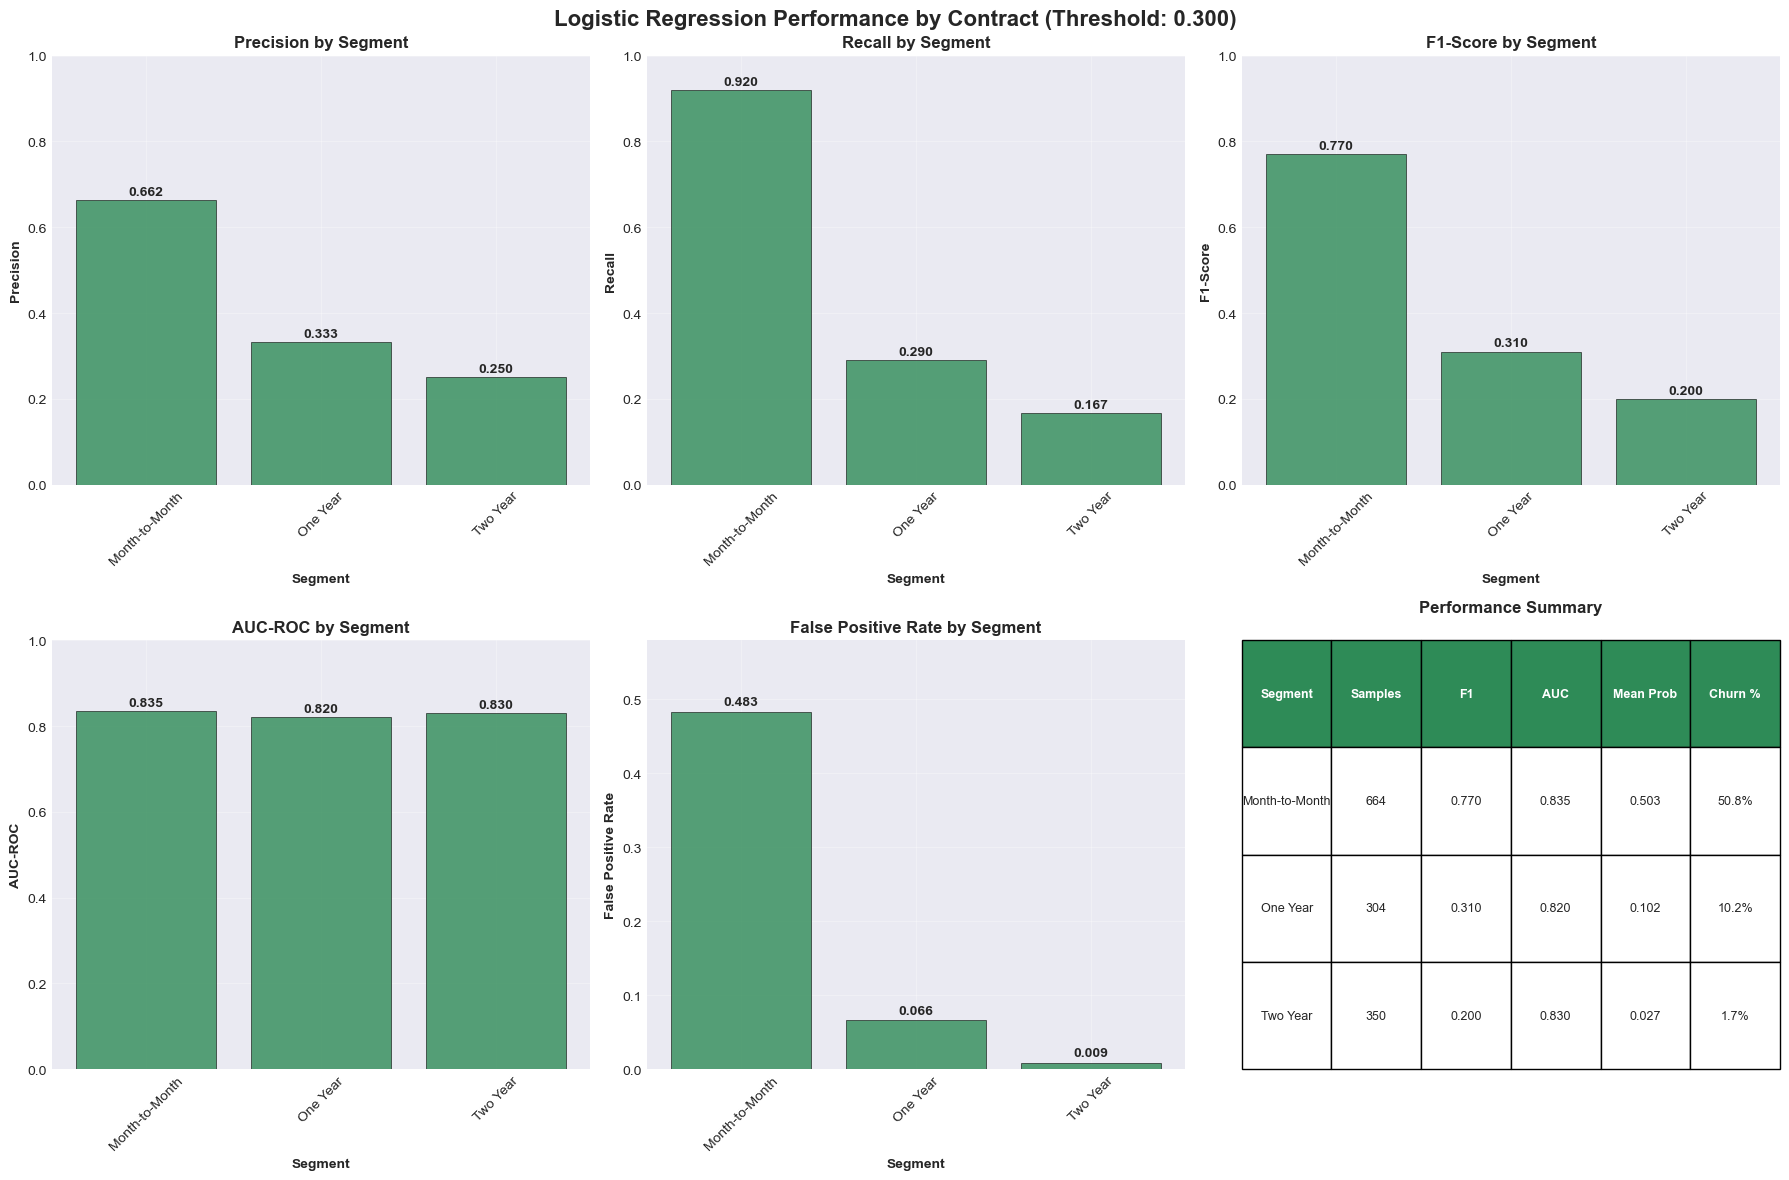

********************************************************************************************************************************************************************************************************
********************************************************************************************************************************************************************************************************
********************************************************************************************************************************************************************************************************
Contrato Mensual

=== DIVISIÓN DE DATOS ===

=== ESCALADO DE VARIABLES ===

=== CONFIGURACIÓN CROSS VALIDATION ===

=== GRID SEARCH CON CROSS VALIDATION ===

🔄 Ejecutando Grid Search...
✅ Grid Search completado
   Mejores parámetros: {'C': 1.0, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
   Mejor F1-Score (CV): 0.7874

=== EVALUACIÓN CON CROSS VALIDATION ===


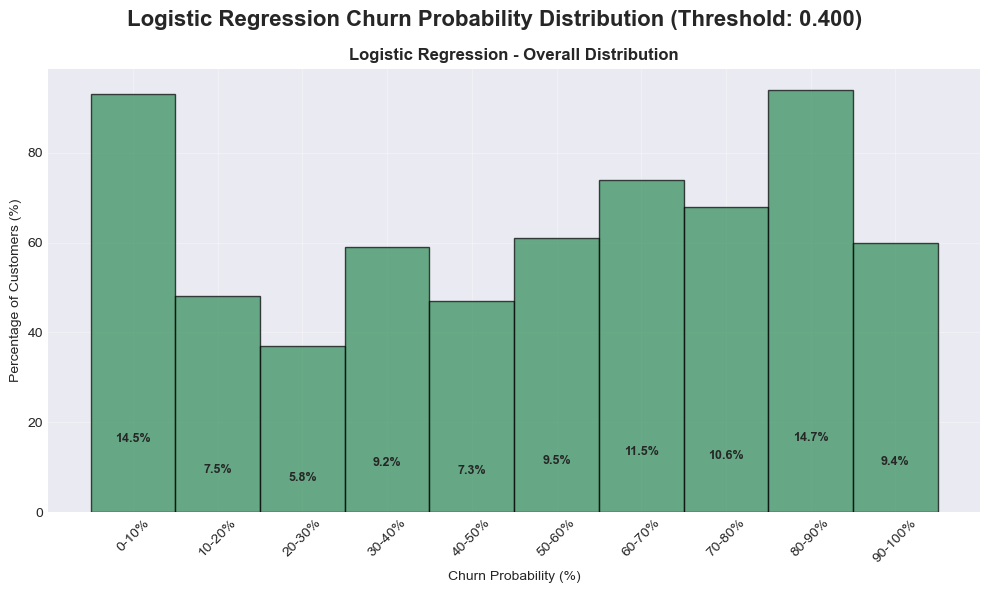


LOGISTIC REGRESSION CHURN PROBABILITY DISTRIBUTION SUMMARY

Logistic Regression (Threshold: 0.400):
  Mean Probability: 0.516 (51.6%)
  Median Probability: 0.564 (56.4%)
  Std Probability: 0.303
  Min Probability: 0.001 (0.1%)
  Max Probability: 0.987 (98.7%)
  Distribution by bins:
    0-10%: 14.5% of customers
    10-20%: 7.5% of customers
    20-30%: 5.8% of customers
    30-40%: 9.2% of customers
    40-50%: 7.3% of customers
    50-60%: 9.5% of customers
    60-70%: 11.5% of customers
    70-80%: 10.6% of customers
    80-90%: 14.7% of customers
    90-100%: 9.4% of customers


In [ ]:
### Regresion lineal
dfX = df_test_copy.copy()

# Eliminar filas donde customerStatus es 'Joined'
dfX = dfX[dfX['customerStatus'] != 'Joined'].reset_index(drop=True)



###'totalRevenue'

# Eliminar las variables indicadas en la lista 'eliminar' de dfX si existen
dfX = dfX.drop(columns=[col for col in eliminar if col in dfX.columns])
trained_model, optimal_threshold, probabilidades_test, y_test = churnRegresion(dfX)

segment_results = evaluate_trained_logistic_on_segments(
    dfX_original=dfX,
    trained_model=trained_model,
    optimal_threshold=optimal_threshold,
    segment_column='contract',
    random_state=42
)


print("****" * 50)
print("****" * 50)
print("****" * 50)


print('Contrato Mensual')
# Filtrar solo los clientes con contrato "Month-to-Month"
dfX = dfX[dfX['contract'] == 'Month-to-Month'].reset_index(drop=True)

# Eliminar la feature 'contract' si existe
if 'contract' in dfX.columns:
    dfX = dfX.drop(columns=['contract'])

# Si quieres volver a correr la regresión con este nuevo dfX:
trained_model, optimal_threshold, probabilidades_test, y_test = churnRegresion(dfX)
# Eliminar la columna 'customerStatus' si existe en dfX
# 2. Crear el diccionario results para el histograma
results = {
    'probabilities': probabilidades_test,
    'threshold': optimal_threshold
}

# 3. Generar el histograma
plot_logistic_probability_histogram(results, y_test)



In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import warnings
warnings.filterwarnings('ignore')

def compare_models_with_cv_and_threshold(X, y, cv_folds=5, test_size=0.2, random_state=42,total_charges=None):
    """
    Compare XGBoost and Random Forest using cross-validation with hyperparameter and threshold optimization.
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Input features
    y : array-like, shape (n_samples,)
        Binary target variable
    cv_folds : int, default=5
        Number of folds for cross-validation
    test_size : float, default=0.2
        Test set proportion
    random_state : int, default=42
        Random seed for reproducibility
    
    Returns:
    --------
    dict : Dictionary with comparison results
    """
    
    # Train/test split
    X_train, X_test, y_train, y_test,train_indices, test_indices = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    
    if total_charges is not None:
        total_charges_test = total_charges[test_indices]

    # Configure stratified cross-validation
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    # Define OPTIMIZED hyperparameters for each model
    
    xgb_params = {
        'n_estimators': [200],
        'max_depth': [3, 4, 6],
        'learning_rate': [0.05, 0.1, 0.15],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'reg_alpha': [0, 0.1],
        'min_child_weight': [1, 3],
        'scale_pos_weight': [1, 2, 3]  # Crucial for imbalanced churn
    }
    
    rf_params = {
        'n_estimators': [200],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', 0.3],
        'class_weight': ['balanced', None],  # For imbalanced churn
        'bootstrap': [True, False]
    }
    
    '''
    xgb_params = {
        'n_estimators': [200]
    }

    rf_params = {
        'n_estimators': [200]
    }  
    ''' 
    # Threshold ranges for optimization
    thresholds = np.arange(0.3, 0.8, 0.05)
    
    # Dictionaries to store results
    results = {
        'XGBoost': {'metrics': [], 'best_params': None, 'best_threshold': None, 'probabilities': None},
        'RandomForest': {'metrics': [], 'best_params': None, 'best_threshold': None, 'probabilities': None}
    }
    
    print("="*60)
    print("OPTIMIZED COMPARISON: XGBoost vs Random Forest")
    print("="*60)
    print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")
    print(f"Cross-validation with {cv_folds} folds")
    print(f"PRIMARY METRIC: F1-Score (optimal for churn)")
    print(f"SECONDARY METRIC: AUC-ROC (model comparison)")
    print(f"Optimizing {len(thresholds)} thresholds: {thresholds[0]:.2f} - {thresholds[-1]:.2f}")
    print("="*60)
    
    # ===== XGBoost =====
    print("\n🚀 Training XGBoost...")
    
    # GridSearchCV for XGBoost (only on train)
    xgb_model = xgb.XGBClassifier(random_state=random_state, eval_metric='logloss')
    xgb_grid = GridSearchCV(
        xgb_model, xgb_params, 
        cv=skf, 
        scoring='roc_auc', 
        n_jobs=-1, 
        verbose=0
    )
    xgb_grid.fit(X_train, y_train)
    
    # Best XGBoost model
    best_xgb = xgb_grid.best_estimator_
    results['XGBoost']['best_params'] = xgb_grid.best_params_
    
    # Cross-validation for different thresholds - XGBoost
    xgb_cv_results = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        # Train model with best parameters
        fold_model = xgb.XGBClassifier(**xgb_grid.best_params_, random_state=random_state, eval_metric='logloss')
        fold_model.fit(X_train_fold, y_train_fold)
        
        # Probabilistic predictions
        y_proba = fold_model.predict_proba(X_val_fold)[:, 1]
        
        # Test different thresholds
        fold_results = []
        for threshold in thresholds:
            y_pred = (y_proba >= threshold).astype(int)
            
            # Calculate metrics
            cm = confusion_matrix(y_val_fold, y_pred)
            precision = precision_score(y_val_fold, y_pred, zero_division=0)
            recall = recall_score(y_val_fold, y_pred, zero_division=0)
            f1 = f1_score(y_val_fold, y_pred, zero_division=0)
            auc = roc_auc_score(y_val_fold, y_proba)
            
            fold_results.append({
                'threshold': threshold,
                'confusion_matrix': cm,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc
            })
        
        xgb_cv_results.append(fold_results)
    
    # Find best threshold for XGBoost (based on average F1-score)
    threshold_scores = {}
    for threshold in thresholds:
        f1_scores = []
        for fold_results in xgb_cv_results:
            for result in fold_results:
                if result['threshold'] == threshold:
                    f1_scores.append(result['f1'])
        threshold_scores[threshold] = np.mean(f1_scores)
    
    best_xgb_threshold = max(threshold_scores, key=threshold_scores.get)
    results['XGBoost']['best_threshold'] = best_xgb_threshold
    
    # Evaluate XGBoost on test set
    # Train final model with best parameters on entire train set
    final_xgb_model = xgb.XGBClassifier(**xgb_grid.best_params_, random_state=random_state, eval_metric='logloss')
    final_xgb_model.fit(X_train, y_train)
    
    # Predictions on test
    y_proba_test_xgb = final_xgb_model.predict_proba(X_test)[:, 1]
    y_pred_test_xgb = (y_proba_test_xgb >= best_xgb_threshold).astype(int)
    
    # Store probabilities for histogram
    results['XGBoost']['probabilities'] = y_proba_test_xgb
    
    # Calculate final metrics on test for XGBoost
    cm_test_xgb = confusion_matrix(y_test, y_pred_test_xgb)
    tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_test_xgb.ravel()
    
    xgb_final_metrics = {
        'precision': precision_score(y_test, y_pred_test_xgb, zero_division=0),
        'recall': recall_score(y_test, y_pred_test_xgb, zero_division=0),
        'f1': f1_score(y_test, y_pred_test_xgb, zero_division=0),
        'auc': roc_auc_score(y_test, y_proba_test_xgb),
        'tn': tn_xgb,
        'fp': fp_xgb,
        'fn': fn_xgb,
        'tp': tp_xgb
    }
    
    results['XGBoost']['metrics'] = xgb_final_metrics
    
    # ===== Random Forest =====
    print("🌲 Training Random Forest...")
    
    # GridSearchCV for Random Forest (only on train)
    rf_model = RandomForestClassifier(random_state=random_state)
    rf_grid = GridSearchCV(
        rf_model, rf_params, 
        cv=skf, 
        scoring='roc_auc', 
        n_jobs=-1, 
        verbose=0
    )
    rf_grid.fit(X_train, y_train)
    
    # Best Random Forest model
    best_rf = rf_grid.best_estimator_
    results['RandomForest']['best_params'] = rf_grid.best_params_
    
    # Cross-validation for different thresholds - Random Forest
    rf_cv_results = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        # Train model with best parameters
        fold_model = RandomForestClassifier(**rf_grid.best_params_, random_state=random_state)
        fold_model.fit(X_train_fold, y_train_fold)
        
        # Probabilistic predictions
        y_proba = fold_model.predict_proba(X_val_fold)[:, 1]
        
        # Test different thresholds
        fold_results = []
        for threshold in thresholds:
            y_pred = (y_proba >= threshold).astype(int)
            
            # Calculate metrics
            cm = confusion_matrix(y_val_fold, y_pred)
            precision = precision_score(y_val_fold, y_pred, zero_division=0)
            recall = recall_score(y_val_fold, y_pred, zero_division=0)
            f1 = f1_score(y_val_fold, y_pred, zero_division=0)
            auc = roc_auc_score(y_val_fold, y_proba)
            
            fold_results.append({
                'threshold': threshold,
                'confusion_matrix': cm,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc
            })
        
        rf_cv_results.append(fold_results)
    
    # Find best threshold for Random Forest
    threshold_scores = {}
    for threshold in thresholds:
        f1_scores = []
        for fold_results in rf_cv_results:
            for result in fold_results:
                if result['threshold'] == threshold:
                    f1_scores.append(result['f1'])
        threshold_scores[threshold] = np.mean(f1_scores)
    
    best_rf_threshold = max(threshold_scores, key=threshold_scores.get)
    results['RandomForest']['best_threshold'] = best_rf_threshold
    
    # Evaluate Random Forest on test set
    # Train final model with best parameters on entire train set
    final_rf_model = RandomForestClassifier(**rf_grid.best_params_, random_state=random_state)
    final_rf_model.fit(X_train, y_train)
    
    # Predictions on test
    y_proba_test_rf = final_rf_model.predict_proba(X_test)[:, 1]
    y_pred_test_rf = (y_proba_test_rf >= best_rf_threshold).astype(int)
    
    # Store probabilities for histogram
    results['RandomForest']['probabilities'] = y_proba_test_rf
    
    # Calculate final metrics on test for Random Forest
    cm_test_rf = confusion_matrix(y_test, y_pred_test_rf)
    tn_rf, fp_rf, fn_rf, tp_rf = cm_test_rf.ravel()
    
    rf_final_metrics = {
        'precision': precision_score(y_test, y_pred_test_rf, zero_division=0),
        'recall': recall_score(y_test, y_pred_test_rf, zero_division=0),
        'f1': f1_score(y_test, y_pred_test_rf, zero_division=0),
        'auc': roc_auc_score(y_test, y_proba_test_rf),
        'tn': tn_rf,
        'fp': fp_rf,
        'fn': fn_rf,
        'tp': tp_rf
    }
    
    results['RandomForest']['metrics'] = rf_final_metrics
    
    # ===== DISPLAY RESULTS =====
    print("\n" + "="*60)
    print("COMPARISON RESULTS")
    print("="*60)
    
    # Create DataFrame for comparison
    comparison_data = []
    
    for model_name in ['XGBoost', 'RandomForest']:
        metrics = results[model_name]['metrics']
        comparison_data.append({
            'Model': model_name,
            'Precision': f"{metrics['precision']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'F1-Score': f"{metrics['f1']:.4f}",
            'AUC': f"{metrics['auc']:.4f}",
            'Threshold': f"{results[model_name]['best_threshold']:.3f}"
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n📊 TEST METRICS:")
    print(comparison_df.to_string(index=False))
    
    # Show confusion matrix on test
    print(f"\n📈 TEST CONFUSION MATRIX:")
    for model_name in ['XGBoost', 'RandomForest']:
        metrics = results[model_name]['metrics']
        print(f"\n{model_name}:")
        cm_test = np.array([[metrics['tn'], metrics['fp']], 
                           [metrics['fn'], metrics['tp']]])
        print(f"TN: {metrics['tn']}, FP: {metrics['fp']}")
        print(f"FN: {metrics['fn']}, TP: {metrics['tp']}")
    
    # Show best hyperparameters
    print(f"\n⚙️ BEST HYPERPARAMETERS:")
    for model_name in ['XGBoost', 'RandomForest']:
        print(f"\n{model_name}:")
        for param, value in results[model_name]['best_params'].items():
            print(f"  {param}: {value}")
    
    # Determine winner
    xgb_f1 = results['XGBoost']['metrics']['f1']
    rf_f1 = results['RandomForest']['metrics']['f1']
    
    winner = "XGBoost" if xgb_f1 > rf_f1 else "Random Forest"
    print(f"\n🏆 WINNER: {winner} (F1-Score: {max(xgb_f1, rf_f1):.4f})")
    
    # ===== GENERATE CHURN PROBABILITY HISTOGRAM =====
    print("\n📊 Generating Churn Probability Histogram...")
    plot_churn_probability_histogram(results, y_test, total_charges)
    
    return results

def plot_churn_probability_histogram(results, y_test, X_test_df=None, total_charges=None):
    """
    Generate histogram of churn probabilities grouped in 10% bins for both models,
    including analysis of totalCharges distribution.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from model comparison
    y_test : array-like
        True labels for test set
    X_test_df : pandas.DataFrame, optional
        Test dataframe containing TotalCharges column
    total_charges : array-like, optional
        TotalCharges values for test set (if not in X_test_df)
    
    Note: Either X_test_df or total_charges must be provided for revenue analysis
    """
    
    # Extract total_charges from dataframe if provided
    if total_charges is None and X_test_df is not None:
        if 'TotalCharges' in X_test_df.columns:
            total_charges = X_test_df['TotalCharges'].values
        elif 'totalCharges' in X_test_df.columns:
            total_charges = X_test_df['totalCharges'].values
        elif 'total_charges' in X_test_df.columns:
            total_charges = X_test_df['total_charges'].values
        else:
            print(f"Warning: TotalCharges column not found. Available columns: {list(X_test_df.columns)}")
            total_charges = None
    
    # Handle total_charges conversion and cleaning
    revenue_analysis = False
    if total_charges is not None:
        total_charges = pd.to_numeric(total_charges, errors='coerce')
        if np.any(np.isnan(total_charges)):
            print(f"Warning: Found {np.sum(np.isnan(total_charges))} NaN values in TotalCharges. Replacing with 0.")
            total_charges = np.nan_to_num(total_charges, nan=0)
        revenue_analysis = True
        total_revenue = np.sum(total_charges)
    
    # Set up the plot - 3 columns if revenue analysis, 2 if not
    cols = 3 if revenue_analysis else 2
    fig, axes = plt.subplots(2, cols, figsize=(15 if cols == 2 else 20, 12))
    title = 'Churn Probability Distribution and Revenue Analysis on Test Set' if revenue_analysis else 'Churn Probability Distribution on Test Set'
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Define bins (0-10%, 10-20%, ..., 90-100%)
    bins = np.arange(0, 1.1, 0.1)
    bin_labels = [f'{int(i*100)}-{int((i+0.1)*100)}%' for i in bins[:-1]]
    
    models = ['XGBoost', 'RandomForest']
    colors = ['skyblue', 'lightcoral']
    
    for idx, model_name in enumerate(models):
        probabilities = results[model_name]['probabilities']
        
        # Convert to percentage
        prob_percentage = probabilities * 100
        
        # Plot overall distribution
        ax1 = axes[idx, 0]
        counts, _, _ = ax1.hist(prob_percentage, bins=np.arange(0, 101, 10), 
                              color=colors[idx], alpha=0.7, edgecolor='black')
        
        # Convert counts to percentages
        total_samples = len(prob_percentage)
        percentages = (counts / total_samples) * 100
        
        ax1.set_title(f'{model_name} - Customer Distribution', fontweight='bold')
        ax1.set_xlabel('Churn Probability (%)')
        ax1.set_ylabel('Percentage of Customers (%)')
        ax1.set_xticks(np.arange(5, 101, 10))
        ax1.set_xticklabels(bin_labels, rotation=45)
        ax1.grid(True, alpha=0.3)
        
        # Add percentage labels on bars
        for i, (count, pct) in enumerate(zip(counts, percentages)):
            if pct > 0:
                ax1.text(i*10 + 5, pct + 0.5, f'{pct:.1f}%', 
                        ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        # Plot by actual churn status
        ax2 = axes[idx, 1]
        
        # Separate probabilities by actual churn status
        churn_probs = probabilities[y_test == 1] * 100
        no_churn_probs = probabilities[y_test == 0] * 100
        
        # Create histogram data
        churn_counts, _ = np.histogram(churn_probs, bins=np.arange(0, 101, 10))
        no_churn_counts, _ = np.histogram(no_churn_probs, bins=np.arange(0, 101, 10))
        
        # Convert to percentages
        total_churn = len(churn_probs)
        total_no_churn = len(no_churn_probs)
        
        churn_pct = (churn_counts / total_churn) * 100 if total_churn > 0 else np.zeros_like(churn_counts)
        no_churn_pct = (no_churn_counts / total_no_churn) * 100 if total_no_churn > 0 else np.zeros_like(no_churn_counts)
        
        # Plot side by side bars
        x_pos = np.arange(len(bin_labels))
        width = 0.35
        
        bars1 = ax2.bar(x_pos - width/2, no_churn_pct, width, 
                       label='No Churn (Actual)', color='lightgreen', alpha=0.7, edgecolor='black')
        bars2 = ax2.bar(x_pos + width/2, churn_pct, width, 
                       label='Churn (Actual)', color='salmon', alpha=0.7, edgecolor='black')
        
        ax2.set_title(f'{model_name} - By Actual Churn Status', fontweight='bold')
        ax2.set_xlabel('Predicted Churn Probability (%)')
        ax2.set_ylabel('Percentage of Customers (%)')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(bin_labels, rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Add percentage labels on bars
        for bars, percentages in [(bars1, no_churn_pct), (bars2, churn_pct)]:
            for bar, pct in zip(bars, percentages):
                if pct > 0:
                    height = bar.get_height()
                    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                            f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=8)
        
        # Revenue analysis (only if total_charges is available)
        if revenue_analysis:
            ax3 = axes[idx, 2]
            
            # Calculate revenue for each bin
            revenue_by_bin = []
            for i in range(len(bins)-1):
                bin_mask = (prob_percentage >= bins[i]*100) & (prob_percentage < bins[i+1]*100)
                if i == len(bins)-2:  # Last bin includes 100%
                    bin_mask = (prob_percentage >= bins[i]*100) & (prob_percentage <= bins[i+1]*100)
                
                bin_revenue = np.sum(total_charges[bin_mask])
                revenue_by_bin.append(bin_revenue)
            
            # Convert to percentages of total revenue
            revenue_percentages = [(rev / total_revenue) * 100 for rev in revenue_by_bin]
            
            bars3 = ax3.bar(x_pos, revenue_percentages, 
                           color=colors[idx], alpha=0.7, edgecolor='black')
            
            ax3.set_title(f'{model_name} - Revenue Distribution', fontweight='bold')
            ax3.set_xlabel('Predicted Churn Probability (%)')
            ax3.set_ylabel('Percentage of Total Revenue (%)')
            ax3.set_xticks(x_pos)
            ax3.set_xticklabels(bin_labels, rotation=45)
            ax3.grid(True, alpha=0.3)
            
            # Add revenue percentage labels on bars
            for bar, rev_pct, revenue in zip(bars3, revenue_percentages, revenue_by_bin):
                if rev_pct > 0:
                    height = bar.get_height()
                    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                            f'{rev_pct:.1f}%\n${revenue:,.0f}', 
                            ha='center', va='bottom', fontweight='bold', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    separator = "="*80 if revenue_analysis else "="*60
    title = "CHURN PROBABILITY DISTRIBUTION AND REVENUE ANALYSIS SUMMARY" if revenue_analysis else "CHURN PROBABILITY DISTRIBUTION SUMMARY"
    
    print(f"\n{separator}")
    print(title)
    print(separator)
    
    if revenue_analysis:
        print(f"Total Revenue in Test Set: ${total_revenue:,.2f}")
    
    for model_name in models:
        probabilities = results[model_name]['probabilities']
        print(f"\n{model_name}:")
        print(f"  Mean Probability: {np.mean(probabilities):.3f} ({np.mean(probabilities)*100:.1f}%)")
        print(f"  Median Probability: {np.median(probabilities):.3f} ({np.median(probabilities)*100:.1f}%)")
        print(f"  Std Probability: {np.std(probabilities):.3f}")
        print(f"  Min Probability: {np.min(probabilities):.3f} ({np.min(probabilities)*100:.1f}%)")
        print(f"  Max Probability: {np.max(probabilities):.3f} ({np.max(probabilities)*100:.1f}%)")
        
        # Distribution by bins
        prob_percentage = probabilities * 100
        counts, _ = np.histogram(prob_percentage, bins=np.arange(0, 101, 10))
        total_samples = len(prob_percentage)
        customer_percentages = (counts / total_samples) * 100
        
        if revenue_analysis:
            # Revenue analysis by bins
            revenue_by_bin = []
            avg_revenue_by_bin = []
            for i in range(len(bins)-1):
                bin_mask = (prob_percentage >= bins[i]*100) & (prob_percentage < bins[i+1]*100)
                if i == len(bins)-2:  # Last bin includes 100%
                    bin_mask = (prob_percentage >= bins[i]*100) & (prob_percentage <= bins[i+1]*100)
                
                bin_revenue = np.sum(total_charges[bin_mask])
                bin_customers = np.sum(bin_mask)
                avg_revenue = bin_revenue / bin_customers if bin_customers > 0 else 0
                
                revenue_by_bin.append(bin_revenue)
                avg_revenue_by_bin.append(avg_revenue)
            
            revenue_percentages = [(rev / total_revenue) * 100 for rev in revenue_by_bin]
            
            print(f"\n  Distribution Analysis:")
            print(f"  {'Probability Range':<15} {'Customers %':<12} {'Revenue %':<12} {'Total Revenue':<15} {'Avg Revenue':<12}")
            print(f"  {'-'*15} {'-'*12} {'-'*12} {'-'*15} {'-'*12}")
            
            for i, (label, cust_pct, rev_pct, total_rev, avg_rev) in enumerate(
                zip(bin_labels, customer_percentages, revenue_percentages, revenue_by_bin, avg_revenue_by_bin)):
                print(f"  {label:<15} {cust_pct:>8.1f}%    {rev_pct:>8.1f}%    ${total_rev:>12,.0f}  ${avg_rev:>8,.0f}")
            
            # Risk analysis
            print(f"\n  Risk Analysis:")
            high_risk_mask = prob_percentage >= 70  # 70%+ probability
            medium_risk_mask = (prob_percentage >= 30) & (prob_percentage < 70)  # 30-70%
            low_risk_mask = prob_percentage < 30  # <30%
            
            high_risk_revenue = np.sum(total_charges[high_risk_mask])
            medium_risk_revenue = np.sum(total_charges[medium_risk_mask])
            low_risk_revenue = np.sum(total_charges[low_risk_mask])
            
            high_risk_customers = np.sum(high_risk_mask)
            medium_risk_customers = np.sum(medium_risk_mask)
            low_risk_customers = np.sum(low_risk_mask)
            
            print(f"    High Risk (70%+):   {high_risk_customers:>4} customers ({high_risk_customers/len(probabilities)*100:>5.1f}%) - ${high_risk_revenue:>10,.0f} ({high_risk_revenue/total_revenue*100:>5.1f}%)")
            print(f"    Medium Risk (30-70%): {medium_risk_customers:>4} customers ({medium_risk_customers/len(probabilities)*100:>5.1f}%) - ${medium_risk_revenue:>10,.0f} ({medium_risk_revenue/total_revenue*100:>5.1f}%)")
            print(f"    Low Risk (<30%):     {low_risk_customers:>4} customers ({low_risk_customers/len(probabilities)*100:>5.1f}%) - ${low_risk_revenue:>10,.0f} ({low_risk_revenue/total_revenue*100:>5.1f}%)")
            
            # Revenue at risk calculation
            actual_churn_mask = y_test == 1
            predicted_high_risk = prob_percentage >= 50  # Using 50% as threshold
            
            revenue_at_risk_actual = np.sum(total_charges[actual_churn_mask])
            revenue_at_risk_predicted = np.sum(total_charges[predicted_high_risk])
            
            print(f"\n  Revenue at Risk:")
            print(f"    Actual Churners:     ${revenue_at_risk_actual:>10,.0f} ({revenue_at_risk_actual/total_revenue*100:>5.1f}%)")
            print(f"    Predicted High Risk: ${revenue_at_risk_predicted:>10,.0f} ({revenue_at_risk_predicted/total_revenue*100:>5.1f}%)")
            
        else:
            print(f"  Distribution by bins:")
            for i, (label, pct) in enumerate(zip(bin_labels, customer_percentages)):
                print(f"    {label}: {pct:.1f}% of customers")

# Example usage with your data:
# results = compare_models_with_cv_and_threshold(X_scaled, y['customerStatus'].values)

In [50]:
df_test_copy.columns

Index(['gender', 'age', 'married', 'numberOfDependents', 'numberOfReferrals',
       'tenureInMonths', 'offer', 'phoneService',
       'avgMonthlyLongDistanceCharges', 'multipleLines', 'internetService',
       'internetType', 'avgMonthlyGbDownload', 'onlineSecurity',
       'onlineBackup', 'deviceProtectionPlan', 'premiumTechSupport',
       'streamingTv', 'streamingMovies', 'streamingMusic', 'unlimitedData',
       'contract', 'paperlessBilling', 'paymentMethod', 'monthlyCharge',
       'totalCharges', 'totalRefunds', 'totalExtraDataCharges',
       'totalLongDistanceCharges', 'totalRevenue', 'customerStatus',
       'churnCategory', 'churnReason'],
      dtype='object')

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def evaluate_model_on_segments(dfX_original, results, segment_column, random_state=42):
    """
    Compare key evaluation metrics for trained models on different data segments.
    
    Parameters:
    -----------
    dfX_original : pandas.DataFrame
        Original dataframe with segment column (before preprocessing)
    results : dict
        Results from compare_models_with_cv_and_threshold function
    segment_column : str
        Column name to segment by (e.g., 'contracts')
    random_state : int
        Random seed for reproducibility (must match training)
    
    Returns:
    --------
    dict : Key metrics comparison by segment
    """
    
    if segment_column not in dfX_original.columns:
        print(f"Error: '{segment_column}' column not found!")
        return None
    
    # Recreate preprocessing pipeline
    dfX_processed = dfX_original.copy()
    dfX_processed = dfX_processed[dfX_processed['customerStatus'] != 'Joined'].reset_index(drop=True)
    
    y = dfX_processed['customerStatus'].map({'Churned': 1, 'Stayed': 0}).values
    segment_values = dfX_processed[segment_column].values
    
    if 'customerStatus' in dfX_processed.columns:
        dfX_processed = dfX_processed.drop(columns=['customerStatus'])
    
    dfX_dummy = pd.get_dummies(dfX_processed, drop_first=True)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(dfX_dummy)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=random_state
    )
    
    train_indices, test_indices = train_test_split(
        range(len(segment_values)), test_size=0.2, stratify=y, random_state=random_state
    )
    segment_test = segment_values[test_indices]
    
    # Recreate trained models
    xgb_model = xgboost.XGBClassifier(**results['XGBoost']['best_params'], 
                                      random_state=random_state, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    
    rf_model = RandomForestClassifier(**results['RandomForest']['best_params'], 
                                      random_state=random_state)
    rf_model.fit(X_train, y_train)
    
    # Get predictions
    xgb_probabilities = xgb_model.predict_proba(X_test)[:, 1]
    xgb_predictions = (xgb_probabilities >= results['XGBoost']['best_threshold']).astype(int)
    
    rf_probabilities = rf_model.predict_proba(X_test)[:, 1]
    rf_predictions = (rf_probabilities >= results['RandomForest']['best_threshold']).astype(int)
    
    unique_segments = np.unique(segment_test)
    
    # Calculate metrics for each segment
    segment_metrics = {}
    
    for segment in unique_segments:
        mask = segment_test == segment
        sample_count = np.sum(mask)
        
        if sample_count == 0:
            continue
        
        segment_data = {'sample_count': sample_count}
        
        models = {
            'XGBoost': {'predictions': xgb_predictions, 'probabilities': xgb_probabilities},
            'RandomForest': {'predictions': rf_predictions, 'probabilities': rf_probabilities}
        }
        
        for model_name, model_data in models.items():
            y_true_seg = y_test[mask]
            y_pred_seg = model_data['predictions'][mask]
            y_prob_seg = model_data['probabilities'][mask]
            
            # Calculate key metrics
            precision = precision_score(y_true_seg, y_pred_seg, zero_division=0)
            recall = recall_score(y_true_seg, y_pred_seg, zero_division=0)
            f1 = f1_score(y_true_seg, y_pred_seg, zero_division=0)
            
            if len(np.unique(y_true_seg)) > 1:
                auc = roc_auc_score(y_true_seg, y_prob_seg)
            else:
                auc = 0.5
            
            # Calculate FPR (False Positive Rate)
            cm = confusion_matrix(y_true_seg, y_pred_seg)
            
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
            elif cm.shape == (1, 1):
                if np.unique(y_true_seg)[0] == 0:
                    tn, fp, fn, tp = cm[0, 0], 0, 0, 0
                else:
                    tn, fp, fn, tp = 0, 0, 0, cm[0, 0]
            else:
                tn = fp = fn = tp = 0
            
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
            
            segment_data[model_name] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'auc_roc': auc,
                'fpr': fpr
            }
        
        segment_metrics[segment] = segment_data
    
    # Create comparison table
    comparison_data = []
    for segment in unique_segments:
        if segment in segment_metrics and 'XGBoost' in segment_metrics[segment] and 'RandomForest' in segment_metrics[segment]:
            xgb = segment_metrics[segment]['XGBoost']
            rf = segment_metrics[segment]['RandomForest']
            
            comparison_data.append({
                'Segment': segment,
                'Samples': segment_metrics[segment]['sample_count'],
                'XGB_Precision': f"{xgb['precision']:.4f}",
                'RF_Precision': f"{rf['precision']:.4f}",
                'XGB_Recall': f"{xgb['recall']:.4f}",
                'RF_Recall': f"{rf['recall']:.4f}",
                'XGB_F1': f"{xgb['f1_score']:.4f}",
                'RF_F1': f"{rf['f1_score']:.4f}",
                'XGB_AUC': f"{xgb['auc_roc']:.4f}",
                'RF_AUC': f"{rf['auc_roc']:.4f}",
                'XGB_FPR': f"{xgb['fpr']:.4f}",
                'RF_FPR': f"{rf['fpr']:.4f}"
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Display results
    print("METRICS COMPARISON BY SEGMENT")
    print("=" * 80)
    print(comparison_df.to_string(index=False))
    
    # Generate visualizations
    plot_key_metrics(segment_metrics, segment_column, unique_segments)
    
    return {
        'segment_metrics': segment_metrics,
        'comparison_table': comparison_df,
        'segments': list(unique_segments)
    }

def plot_key_metrics(segment_metrics, segment_column, segments):
    """
    Plot the 5 key metrics: Precision, Recall, F1-Score, AUC-ROC, and FPR.
    """
    
    # Set up the plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Key Performance Metrics by {segment_column.title()}', fontsize=16, fontweight='bold')
    
    models = ['XGBoost', 'RandomForest']
    colors = {'XGBoost': '#2E86AB', 'RandomForest': '#A23B72'}
    
    # Metrics to plot
    metrics = ['precision', 'recall', 'f1_score', 'auc_roc', 'fpr']
    metric_titles = ['Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'False Positive Rate']
    
    # Plot each metric
    for idx, (metric, title) in enumerate(zip(metrics, metric_titles)):
        if idx < 5:  # Only plot first 5 metrics
            row = idx // 3
            col = idx % 3
            ax = axes[row, col]
            
            x_pos = np.arange(len(segments))
            width = 0.35
            
            for i, model in enumerate(models):
                values = []
                for segment in segments:
                    if segment in segment_metrics and model in segment_metrics[segment]:
                        values.append(segment_metrics[segment][model][metric])
                    else:
                        values.append(0)
                
                bars = ax.bar(x_pos + i*width, values, width, label=model, 
                             color=colors[model], alpha=0.8, edgecolor='black', linewidth=0.5)
                
                # Add value labels on bars
                for bar, value in zip(bars, values):
                    if value > 0:
                        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                               f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
            
            ax.set_xlabel('Segment', fontweight='bold')
            ax.set_ylabel(title, fontweight='bold')
            ax.set_title(f'{title} by Segment', fontweight='bold')
            ax.set_xticks(x_pos + width/2)
            ax.set_xticklabels(segments, rotation=45, ha='right')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Set y-axis limits
            if metric == 'fpr':
                ax.set_ylim(0, max(0.5, max([max(values) for values in [
                    [segment_metrics[seg][model][metric] for seg in segments if seg in segment_metrics and model in segment_metrics[seg]]
                    for model in models
                ] if values]) * 1.2))
            else:
                ax.set_ylim(0, 1)
    
    # Remove the 6th subplot (empty)
    axes[1, 2].remove()
    
    # Add a summary table in the empty space
    ax_table = fig.add_subplot(2, 3, 6)
    ax_table.axis('off')
    
    # Create summary table
    summary_data = []
    for segment in segments:
        if segment in segment_metrics:
            xgb_metrics = segment_metrics[segment]['XGBoost']
            rf_metrics = segment_metrics[segment]['RandomForest']
            
            # Count wins for each model
            xgb_wins = 0
            rf_wins = 0
            
            for metric in ['precision', 'recall', 'f1_score', 'auc_roc']:
                if xgb_metrics[metric] > rf_metrics[metric]:
                    xgb_wins += 1
                elif rf_metrics[metric] > xgb_metrics[metric]:
                    rf_wins += 1
            
            # For FPR, lower is better
            if xgb_metrics['fpr'] < rf_metrics['fpr']:
                xgb_wins += 1
            elif rf_metrics['fpr'] < xgb_metrics['fpr']:
                rf_wins += 1
            
            overall_winner = 'XGBoost' if xgb_wins > rf_wins else 'RandomForest' if rf_wins > xgb_wins else 'Tie'
            
            summary_data.append([
                segment,
                segment_metrics[segment]['sample_count'],
                f"{xgb_wins}/5",
                f"{rf_wins}/5", 
                overall_winner
            ])
    
    # Create table
    table_headers = ['Segment', 'Samples', 'XGB Wins', 'RF Wins', 'Overall Winner']
    table = ax_table.table(cellText=summary_data, colLabels=table_headers,
                          cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(table_headers)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax_table.set_title('Model Performance Summary', fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

# Usage example:
# results = evaluate_model_on_segments(dfX_original, results, 'contracts', random_state=42)

(7043, 33)
OPTIMIZED COMPARISON: XGBoost vs Random Forest
Train size: 5271 | Test size: 1318
Cross-validation with 5 folds
PRIMARY METRIC: F1-Score (optimal for churn)
SECONDARY METRIC: AUC-ROC (model comparison)
Optimizing 10 thresholds: 0.30 - 0.75

🚀 Training XGBoost...
🌲 Training Random Forest...

COMPARISON RESULTS

📊 TEST METRICS:
       Model Precision Recall F1-Score    AUC Threshold
     XGBoost    0.7535 0.7193   0.7360 0.9280     0.400
RandomForest    0.7296 0.7647   0.7467 0.9234     0.550

📈 TEST CONFUSION MATRIX:

XGBoost:
TN: 856, FP: 88
FN: 105, TP: 269

RandomForest:
TN: 838, FP: 106
FN: 88, TP: 286

⚙️ BEST HYPERPARAMETERS:

XGBoost:
  colsample_bytree: 0.9
  learning_rate: 0.05
  max_depth: 3
  min_child_weight: 1
  n_estimators: 200
  reg_alpha: 0
  scale_pos_weight: 1
  subsample: 0.9

RandomForest:
  bootstrap: False
  class_weight: balanced
  max_depth: 10
  max_features: 0.3
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200

🏆 WINNER: Random Fores

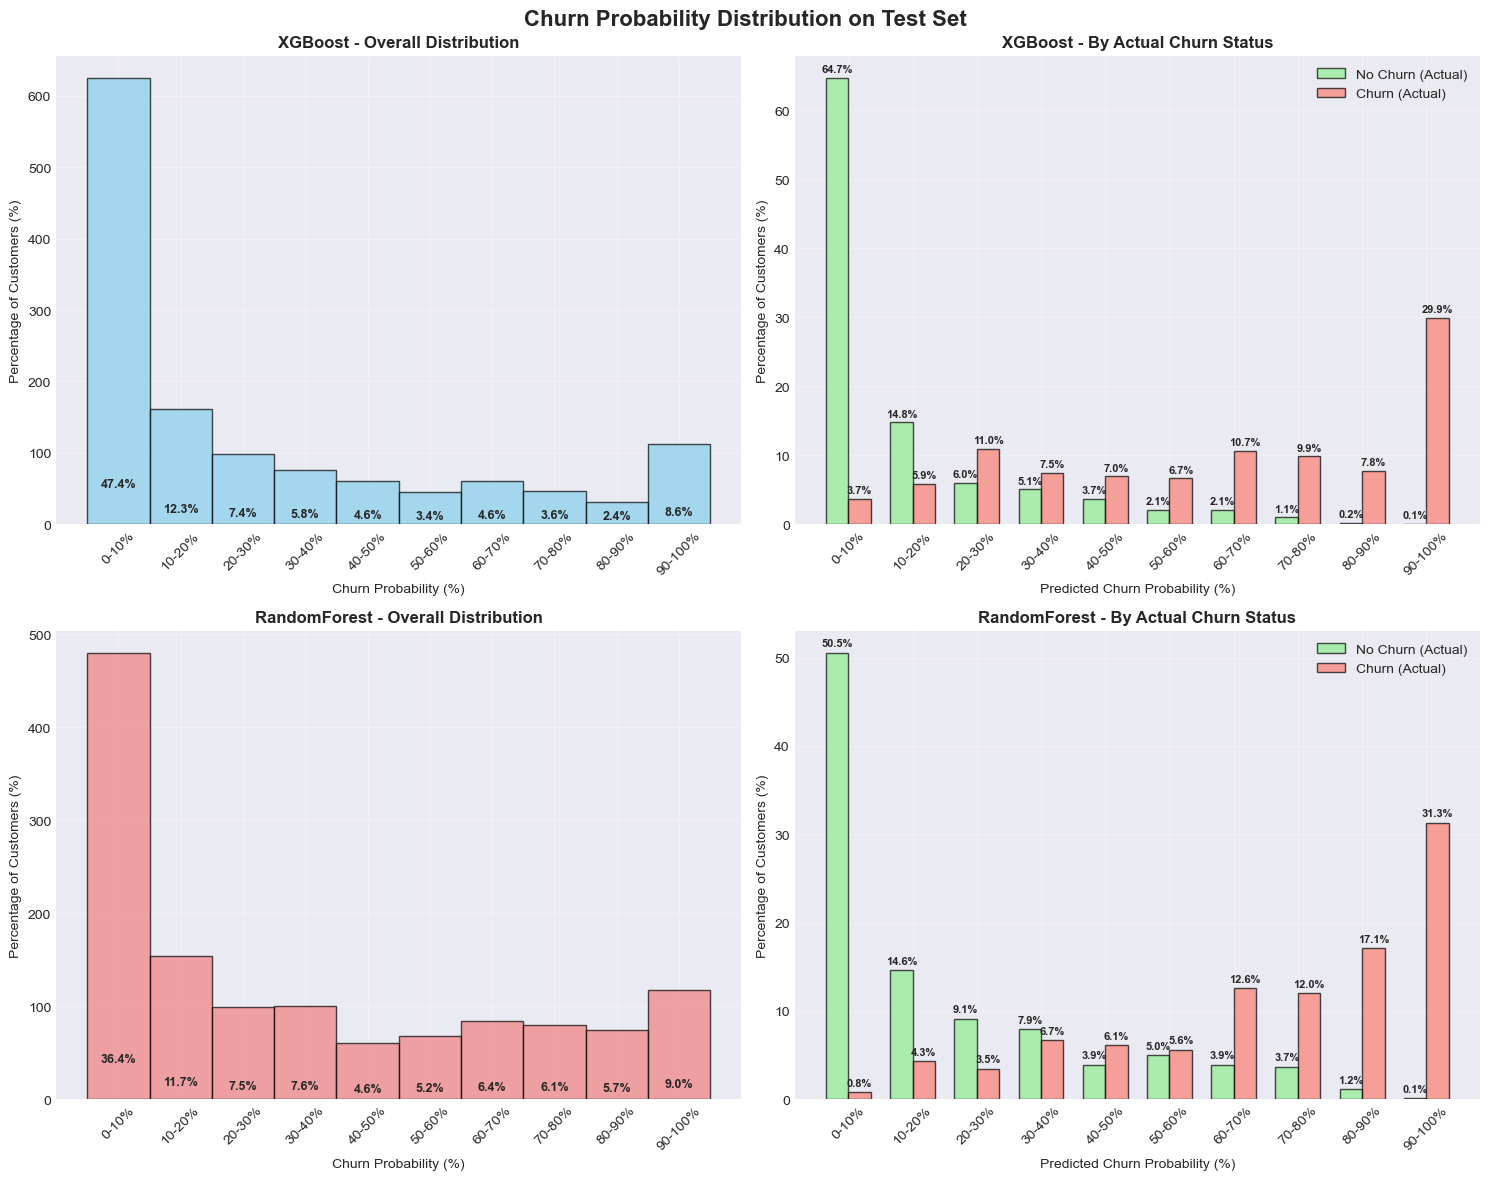


CHURN PROBABILITY DISTRIBUTION SUMMARY

XGBoost:
  Mean Probability: 0.271 (27.1%)
  Median Probability: 0.113 (11.3%)
  Std Probability: 0.320
  Min Probability: 0.001 (0.1%)
  Max Probability: 0.998 (99.8%)
  Distribution by bins:
    0-10%: 47.4% of customers
    10-20%: 12.3% of customers
    20-30%: 7.4% of customers
    30-40%: 5.8% of customers
    40-50%: 4.6% of customers
    50-60%: 3.4% of customers
    60-70%: 4.6% of customers
    70-80%: 3.6% of customers
    80-90%: 2.4% of customers
    90-100%: 8.6% of customers

RandomForest:
  Mean Probability: 0.347 (34.7%)
  Median Probability: 0.223 (22.3%)
  Std Probability: 0.332
  Min Probability: 0.000 (0.0%)
  Max Probability: 1.000 (100.0%)
  Distribution by bins:
    0-10%: 36.4% of customers
    10-20%: 11.7% of customers
    20-30%: 7.5% of customers
    30-40%: 7.6% of customers
    40-50%: 4.6% of customers
    50-60%: 5.2% of customers
    60-70%: 6.4% of customers
    70-80%: 6.1% of customers
    80-90%: 5.7% of cus

In [47]:
### arboles
dfX=''
dfX = df_test_copy.copy()
print(dfX.shape)
# Eliminar filas donde customerStatus es 'Joined'
dfX = dfX[dfX['customerStatus'] != 'Joined'].reset_index(drop=True)

eliminar = ['churnCategory','churnReason', 'totalCharges', 'totalRefunds', 'totalExtraDataCharges','totalLongDistanceCharges']
dfX = dfX.drop(columns=[col for col in eliminar if col in dfX.columns])

dfX_original = dfX.copy()  # Guarda el original

# 2. y - Variable objetivo
y = dfX['customerStatus'].map({'Churned': 1, 'Stayed': 0}).values  # Crear directamente como numpy array

# Eliminar 'customerStatus' de dfX
if 'customerStatus' in dfX.columns:
    dfX = dfX.drop(columns=['customerStatus'])
    
#dfX_dummy - Crear variables dummy
dfX_dummy = pd.get_dummies(dfX, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dfX_dummy)

##llmar a la funcion compare_models_with_cv_and_threshold

results = compare_models_with_cv_and_threshold(
    X=X_scaled,           # Características escaladas (numpy array)
    y=y,                  # Variable objetivo (numpy array)
    cv_folds=5,           # Validación cruzada con 5 folds
    random_state=42       # Semilla para reproducibilidad
) 




METRICS COMPARISON BY SEGMENT
       Segment  Samples XGB_Precision RF_Precision XGB_Recall RF_Recall XGB_F1  RF_F1 XGB_AUC RF_AUC XGB_FPR RF_FPR
Month-to-Month      664        0.7784       0.7480     0.7715    0.8190 0.7750 0.7819  0.8734 0.8652  0.2263 0.2844
      One Year      304        0.3636       0.4348     0.2581    0.3226 0.3019 0.3704  0.8638 0.8506  0.0513 0.0476
      Two Year      350        1.0000       0.0000     0.1667    0.0000 0.2857 0.0000  0.8668 0.8440  0.0000 0.0000


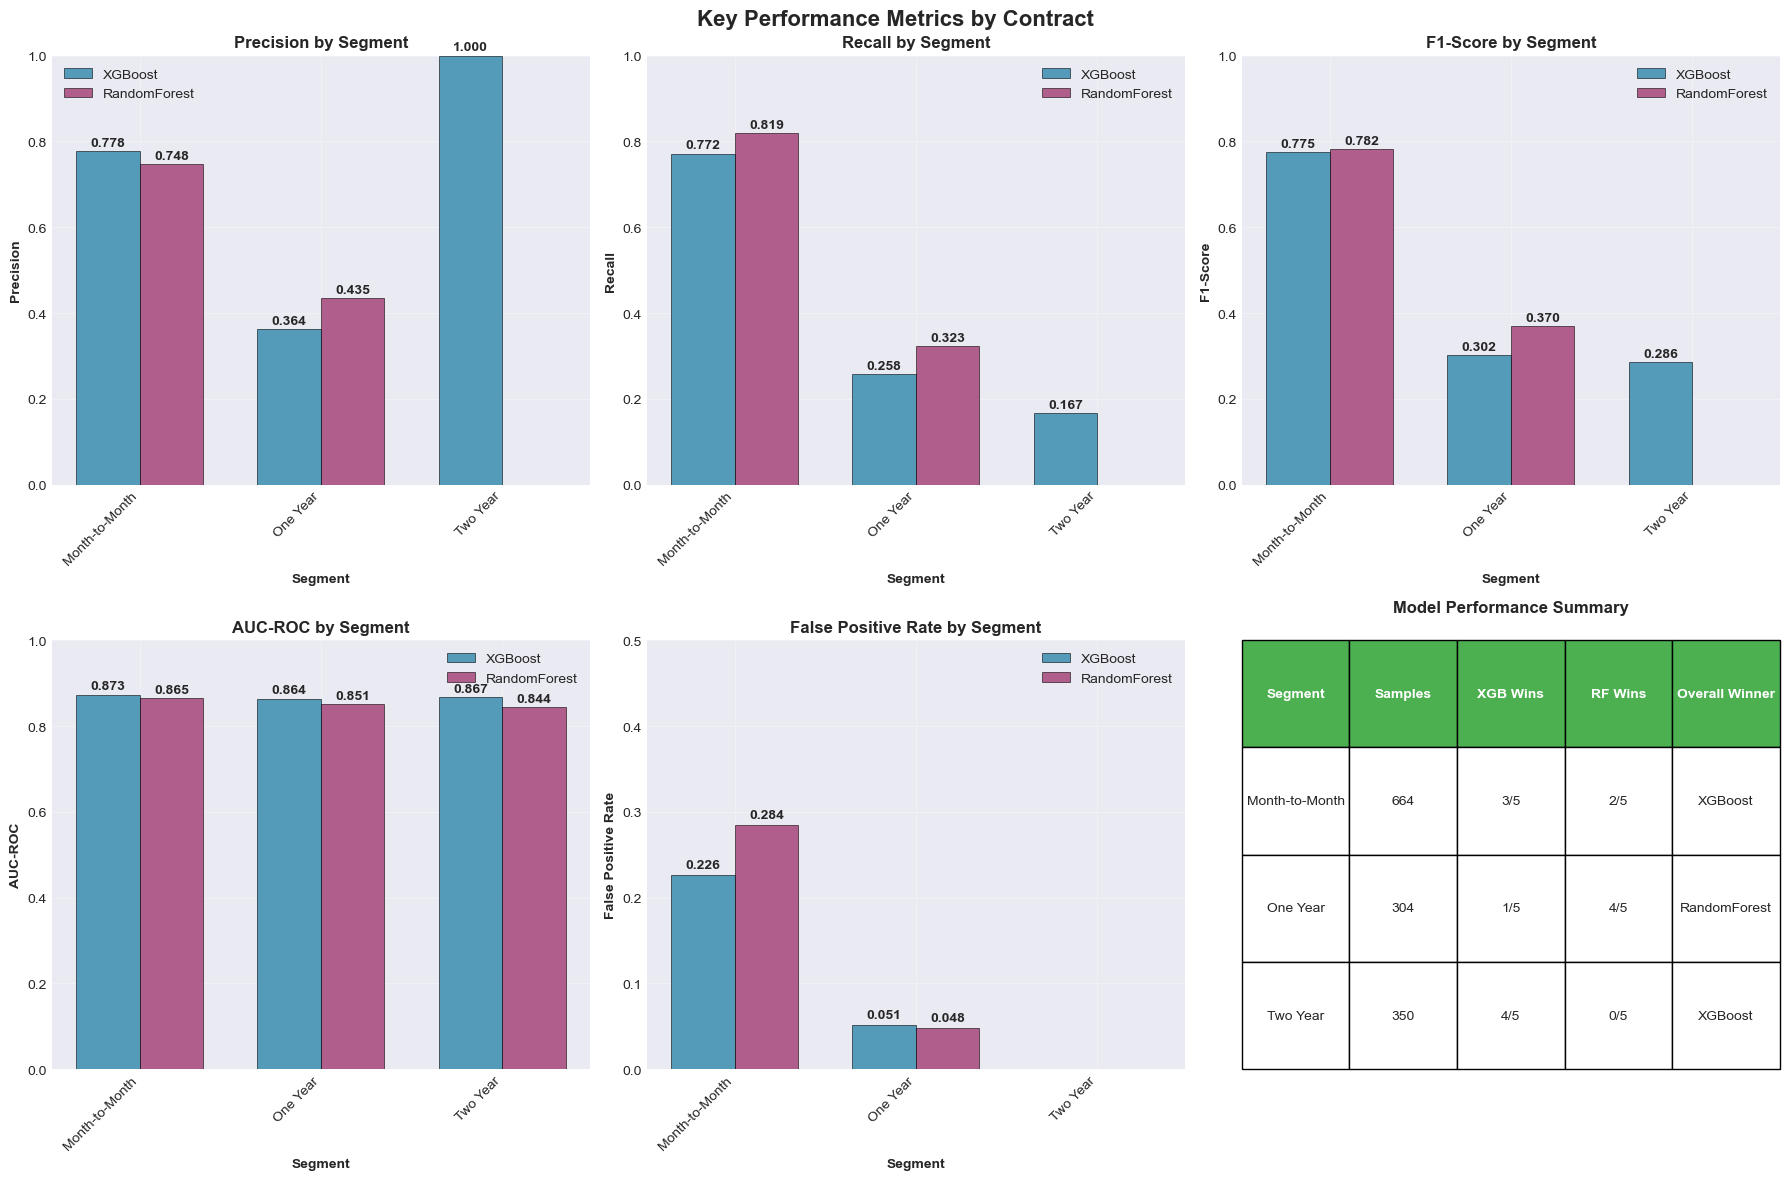

In [48]:
segment_results = evaluate_model_on_segments(
    dfX_original=dfX_original,     # DataFrame original con columna de segmento
    results=results,               # Resultados del entrenamiento  
    segment_column='contract',    # Columna para segmentar
    random_state=42               # Mismo random_state
)

In [14]:
total_charges = df_test_copy[['totalCharges']].copy()
total_charges

,totalCharges
0,593.30
1,542.40
2,280.85
3,1237.85
4,267.40
...,...
7038,742.90
7039,1873.70
7040,92.75
7041,4627.65


In [18]:
print("****" * 50)
print("****" * 50)
print("****" * 50)
print('Contrato Mensual')
dfX=''
dfX = df_test_copy.copy()
# Filtrar solo los clientes con contrato "Month-to-Month"
dfX = dfX[dfX['contract'] == 'Month-to-Month'].reset_index(drop=True)

# Eliminar la feature 'contract' si existe
if 'contract' in dfX.columns:
    dfX = dfX.drop(columns=['contract'])

print(dfX.shape)
# Eliminar filas donde customerStatus es 'Joined'
dfX = dfX[dfX['customerStatus'] != 'Joined'].reset_index(drop=True)
total_charges = dfX[['totalCharges']].copy()
eliminar = ['churnCategory','churnReason', 'totalCharges', 'totalRefunds', 'totalExtraDataCharges','totalLongDistanceCharges']
dfX = dfX.drop(columns=[col for col in eliminar if col in dfX.columns])



# 2. y - Variable objetivo
y = dfX['customerStatus'].map({'Churned': 1, 'Stayed': 0}).values  # Crear directamente como numpy array

# Eliminar 'customerStatus' de dfX
if 'customerStatus' in dfX.columns:
    dfX = dfX.drop(columns=['customerStatus'])
    
#dfX_dummy - Crear variables dummy
dfX_dummy = pd.get_dummies(dfX, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dfX_dummy)

##llmar a la funcion compare_models_with_cv_and_threshold

results = compare_models_with_cv_and_threshold(
    X=X_scaled,           # Características escaladas (numpy array)
    y=y,                  # Variable objetivo (numpy array)
    cv_folds=5,           # Validación cruzada con 5 folds
    random_state=42,       # Semilla para reproducibilidad
    total_charges=total_charges
    
) 

********************************************************************************************************************************************************************************************************
********************************************************************************************************************************************************************************************************
********************************************************************************************************************************************************************************************************
Contrato Mensual
(3610, 32)


ValueError: not enough values to unpack (expected 6, got 4)

🚀 ANÁLISIS COMPLETO CON MODELOS AVANZADOS
📊 DIVISIÓN ESTRATÉGICA DE DATOS
📈 DISTRIBUCIÓN FINAL:
   • Total muestras: 6,589
   • Train: 4,216 (64.0%)
   • Validation: 1,055 (16.0%)
   • Test: 1,318 (20.0%)

📊 DISTRIBUCIÓN DE CLASES:
   Train: Clase 0: 3020 (71.6%) Clase 1: 1196 (28.4%) 
     Val: Clase 0: 756 (71.7%) Clase 1: 299 (28.3%) 
    Test: Clase 0: 944 (71.6%) Clase 1: 374 (28.4%) 

🏆 COMPARACIÓN COMPLETA DE MODELOS
📊 Entrenando modelos baseline...

🚀 Entrenando XGBoost...

🚀 ENTRENAMIENTO XGBOOST
🏃 Usando parámetros por defecto...

📊 RESULTADOS XGBOOST:
   Train: Acc=0.918, AUC=0.973
   Val:   Acc=0.879, AUC=0.936
   Test:  Acc=0.866, AUC=0.926

🧠 Entrenando Red Neuronal (sklearn)...

🧠 ENTRENAMIENTO RED NEURONAL (Scikit-learn)
🏃 Usando arquitectura estándar...

📊 RESULTADOS RED NEURONAL:
   Train: Acc=0.835, AUC=0.821
   Val:   Acc=0.828, AUC=0.825
   Test:  Acc=0.803, AUC=0.821

🔥 Entrenando Red Neuronal Profunda (Keras)...

🔥 ENTRENAMIENTO RED NEURONAL PROFUNDA (Keras)
🏗️  

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,953 (242.00 KB)

 Trainable params: 61,057 (238.50 KB)

 Non-trainable params: 896 (3.50 KB)

🚀 Iniciando entrenamiento...
Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7421 - accuracy: 0.7630 - loss: 0.5137 - val_AUC: 0.8274 - val_accuracy: 0.8209 - val_loss: 0.4199 - learning_rate: 0.0010
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7934 - accuracy: 0.7993 - loss: 0.4642 - val_AUC: 0.8319 - val_accuracy: 0.8294 - val_loss: 0.4089 - learning_rate: 0.0010
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8114 - accuracy: 0.8067 - loss: 0.4455 - val_AUC: 0.8566 - val_accuracy: 0.8303 - val_loss: 0.3884 - learning_rate: 0.0010
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8227 - accuracy: 0.8214 - loss: 0.4277 - val_AUC: 0.8413 - val_accuracy: 0.8256 - val_loss: 0.3971 - learning_rate: 0.0010
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8243 - accuracy: 0.8178 - loss: 0.4265 - val_AUC: 0.8614 - val_accuracy: 0.8284 - val_loss: 0.3837 - learning_rate: 0.0010
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

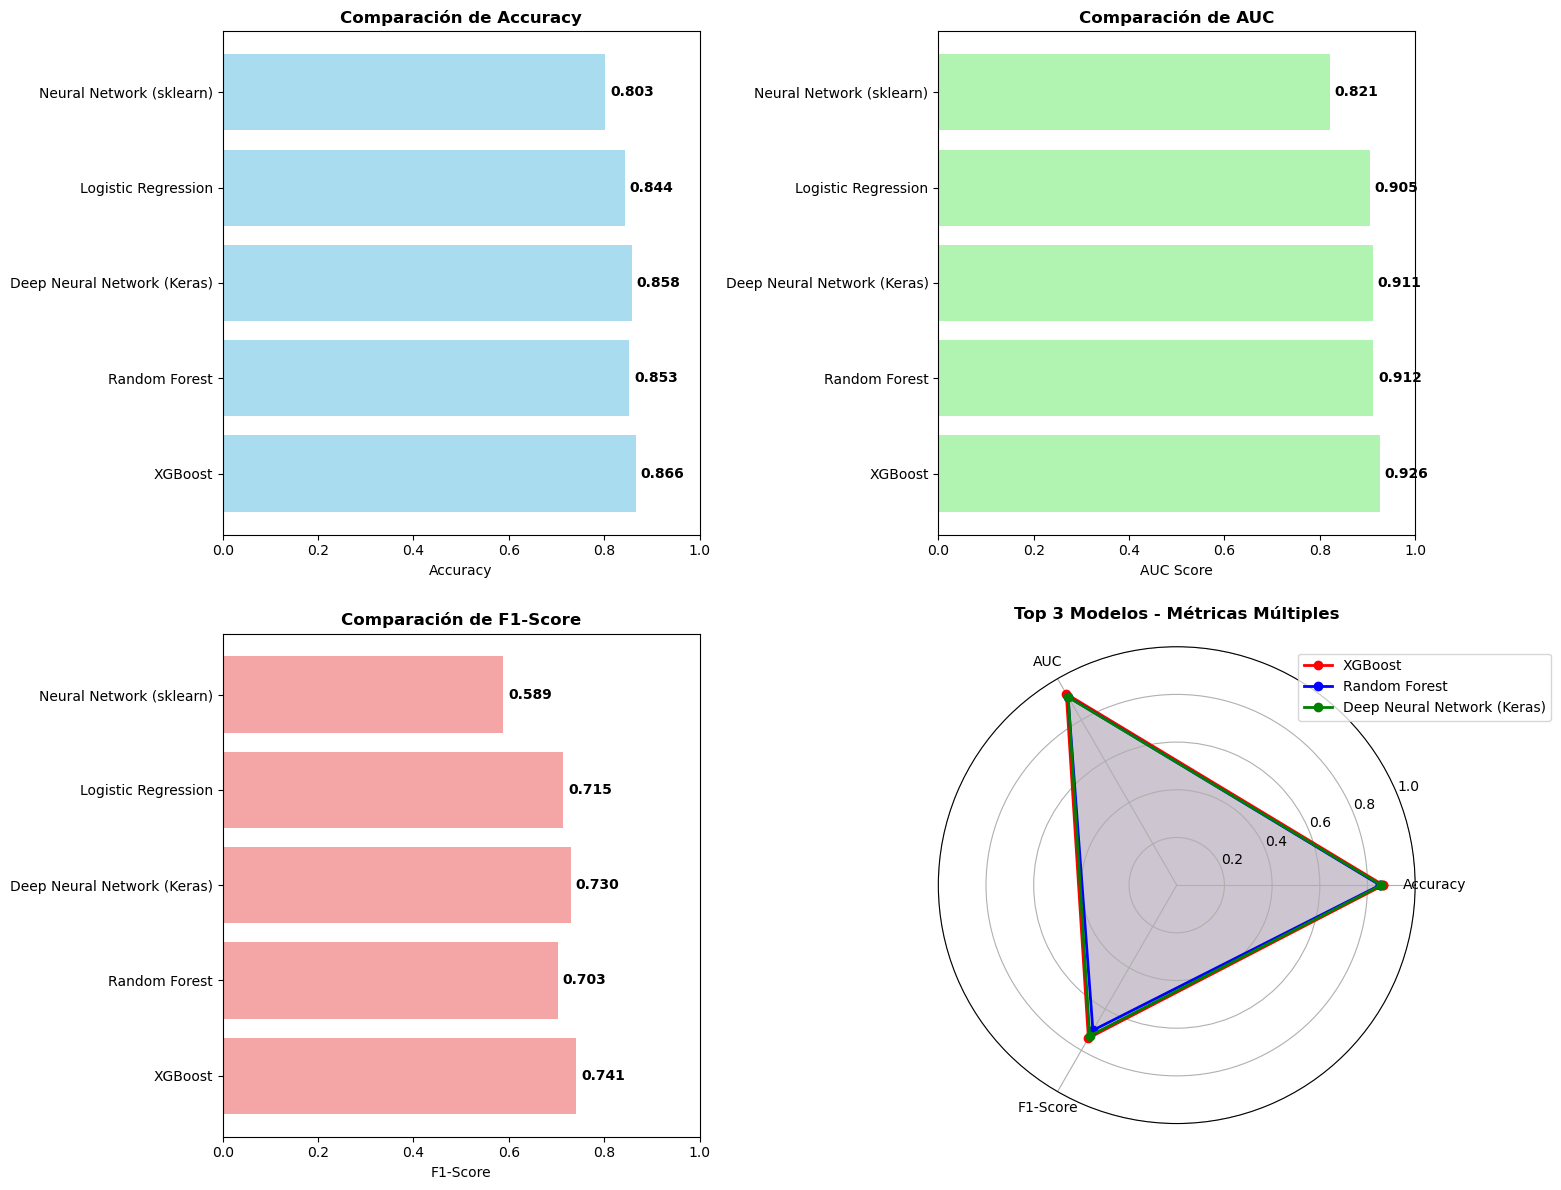

Mejor modelo: XGBoost


In [133]:
results_original = complete_advanced_ml_analysis(dfX_dummy, y, use_pca=False)

# Ver resultados
print("Mejor modelo:", results_original['best_model'])

In [ ]:
# Crear grupos de edad
dfX['age_group'] = pd.cut(dfX['age'], 
                         bins=[0, 30, 50, 65, 100], 
                         labels=['<30', '30-49', '50-64', '65+'])

# Ver churn por grupo
churn_by_group = pd.crosstab(dfX['age_group'], dfy['customerStatus'], normalize='index')
print(churn_by_group)

customerStatus         0         1
age_group                         
<30             0.759831  0.240169
30-49           0.744254  0.255746
50-64           0.729574  0.270426
65+             0.569632  0.430368


### Ingeniera de características


In [134]:
# Contar servicios de entretenimiento, no asumir que se deban eliminar las indivuales, la que me da mejor la mejor respues es para modelar.
df_test_copy['entertainment_services_count'] = (
    df_test_copy['streamingTv'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['streamingMovies'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['streamingMusic'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['unlimitedData'].map({'Yes': 1}).fillna(0).astype(int)
)

# Contar servicios de protección
df_test_copy['protection_services_count'] = (
    df_test_copy['onlineSecurity'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['onlineBackup'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['deviceProtectionPlan'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['premiumTechSupport'].map({'Yes': 1}).fillna(0).astype(int)
)

# Total de servicios adicionales
df_test_copy['total_addon_services'] = df_test_copy['entertainment_services_count'] + df_test_copy['protection_services_count']

# Perfil de consumidor, viene bien dar la transformacion las variables. Sofre esfuerzo en combinaciones complejas hay modelos que ya encuentran las interacciones por defecto.
def consumer_profile(row):
    ent = row['entertainment_services_count']
    prot = row['protection_services_count']
    
    if ent >= 3 and prot >= 2: return 'Premium_All'
    elif ent >= 2: return 'Entertainment_Heavy'
    elif prot >= 2: return 'Security_Conscious'
    elif ent >= 1 or prot >= 1: return 'Moderate_User'
    else: return 'Basic_Only'

df_test_copy['consumer_profile'] = df_test_copy.apply(consumer_profile, axis=1)

# Propensión al exceso de uso
df_test_copy['data_overage_propensity'] = df_test_copy['totalExtraDataCharges'] / np.maximum(df_test_copy['totalCharges'], 1)
df_test_copy['longdist_usage_propensity'] = df_test_copy['totalLongDistanceCharges'] / np.maximum(df_test_copy['totalCharges'], 1)

# Indicador de usuario intensivo
df_test_copy['heavy_user'] = np.where(
    (df_test_copy['totalExtraDataCharges'] > 0) | (df_test_copy['avgMonthlyGbDownload'] > df_test_copy['avgMonthlyGbDownload'].quantile(0.75)),
    'Heavy', 'Normal'
)

# Ratio de servicios vs tenure (adopción temprana vs tardía)
df_test_copy['service_adoption_rate'] = df_test_copy['total_addon_services'] / np.maximum(df_test_copy  ['tenureInMonths'], 1)

df_test_copy['base_revenue'] = df_test_copy['totalCharges'] - df_test_copy['totalExtraDataCharges'] - df_test_copy['totalLongDistanceCharges']
df_test_copy['usage_revenue'] = df_test_copy['totalExtraDataCharges'] + df_test_copy['totalLongDistanceCharges']
df_test_copy['usage_revenue_ratio'] = df_test_copy['usage_revenue'] / np.maximum(df_test_copy['totalRevenue'], 1)

def profitability_tier(revenue_value, revenue_series):
    if revenue_value > revenue_series.quantile(0.8): 
        return 'High_Value'
    elif revenue_value > revenue_series.quantile(0.6): 
        return 'Medium_High'
    elif revenue_value > revenue_series.quantile(0.4): 
        return 'Medium'
    elif revenue_value > revenue_series.quantile(0.2): 
        return 'Medium_Low'
    else: 
        return 'Low_Value'

df_test_copy['value_tier'] = df_test_copy['totalRevenue'].apply(
    lambda x: profitability_tier(x, df_test_copy['totalRevenue'])
)

modelo_final_corregido = [
    # Core business metrics
    'tenureInMonths',
    'totalRevenue',
    'contract',
    
    # Service adoption pattern
    'consumer_profile',          # En lugar de servicios individuales
    'entertainment_services_count',
    'protection_services_count',
    
    # Usage behavior  
    'data_overage_propensity',
    'heavy_user',
    'multipleLines',            # Sí es independiente
    
    # Social & promotional
    'numberOfReferrals',
    'offer',
]

### Conclusiones

Dado el objetivo planteado de disminuir el Churned, la variable dependiente es Customer Status, pero también podría ser Teneru in Months si quisieramos predicir el tiempo de permanencia, u Offer si quisieramos predecir la mejor oferta aceptada por el cliente.

Se evaluó la variable categórica objetivo Customer Status que tenia 3 valores: Se quedó (Stayed 67%), Se unió (Joined 6.4%) y se fue (Chuned 26.5%). Para la clasificación se optó por transformar los valores de Joined a stayed , quedando solo 2 valores Not Churned y Churned. 

Se eliminó los valores nulos o vacios al tener en cuenta que los clientes que no tienen servicio de internet tenían estas características vacias: internetType, onlineBackup, onlineSecurity, deviceProtectionPlan, premiumTechSupport, streamingTv, streamingMovies, streamingMusic, unlimitedData, todas las columnas relacionadas () se marcan como 'NoInternetService'.De forma similar, cuando no hay servicio telefónico, la columna multipleLines se marca como 'NoPhoneService'. Para las ofertas faltantes se usa 'NoOfferAccepted', y para clientes que stayed o Joined se marca churnCategory y churnReason como 'NoChurn'. Finalmente se elimina la columna customerId del dataset que sirve para identificar al cliente.

Valor monetario de las 1869 personas con Churned es 3 684 459.82 USA que es el 17% del revenue total, que representa el 26.5% de las personas.

Las mejores variables predictoras son el tipo de contrato, número de referidos y el tiempo de cliente.

Entre 1 y 10 meses de estar en la empresa son las personas con mayor porcentaje de Churned, las personas con más churned son que no han dado referidos, dao que mientras mas satisfacción haya, es más probable que se quede. Asimimos, que tienen contrato mensual, que retira dinero del banco, paga entre 70 y 120 USA, y entre 65 y 80 años.

En relación a las ofertas, las A,B,C y D mucha mayor proposición a stayed y las E, tiene un Churned mayor a Stayed. A los que recién se han unido joined solo ha ofertes E.

En las correlaciones númericas se encontró una alta  entre  totalCharges y totalRevenue, que se explica dado que la segunda esta en función de la primera. 





In [172]:
import math
from scipy.stats import binom
import numpy as np

# Data from the HIP mammography study
n_T = 31000  # treatment group size
n_C = 31000  # control group size
y_T = 39     # deaths in treatment group
y_C = 63     # deaths in control group

print("HIP Mammography Study Data:")
print(f"Treatment group: {y_T} deaths out of {n_T} participants")
print(f"Control group: {y_C} deaths out of {n_C} participants")
print("-" * 50)

# Calculate MLE estimates
pi_0_MLE = (y_T + y_C) / (n_T + n_C)  # pooled estimate under H0
pi_T_MLE = y_T / n_T                  # treatment group MLE
pi_C_MLE = y_C / n_C                  # control group MLE

print("Maximum Likelihood Estimates:")
print(f"π₀^MLE (pooled under H₀) = {pi_0_MLE:.6f}")
print(f"π_T^MLE (treatment) = {pi_T_MLE:.6f}")
print(f"π_C^MLE (control) = {pi_C_MLE:.6f}")
print("-" * 50)

# Calculate log-likelihoods under H0 (null hypothesis: πT = πC)
print("Log-likelihood under H₀ (πT = πC):")
log_likelihood_H0_T = binom.logpmf(y_T, n_T, pi_0_MLE)
log_likelihood_H0_C = binom.logpmf(y_C, n_C, pi_0_MLE)
log_likelihood_H0 = log_likelihood_H0_T + log_likelihood_H0_C

print(f"  Treatment component: {log_likelihood_H0_T:.6f}")
print(f"  Control component: {log_likelihood_H0_C:.6f}")
print(f"  Total log-likelihood: {log_likelihood_H0:.6f}")

# Calculate log-likelihoods under H1 (alternative hypothesis: πT ≠ πC)
print("\nLog-likelihood under H₁ (πT ≠ πC):")
log_likelihood_H1_T = binom.logpmf(y_T, n_T, pi_T_MLE)
log_likelihood_H1_C = binom.logpmf(y_C, n_C, pi_C_MLE)
log_likelihood_H1 = log_likelihood_H1_T + log_likelihood_H1_C

print(f"  Treatment component: {log_likelihood_H1_T:.6f}")
print(f"  Control component: {log_likelihood_H1_C:.6f}")
print(f"  Total log-likelihood: {log_likelihood_H1:.6f}")
print("-" * 50)

# Calculate the likelihood ratio test statistic
Lambda = -2 * (log_likelihood_H0 - log_likelihood_H1)

print("Likelihood Ratio Test Statistic:")
print(f"Λ = -2 × (log L₀ - log L₁)")
print(f"Λ = -2 × ({log_likelihood_H0:.6f} - {log_likelihood_H1:.6f})")
print(f"Λ = -2 × ({log_likelihood_H0 - log_likelihood_H1:.6f})")
print(f"Λ = {Lambda:.3f}")
print("-" * 50)

# Additional information
print("Interpretation:")
print(f"• The treatment group has a lower death rate ({pi_T_MLE:.6f}) than control ({pi_C_MLE:.6f})")
print(f"• Under H₁, the data is more likely (log-likelihood = {log_likelihood_H1:.3f})")
print(f"• Under H₀, the data is less likely (log-likelihood = {log_likelihood_H0:.3f})")
print(f"• The test statistic Λ = {Lambda:.3f} measures this difference")

# For reference, show the critical value at α = 0.05
from scipy.stats import chi2
critical_value = chi2.ppf(0.95, df=1)  # df = 1 for this test
print(f"• Critical value at α = 0.05: {critical_value:.3f}")
if Lambda > critical_value:
    print("• Result: Reject H₀ (significant difference in death rates)")
else:
    print("• Result: Fail to reject H₀ (no significant difference)")

HIP Mammography Study Data:
Treatment group: 39 deaths out of 31000 participants
Control group: 63 deaths out of 31000 participants
--------------------------------------------------
Maximum Likelihood Estimates:
π₀^MLE (pooled under H₀) = 0.001645
π_T^MLE (treatment) = 0.001258
π_C^MLE (control) = 0.002032
--------------------------------------------------
Log-likelihood under H₀ (πT = πC):
  Treatment component: -4.292257
  Control component: -4.305611
  Total log-likelihood: -8.597868

Log-likelihood under H₁ (πT ≠ πC):
  Treatment component: -2.752227
  Control component: -2.990811
  Total log-likelihood: -5.743038
--------------------------------------------------
Likelihood Ratio Test Statistic:
Λ = -2 × (log L₀ - log L₁)
Λ = -2 × (-8.597868 - -5.743038)
Λ = -2 × (-2.854830)
Λ = 5.710
--------------------------------------------------
Interpretation:
• The treatment group has a lower death rate (0.001258) than control (0.002032)
• Under H₁, the data is more likely (log-likelihood

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, f1_score, accuracy_score)
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')

def create_optimal_data_splits(X, y, test_size=0.2, val_size=0.2, random_state=42):
    """
    Crear divisiones óptimas de datos con estratificación
    
    Parameters:
    X: Features (puede ser X_pca o dfX_dummy)
    y: Target variable
    test_size: Proporción para test (0.2 = 20%)
    val_size: Proporción de train para validación (0.2 = 20% del train)
    
    Returns:
    dict con todas las divisiones
    """
    print("📊 DIVISIÓN ESTRATÉGICA DE DATOS")
    print("=" * 50)
    
    # Convertir y a numérico si es necesario
    if not pd.api.types.is_numeric_dtype(y):
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        print(f"Target codificado: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    else:
        y_encoded = y
        le = None
    
    # División inicial: Train+Val vs Test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_encoded, 
        test_size=test_size, 
        random_state=random_state,
        stratify=y_encoded
    )
    
    # División: Train vs Validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_size,  # Del 80% restante, 20% para validación
        random_state=random_state,
        stratify=y_temp
    )
    
    # Calcular proporciones finales
    total_samples = len(X)
    train_prop = len(X_train) / total_samples
    val_prop = len(X_val) / total_samples
    test_prop = len(X_test) / total_samples
    
    print(f"📈 DISTRIBUCIÓN FINAL:")
    print(f"   • Total muestras: {total_samples:,}")
    print(f"   • Train: {len(X_train):,} ({train_prop:.1%})")
    print(f"   • Validation: {len(X_val):,} ({val_prop:.1%})")
    print(f"   • Test: {len(X_test):,} ({test_prop:.1%})")
    
    # Verificar distribución de clases
    print(f"\n📊 DISTRIBUCIÓN DE CLASES:")
    for split_name, split_y in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
        unique, counts = np.unique(split_y, return_counts=True)
        percentages = counts / len(split_y) * 100
        print(f"   {split_name:>5}: ", end="")
        for cls, count, pct in zip(unique, counts, percentages):
            print(f"Clase {cls}: {count} ({pct:.1f}%) ", end="")
        print()
    
    return {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'label_encoder': le,
        'splits_info': {
            'train_size': len(X_train),
            'val_size': len(X_val), 
            'test_size': len(X_test),
            'train_prop': train_prop,
            'val_prop': val_prop,
            'test_prop': test_prop
        }
    }

def train_xgboost_model(data_splits, tune_hyperparams=True):
    """
    Entrenar modelo XGBoost con validación y tuning opcional
    """
    print("\n🚀 ENTRENAMIENTO XGBOOST")
    print("=" * 40)
    
    X_train, X_val, X_test = data_splits['X_train'], data_splits['X_val'], data_splits['X_test']
    y_train, y_val, y_test = data_splits['y_train'], data_splits['y_val'], data_splits['y_test']
    
    if tune_hyperparams:
        print("🔧 Optimizando hiperparámetros...")
        
        # Grid search para XGBoost
        param_grid = {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [100, 200, 300],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
        
        xgb_base = xgb.XGBClassifier(
            random_state=42,
            eval_metric='logloss',
            early_stopping_rounds=10
        )
        
        # Usar validación estratificada
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            xgb_base, param_grid,
            cv=skf, scoring='roc_auc',
            n_jobs=-1, verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        best_xgb = grid_search.best_estimator_
        
        print(f"✅ Mejores parámetros: {grid_search.best_params_}")
        print(f"✅ Mejor CV score: {grid_search.best_score_:.4f}")
    else:
        print("🏃 Usando parámetros por defecto...")
        best_xgb = xgb.XGBClassifier(
            max_depth=5,
            learning_rate=0.1,
            n_estimators=200,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            eval_metric='logloss',
            early_stopping_rounds=10  # Mover aquí
        )
        
        # Entrenar con early stopping
        best_xgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
    
    # Predicciones
    y_train_pred = best_xgb.predict(X_train)
    y_val_pred = best_xgb.predict(X_val)
    y_test_pred = best_xgb.predict(X_test)
    
    y_train_proba = best_xgb.predict_proba(X_train)[:, 1]
    y_val_proba = best_xgb.predict_proba(X_val)[:, 1]
    y_test_proba = best_xgb.predict_proba(X_test)[:, 1]
    
    # Métricas
    results = {
        'model': best_xgb,
        'model_name': 'XGBoost',
        'train_acc': accuracy_score(y_train, y_train_pred),
        'val_acc': accuracy_score(y_val, y_val_pred),
        'test_acc': accuracy_score(y_test, y_test_pred),
        'train_auc': roc_auc_score(y_train, y_train_proba),
        'val_auc': roc_auc_score(y_val, y_val_proba),
        'test_auc': roc_auc_score(y_test, y_test_proba),
        'train_f1': f1_score(y_train, y_train_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'predictions': y_test_pred,
        'probabilities': y_test_proba
    }
    
    print(f"\n📊 RESULTADOS XGBOOST:")
    print(f"   Train: Acc={results['train_acc']:.3f}, AUC={results['train_auc']:.3f}")
    print(f"   Val:   Acc={results['val_acc']:.3f}, AUC={results['val_auc']:.3f}")
    print(f"   Test:  Acc={results['test_acc']:.3f}, AUC={results['test_auc']:.3f}")
    
    return results

def train_neural_network_sklearn(data_splits, tune_hyperparams=True):
    """
    Entrenar red neuronal con scikit-learn (MLPClassifier)
    """
    print("\n🧠 ENTRENAMIENTO RED NEURONAL (Scikit-learn)")
    print("=" * 50)
    
    X_train, X_val, X_test = data_splits['X_train'], data_splits['X_val'], data_splits['X_test']
    y_train, y_val, y_test = data_splits['y_train'], data_splits['y_val'], data_splits['y_test']
    
    if tune_hyperparams:
        print("🔧 Optimizando arquitectura...")
        
        param_grid = {
            'hidden_layer_sizes': [
                (100,), (200,), (100, 50), (200, 100), 
                (100, 100, 50), (200, 100, 50)
            ],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01, 0.1]
        }
        
        mlp_base = MLPClassifier(
            max_iter=1000,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )
        
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        grid_search = GridSearchCV(
            mlp_base, param_grid,
            cv=skf, scoring='roc_auc',
            n_jobs=-1, verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        best_mlp = grid_search.best_estimator_
        
        print(f"✅ Mejor arquitectura: {grid_search.best_params_}")
        print(f"✅ Mejor CV score: {grid_search.best_score_:.4f}")
    else:
        print("🏃 Usando arquitectura estándar...")
        best_mlp = MLPClassifier(
            hidden_layer_sizes=(200, 100, 50),
            alpha=0.001,
            learning_rate_init=0.01,
            max_iter=1000,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )
        
        best_mlp.fit(X_train, y_train)
    
    # Predicciones
    y_train_pred = best_mlp.predict(X_train)
    y_val_pred = best_mlp.predict(X_val)
    y_test_pred = best_mlp.predict(X_test)
    
    y_train_proba = best_mlp.predict_proba(X_train)[:, 1]
    y_val_proba = best_mlp.predict_proba(X_val)[:, 1]
    y_test_proba = best_mlp.predict_proba(X_test)[:, 1]
    
    results = {
        'model': best_mlp,
        'model_name': 'Neural Network (sklearn)',
        'train_acc': accuracy_score(y_train, y_train_pred),
        'val_acc': accuracy_score(y_val, y_val_pred),
        'test_acc': accuracy_score(y_test, y_test_pred),
        'train_auc': roc_auc_score(y_train, y_train_proba),
        'val_auc': roc_auc_score(y_val, y_val_proba),
        'test_auc': roc_auc_score(y_test, y_test_proba),
        'train_f1': f1_score(y_train, y_train_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'predictions': y_test_pred,
        'probabilities': y_test_proba
    }
    
    print(f"\n📊 RESULTADOS RED NEURONAL:")
    print(f"   Train: Acc={results['train_acc']:.3f}, AUC={results['train_auc']:.3f}")
    print(f"   Val:   Acc={results['val_acc']:.3f}, AUC={results['val_auc']:.3f}")
    print(f"   Test:  Acc={results['test_acc']:.3f}, AUC={results['test_auc']:.3f}")
    
    return results

def train_deep_neural_network_keras(data_splits, epochs=100):
    """
    Entrenar red neuronal profunda con Keras/TensorFlow
    """
    print("\n🔥 ENTRENAMIENTO RED NEURONAL PROFUNDA (Keras)")
    print("=" * 60)
    
    X_train, X_val, X_test = data_splits['X_train'], data_splits['X_val'], data_splits['X_test']
    y_train, y_val, y_test = data_splits['y_train'], data_splits['y_val'], data_splits['y_test']
    
    # Definir arquitectura
    input_dim = X_train.shape[1]
    
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )
    
    print(f"🏗️  ARQUITECTURA CREADA:")
    model.summary()
    
    # Callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor='val_auc',
        patience=15,
        restore_best_weights=True,
        mode='max'
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=0.00001
    )
    
    # Entrenar
    print("🚀 Iniciando entrenamiento...")
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Predicciones
    y_train_proba = model.predict(X_train).flatten()
    y_val_proba = model.predict(X_val).flatten()
    y_test_proba = model.predict(X_test).flatten()
    
    y_train_pred = (y_train_proba > 0.5).astype(int)
    y_val_pred = (y_val_proba > 0.5).astype(int)
    y_test_pred = (y_test_proba > 0.5).astype(int)
    
    results = {
        'model': model,
        'model_name': 'Deep Neural Network (Keras)',
        'history': history,
        'train_acc': accuracy_score(y_train, y_train_pred),
        'val_acc': accuracy_score(y_val, y_val_pred),
        'test_acc': accuracy_score(y_test, y_test_pred),
        'train_auc': roc_auc_score(y_train, y_train_proba),
        'val_auc': roc_auc_score(y_val, y_val_proba),
        'test_auc': roc_auc_score(y_test, y_test_proba),
        'train_f1': f1_score(y_train, y_train_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'predictions': y_test_pred,
        'probabilities': y_test_proba
    }
    
    print(f"\n📊 RESULTADOS RED PROFUNDA:")
    print(f"   Train: Acc={results['train_acc']:.3f}, AUC={results['train_auc']:.3f}")
    print(f"   Val:   Acc={results['val_acc']:.3f}, AUC={results['val_auc']:.3f}")
    print(f"   Test:  Acc={results['test_acc']:.3f}, AUC={results['test_auc']:.3f}")
    
    return results

def compare_all_models(data_splits, include_baseline=True):
    """
    Comparar todos los modelos: Baseline + XGBoost + Neural Networks
    """
    print("\n🏆 COMPARACIÓN COMPLETA DE MODELOS")
    print("=" * 60)
    
    all_results = {}
    
    # Datos
    X_train, X_val, X_test = data_splits['X_train'], data_splits['X_val'], data_splits['X_test']
    y_train, y_val, y_test = data_splits['y_train'], data_splits['y_val'], data_splits['y_test']
    
    # 1. Modelos baseline (opcional)
    if include_baseline:
        print("📊 Entrenando modelos baseline...")
        
        # Logistic Regression
        lr = LogisticRegression(random_state=42, max_iter=1000)
        lr.fit(X_train, y_train)
        
        y_test_pred_lr = lr.predict(X_test)
        y_test_proba_lr = lr.predict_proba(X_test)[:, 1]
        
        all_results['Logistic Regression'] = {
            'test_acc': accuracy_score(y_test, y_test_pred_lr),
            'test_auc': roc_auc_score(y_test, y_test_proba_lr),
            'test_f1': f1_score(y_test, y_test_pred_lr)
        }
        
        # Random Forest
        rf = RandomForestClassifier(random_state=42, n_estimators=100)
        rf.fit(X_train, y_train)
        
        y_test_pred_rf = rf.predict(X_test)
        y_test_proba_rf = rf.predict_proba(X_test)[:, 1]
        
        all_results['Random Forest'] = {
            'test_acc': accuracy_score(y_test, y_test_pred_rf),
            'test_auc': roc_auc_score(y_test, y_test_proba_rf),
            'test_f1': f1_score(y_test, y_test_pred_rf)
        }
    
    # 2. XGBoost
    print("\n🚀 Entrenando XGBoost...")
    xgb_results = train_xgboost_model(data_splits, tune_hyperparams=False)
    all_results['XGBoost'] = {
        'test_acc': xgb_results['test_acc'],
        'test_auc': xgb_results['test_auc'],
        'test_f1': xgb_results['test_f1']
    }
    
    # 3. Neural Network (sklearn)
    print("\n🧠 Entrenando Red Neuronal (sklearn)...")
    nn_sklearn_results = train_neural_network_sklearn(data_splits, tune_hyperparams=False)
    all_results['Neural Network (sklearn)'] = {
        'test_acc': nn_sklearn_results['test_acc'],
        'test_auc': nn_sklearn_results['test_auc'],
        'test_f1': nn_sklearn_results['test_f1']
    }
    
    # 4. Deep Neural Network (Keras)
    print("\n🔥 Entrenando Red Neuronal Profunda (Keras)...")
    try:
        dnn_results = train_deep_neural_network_keras(data_splits, epochs=50)
        all_results['Deep Neural Network (Keras)'] = {
            'test_acc': dnn_results['test_acc'],
            'test_auc': dnn_results['test_auc'],
            'test_f1': dnn_results['test_f1']
        }
    except Exception as e:
        print(f"⚠️  Error con Keras: {e}")
        print("Continuando sin red neuronal profunda...")
    
    # Crear tabla comparativa
    print(f"\n📊 TABLA COMPARATIVA FINAL:")
    print("-" * 70)
    print(f"{'Modelo':<30} {'Accuracy':<10} {'AUC':<10} {'F1-Score':<10}")
    print("-" * 70)
    
    # Ordenar por AUC
    sorted_results = sorted(all_results.items(), 
                           key=lambda x: x[1]['test_auc'], reverse=True)
    
    best_model = None
    best_auc = 0
    
    for model_name, metrics in sorted_results:
        acc = metrics['test_acc']
        auc = metrics['test_auc'] 
        f1 = metrics['test_f1']
        
        print(f"{model_name:<30} {acc:<10.3f} {auc:<10.3f} {f1:<10.3f}")
        
        if auc > best_auc:
            best_auc = auc
            best_model = model_name
    
    print("-" * 70)
    print(f"🏆 MEJOR MODELO: {best_model} (AUC = {best_auc:.3f})")
    
    return all_results, sorted_results

def plot_model_comparison(all_results, sorted_results):
    """
    Visualizar comparación de modelos
    """
    print(f"\n📊 CREANDO VISUALIZACIONES...")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    models = [result[0] for result in sorted_results]
    accuracies = [result[1]['test_acc'] for result in sorted_results]
    aucs = [result[1]['test_auc'] for result in sorted_results]
    f1s = [result[1]['test_f1'] for result in sorted_results]
    
    # 1. Accuracy comparison
    bars1 = ax1.barh(models, accuracies, color='skyblue', alpha=0.7)
    ax1.set_xlabel('Accuracy')
    ax1.set_title('Comparación de Accuracy', fontweight='bold')
    ax1.set_xlim(0, 1)
    
    for bar, acc in zip(bars1, accuracies):
        ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{acc:.3f}', va='center', fontweight='bold')
    
    # 2. AUC comparison  
    bars2 = ax2.barh(models, aucs, color='lightgreen', alpha=0.7)
    ax2.set_xlabel('AUC Score')
    ax2.set_title('Comparación de AUC', fontweight='bold')
    ax2.set_xlim(0, 1)
    
    for bar, auc in zip(bars2, aucs):
        ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{auc:.3f}', va='center', fontweight='bold')
    
    # 3. F1-Score comparison
    bars3 = ax3.barh(models, f1s, color='lightcoral', alpha=0.7)
    ax3.set_xlabel('F1-Score')
    ax3.set_title('Comparación de F1-Score', fontweight='bold')
    ax3.set_xlim(0, 1)
    
    for bar, f1 in zip(bars3, f1s):
        ax3.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{f1:.3f}', va='center', fontweight='bold')
    
    # 4. Radar chart
    ax4.remove()
    ax4 = fig.add_subplot(2, 2, 4, projection='polar')
    
    # Solo mostrar top 3 modelos
    top_3_models = sorted_results[:3]
    metrics = ['Accuracy', 'AUC', 'F1-Score']
    
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Cerrar el círculo
    
    colors = ['red', 'blue', 'green']
    
    for i, (model_name, model_metrics) in enumerate(top_3_models):
        values = [model_metrics['test_acc'], model_metrics['test_auc'], model_metrics['test_f1']]
        values += values[:1]  # Cerrar el círculo
        
        ax4.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i])
        ax4.fill(angles, values, alpha=0.1, color=colors[i])
    
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(metrics)
    ax4.set_ylim(0, 1)
    ax4.set_title('Top 3 Modelos - Métricas Múltiples', fontweight='bold', pad=20)
    ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.tight_layout()
    plt.show()
    
    return fig

# FUNCIÓN PRINCIPAL
def complete_advanced_ml_analysis(X, y, use_pca=True, n_components=None):
    """
    Análisis completo con modelos avanzados
    
    Parameters:
    X: Features (dfX_dummy o X_pca)
    y: Target variable
    use_pca: Si aplicar PCA o usar X directamente
    n_components: Número de componentes PCA
    """
    print("🚀 ANÁLISIS COMPLETO CON MODELOS AVANZADOS")
    print("=" * 70)
    
    # 1. Aplicar PCA si se requiere
    if use_pca:
        print("🔄 Aplicando PCA...")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        pca = PCA(n_components=n_components)
        X_final = pca.fit_transform(X_scaled)
        
        print(f"   • Componentes seleccionados: {X_final.shape[1]}")
        print(f"   • Varianza explicada: {pca.explained_variance_ratio_.sum():.1%}")
    else:
        X_final = X
        scaler = None
        pca = None
    
    # 2. Dividir datos
    data_splits = create_optimal_data_splits(X_final, y)
    
    # 3. Comparar todos los modelos
    all_results, sorted_results = compare_all_models(data_splits)
    
    # 4. Visualizar resultados
    fig = plot_model_comparison(all_results, sorted_results)
    
    return {
        'data_splits': data_splits,
        'all_results': all_results,
        'sorted_results': sorted_results,
        'best_model': sorted_results[0][0],
        'scaler': scaler,
        'pca': pca,
        'visualization': fig
    }

# CÓDIGO DE EJECUCIÓN:
"""
# Opción 1: Con PCA
results_pca = complete_advanced_ml_analysis(dfX_dummy, y, use_pca=True, n_components=10)

# Opción 2: Sin PCA (datos originales)
results_original = complete_advanced_ml_analysis(dfX_dummy, y, use_pca=False)

# Ver resultados
print("Mejor modelo:", results_pca['best_model'])
"""

'\n# Opción 1: Con PCA\nresults_pca = complete_advanced_ml_analysis(dfX_dummy, y, use_pca=True, n_components=10)\n\n# Opción 2: Sin PCA (datos originales)\nresults_original = complete_advanced_ml_analysis(dfX_dummy, y, use_pca=False)\n\n# Ver resultados\nprint("Mejor modelo:", results_pca[\'best_model\'])\n'